In [1]:
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
import os
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from tqdm import tqdm
sns.set_palette('Dark2')
sns.set_context('paper')
sns.set_style({'axes.axisbelow': True, 
               'axes.edgecolor': '.15',
               'axes.facecolor': 'white',
               'axes.grid': True, 
               'axes.labelcolor': '.15', 
               'figure.facecolor': 'white', 
               'grid.color': '.15',
               'grid.linestyle': ':', 
               'grid.alpha': .5, 
               'image.cmap': 'Greys', 
               'legend.frameon': False, 
               'legend.numpoints': 1, 
               'legend.scatterpoints': 1,
               'lines.solid_capstyle': 'butt', 
               'axes.spines.right': False, 
               'axes.spines.top': False,  
               'text.color': '.15',  
               'xtick.top': False, 
               'ytick.right': False, 
               'xtick.color': '.15',
               'xtick.direction': 'out', 
               'ytick.color': '.15', 
               'ytick.direction': 'out', 
              })


import matplotlib

FONT_SIZE_PT = 5
matplotlib.rcParams['font.family'] = 'Arial'
matplotlib.rcParams['font.size'] = FONT_SIZE_PT
matplotlib.rcParams['axes.labelsize'] = FONT_SIZE_PT
matplotlib.rcParams['axes.titlesize'] = FONT_SIZE_PT
matplotlib.rcParams['figure.titlesize'] = FONT_SIZE_PT
matplotlib.rcParams['xtick.labelsize'] = FONT_SIZE_PT
matplotlib.rcParams['ytick.labelsize'] = FONT_SIZE_PT
matplotlib.rcParams['legend.fontsize'] = FONT_SIZE_PT
matplotlib.rcParams['legend.title_fontsize'] = FONT_SIZE_PT

matplotlib.rcParams['xtick.major.size'] = matplotlib.rcParams['ytick.major.size'] = 2
matplotlib.rcParams['xtick.major.width'] = matplotlib.rcParams['ytick.major.width'] = 0.5


matplotlib.rcParams['xtick.minor.size'] = matplotlib.rcParams['ytick.minor.size'] = 1

matplotlib.rcParams['xtick.minor.width'] = matplotlib.rcParams['ytick.minor.width'] = 0.5

matplotlib.rcParams['axes.linewidth'] = 0.5
matplotlib.rcParams['lines.linewidth'] = 0.5
matplotlib.rcParams['grid.linewidth'] = 0.25
matplotlib.rcParams['patch.linewidth'] = 0.25
matplotlib.rcParams['lines.markeredgewidth'] = 0.25
matplotlib.rcParams['lines.markersize'] = 2

FIVE_MM_IN_INCH = 0.19685
DPI = 600
matplotlib.rcParams['figure.figsize'] = (10 * FIVE_MM_IN_INCH, 9 * FIVE_MM_IN_INCH)
matplotlib.rcParams['savefig.dpi'] = DPI
matplotlib.rcParams['figure.dpi'] = DPI // 4


#http://phyletica.org/matplotlib-fonts/
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

# (03) Transformation and modeling

This notebook handles the core of the analysis:

1. Transformation of the numeric data into format that can be read by the model
2. Normalisation of the data
3. Modelling of differential enrichments

## Configuration

Input file (the numeric data from previous notebook):

In [2]:
import pathlib
INPUT_NUMERIC_DATA = pathlib.Path('outputs') / '01-extracting' / 'data_numeric.csv'
assert INPUT_NUMERIC_DATA.is_file()

INPUT_METADATA = pathlib.Path('outputs') / '01-extracting' / 'data_metadata.csv'
assert INPUT_METADATA.is_file()


Output directory:

In [3]:
import pathlib
OUTPUT_DIRECTORY = pathlib.Path('outputs') / '03-transformation-and-modelling'

if not OUTPUT_DIRECTORY.is_dir():
    OUTPUT_DIRECTORY.mkdir(parents=True)

Parameters, constants:

In [4]:
# To do analysis, we will require that:
#- at least this many (below) values per condition are set (for the condition analysed)
MINIMUM_NUMBER_OF_OBSERVED_VALUES_PER_CONDITION = 2

# Cutoff for BH-adjusted p-values
FDR_THRESHOLD = 0.05

## Reading Metadata

Reading the metadata from previous notebook

In [5]:
data_metadata = pd.read_csv(
    INPUT_METADATA,
    index_col=0,
)
data_metadata

# PSMs  # Peptides  # Unique Peptides Accession  Coverage [%]  \
Label                                                                   
GBE1         2           2                  2    Q04446             3   
EFTUD2      44          15                 14    Q15029            23   
YWHAB       44           9                  4    P31946            43   
YWHAE       53          11                  8    P62258            49   
YWHAH       38           9                  5    Q04917            42   
...        ...         ...                ...       ...           ...   
ZNF800       9           4                  4    Q2TB10             9   
ZRANB2       6           4                  4    O95218            10   
ZFR          3           2                  2    Q96KR1             4   
AZGP1       36           4                  4    P25311            18   
ZYX         35          10                 10    Q15942            31   

                                              Description    Gene  
Label                                                              
GBE1    1,4-alpha-glucan-branching enzyme OS=Homo sapi...    GBE1  
EFTUD2  116 kDa U5 small nuclear ribonucleoprotein com...  EFTUD2  
YWHAB   14-3-3 protein beta/alpha OS=Homo sapiens OX=9...   YWHAB  
YWHAE   14-3-3 protein epsilon OS=Homo sapiens OX=9606...   YWHAE  
YWHAH   14-3-3 protein eta OS=Homo sapiens OX=9606 GN=...   YWHAH  
...                                                   ...     ...  
ZNF800  Zinc finger protein 800 OS=Homo sapiens OX=960...  ZNF800  
ZRANB2  Zinc finger Ran-binding domain-containing prot...  ZRANB2  
ZFR     Zinc finger RNA-binding protein OS=Homo sapien...     ZFR  
AZGP1   Zinc-alpha-2-glycoprotein OS=Homo sapiens OX=9...   AZGP1  
ZYX        Zyxin OS=Homo sapiens OX=9606 GN=ZYX PE=1 SV=1     ZYX  

[1046 rows x 7 columns]

## Reading numeric data

Read the numeric data from previous notebook:

In [6]:
data_numeric = pd.read_csv(
    INPUT_NUMERIC_DATA,
    index_col=0
)
data_numeric.columns.name = 'Experiment_Replicate'
data_numeric

Experiment_Replicate          H3_1          H3_2          H3_3          H4_1  \
Label                                                                          
GBE1                           NaN           NaN           NaN           NaN   
EFTUD2                2.522426e+05  1.730602e+05  1.584524e+05  1.189396e+05   
YWHAB                 2.472521e+05  3.426881e+05  9.039318e+05  2.274400e+05   
YWHAE                 3.443775e+05  1.929841e+05           NaN  3.170019e+05   
YWHAH                 1.238786e+08  1.892759e+08  5.117897e+08  6.823328e+07   
...                            ...           ...           ...           ...   
ZNF800                1.516332e+06  9.484857e+05  7.395190e+05  2.055031e+05   
ZRANB2                1.354622e+05  1.981103e+05           NaN           NaN   
ZFR                            NaN           NaN           NaN  3.751825e+05   
AZGP1                 7.092820e+06  7.777356e+06  1.442498e+07  4.493467e+06   
ZYX                   2.680961e+05  3.488771e+05  7.428823e+05  2.383466e+05   

Experiment_Replicate          H4_2          H4_3     H3K4me3_1     H3K4me3_2  \
Label                                                                          
GBE1                  6.244600e+04           NaN           NaN  6.454938e+04   
EFTUD2                6.677202e+05  4.115486e+04  5.686581e+05  2.978815e+05   
YWHAB                 5.873763e+05  2.250794e+05  3.055163e+05  4.152821e+05   
YWHAE                 3.192067e+05  4.202944e+05  2.851882e+05  3.572551e+05   
YWHAH                 1.175261e+08  7.435374e+07  8.311959e+07  8.932719e+07   
...                            ...           ...           ...           ...   
ZNF800                7.753342e+05  5.426501e+05  2.734432e+06  1.524918e+06   
ZRANB2                2.034418e+05  1.775103e+05  8.948932e+04  1.117538e+05   
ZFR                   3.159557e+05           NaN           NaN  6.455933e+05   
AZGP1                 6.012604e+06  5.489928e+06  4.363090e+06  5.296675e+06   
ZYX                   8.986022e+05           NaN  2.950407e+05  5.202866e+05   

Experiment_Replicate     H3K4me3_3     H3K4me1_1     H3K4me1_2     H3K4me1_3  
Label                                                                         
GBE1                           NaN           NaN           NaN           NaN  
EFTUD2                5.589060e+05  1.053073e+06           NaN  1.746669e+05  
YWHAB                 8.572419e+05  8.089974e+05  4.741039e+05  1.421636e+05  
YWHAE                 7.482891e+05  4.671955e+05  3.569694e+05  4.508984e+05  
YWHAH                 1.318390e+08  5.130819e+07  7.274683e+07  1.709113e+08  
...                            ...           ...           ...           ...  
ZNF800                3.320131e+06  1.976328e+06  1.619403e+06  2.126770e+06  
ZRANB2                4.396195e+05  3.247958e+05           NaN           NaN  
ZFR                   1.824670e+06  1.449104e+06  7.430923e+05  6.052774e+05  
AZGP1                 8.245945e+06  9.541946e+06  1.197661e+07  1.351196e+07  
ZYX                   6.807585e+05  5.445629e+05           NaN           NaN  

[1046 rows x 12 columns]

For this notebook it will also help to establish a set of "Headers" which describe what each column means:

In [7]:
headers = []
for col in data_numeric.columns:
    headers.append([col] + list(col.split('_')))
    
headers = pd.DataFrame(headers, columns=[data_numeric.columns.name, 'Experiment', 'Replicate']).set_index('Experiment_Replicate')
headers

Experiment Replicate
Experiment_Replicate                     
H3_1                         H3         1
H3_2                         H3         2
H3_3                         H3         3
H4_1                         H4         1
H4_2                         H4         2
H4_3                         H4         3
H3K4me3_1               H3K4me3         1
H3K4me3_2               H3K4me3         2
H3K4me3_3               H3K4me3         3
H3K4me1_1               H3K4me1         1
H3K4me1_2               H3K4me1         2
H3K4me1_3               H3K4me1         3

In [8]:
data_numeric.describe()

Experiment_Replicate          H3_1          H3_2          H3_3          H4_1  \
count                 7.910000e+02  7.670000e+02  8.200000e+02  7.990000e+02   
mean                  3.450311e+07  2.449594e+07  4.282256e+07  3.636665e+07   
std                   3.138903e+08  2.107215e+08  3.904379e+08  3.489417e+08   
min                   2.674769e+04  4.289836e+04  5.803455e+04  2.553543e+04   
25%                   7.608783e+05  5.852263e+05  8.260694e+05  5.047909e+05   
50%                   2.148155e+06  1.594253e+06  2.481232e+06  1.501331e+06   
75%                   7.061009e+06  5.817444e+06  8.713847e+06  5.836142e+06   
max                   6.958626e+09  5.020142e+09  9.069008e+09  7.514469e+09   

Experiment_Replicate          H4_2          H4_3     H3K4me3_1     H3K4me3_2  \
count                 8.310000e+02  8.030000e+02  8.470000e+02  8.710000e+02   
mean                  3.447167e+07  3.539679e+07  1.602163e+07  1.188971e+07   
std                   3.378041e+08  3.502153e+08  1.376803e+08  9.557031e+07   
min                   2.926237e+04  2.684146e+04  2.171659e+04  1.253929e+04   
25%                   5.676752e+05  5.442582e+05  4.066365e+05  3.430293e+05   
50%                   1.674647e+06  1.579806e+06  1.285964e+06  1.009276e+06   
75%                   6.122226e+06  6.002154e+06  4.272437e+06  3.280260e+06   
max                   7.754344e+09  7.941731e+09  3.175281e+09  2.095423e+09   

Experiment_Replicate     H3K4me3_3     H3K4me1_1     H3K4me1_2     H3K4me1_3  
count                 8.850000e+02  8.510000e+02  8.310000e+02  7.950000e+02  
mean                  1.874489e+07  3.431704e+07  3.303380e+07  3.384865e+07  
std                   1.333193e+08  3.045527e+08  2.837933e+08  2.695662e+08  
min                   1.643299e+04  2.030981e+04  3.723673e+04  9.978874e+03  
25%                   6.678124e+05  7.156218e+05  6.954443e+05  6.992884e+05  
50%                   1.828158e+06  2.177104e+06  1.986137e+06  1.995722e+06  
75%                   6.048882e+06  6.682218e+06  6.898512e+06  7.893921e+06  
max                   2.881502e+09  5.758725e+09  5.156286e+09  4.771430e+09

The data we are loading here is MS intensities; they generally make more sense in log scale. 
We will therefore transform the data to `log2` here and work with that from now on:

In [9]:
data_numeric_log2 = data_numeric.apply(np.log2)

## EDA (log2 transformed, unnormalised, unfiltered)

### Missing values

The first thing that is very obvious is that this data has many missing values:


Distribution of missing values in the log2-transformed, unnormalised, and unfiltered data. The heatmap above displays all 1046 proteins in the data in rows, and all experiments in columns. Dark values indicate the presence of a value, while white space indicates the absence of one. The sparkline on the right hand side counts the number of values per protein, which ranges from zero to 12 in this dataset.



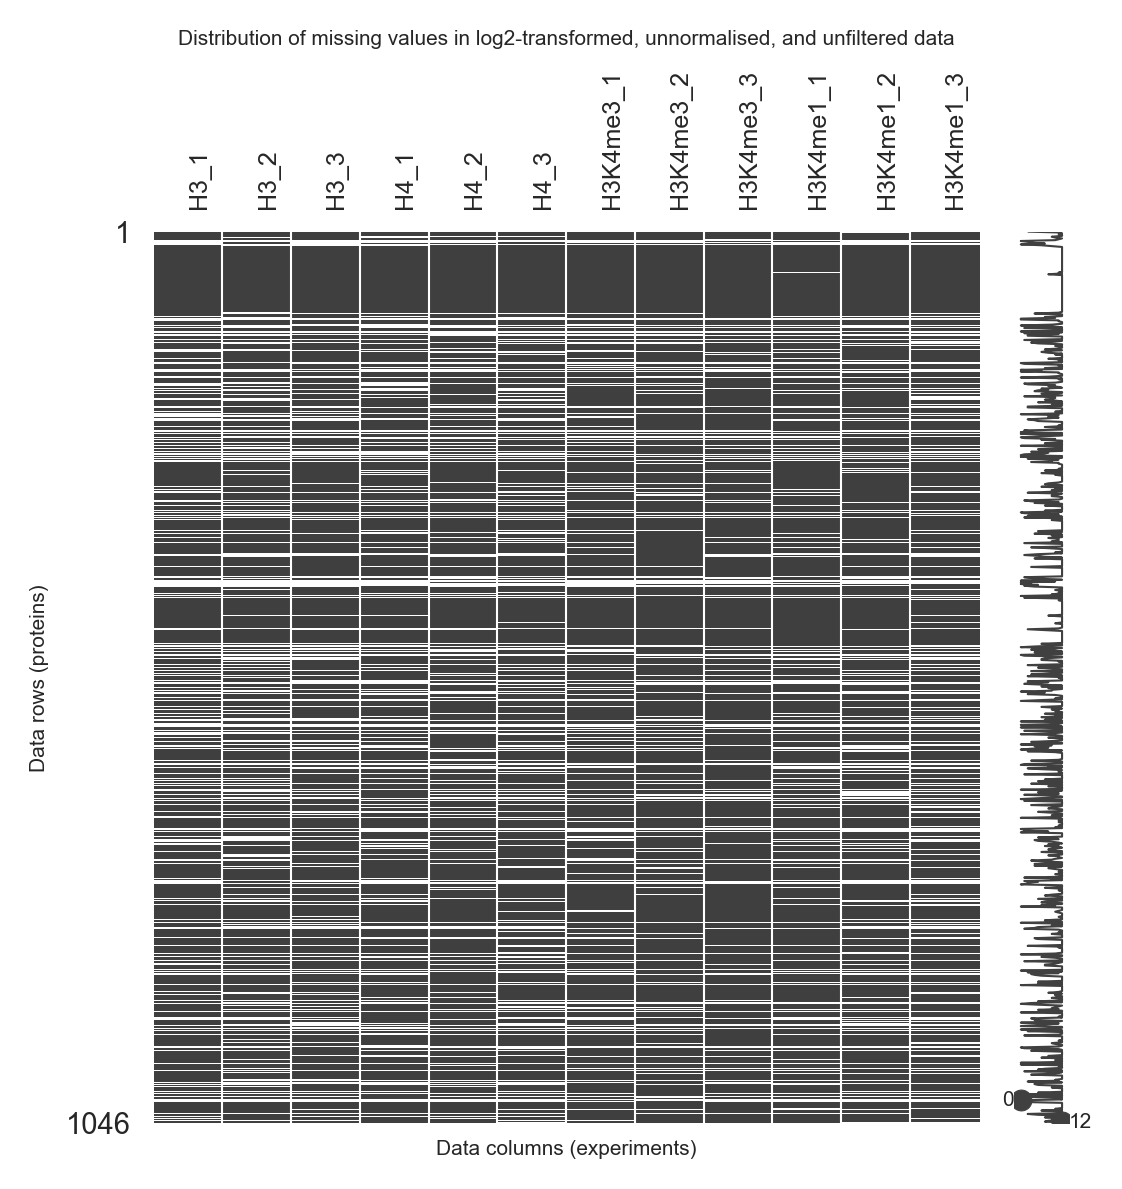

In [10]:
import missingno as msgno
msgno.matrix(data_numeric_log2, figsize=(20*FIVE_MM_IN_INCH, 20*FIVE_MM_IN_INCH), fontsize=6)

plt.title("Distribution of missing values in log2-transformed, unnormalised, and unfiltered data")
plt.xlabel("Data columns (experiments)")
plt.ylabel("Data rows (proteins)")
plt.xticks(rotation=90)

_fname = OUTPUT_DIRECTORY / '01-EDA-log2-transformed-unnormalised-unfiltered-missing-values.png'
_caption = """
Distribution of missing values in the log2-transformed, unnormalised, and unfiltered data. The heatmap above displays all 1046 proteins in the data in rows, and all experiments in columns. Dark values indicate the presence of a value, while white space indicates the absence of one. The sparkline on the right hand side counts the number of values per protein, which ranges from zero to 12 in this dataset.
"""
plt.savefig(_fname, bbox_inches='tight', dpi=DPI)
with open(str(_fname) + '.caption.md', 'w') as f:
    f.write(_caption)
    print(_caption)

### Normality

The analyses below will assume that the log2-transformed data is approximately normal. 

We can qualititatively verify this by plotting the data distributions.

We see that the fit is not perfect but is perhaps acceptable. 
We will therefore not worry about the normality of the data.

/usr/local/Caskroom/miniconda/base/envs/marcs-chip-ms-h3k4me1-h3k4me3/lib/python3.10/site-packages/seaborn/axisgrid.py:337: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)



Distribution of non-null values of log2-transformed, unnormalised, and unfiltered dataset. 
The rows facet the four experiment types, while the columns split the data per replicate.
The green distribution plot shows the histogram of observed log2 values in the data.
The black curve shows the corresponding normal distribution fit to the data, whose parameters are written in the top-right corner.
The black vertical line indicates the mean ($\mu$) estimate.



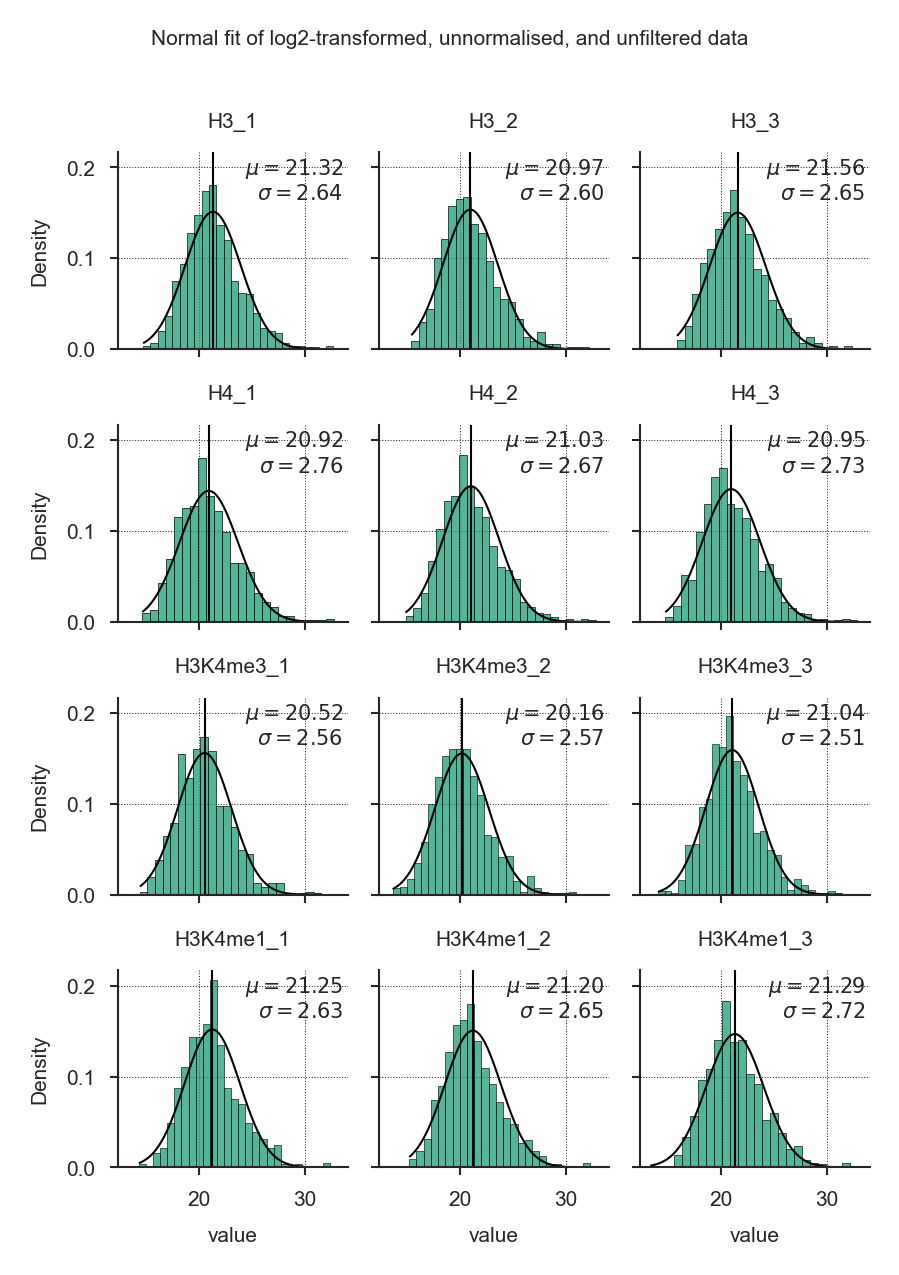

In [11]:
from scipy.stats import norm
def _plot_norm_fit(values, *args, color=None, **kwargs):
    """
    Fits a normal distribution to the data and plots its PDF
    """
    mu, std = norm.fit(values)

    min_ = values.min()
    max_ = values.max()
    
    ax = plt.gca()
    xs = np.linspace(min_, max_, 100)
    ys = norm.pdf(xs, mu, std)
    
    ax.plot(xs, ys, **kwargs, color='black', label='Normal fit')
    ax.axvline(mu, color='black')
    
    ax.text(
        0.98, 0.98, '\n'.join([r'$\mu = {:.2f}$'.format(mu),r'$\sigma = {:.2f}$'.format(std)]),
        ha='right', va='top', transform=ax.transAxes
    )
    
    

# Convert data to long format
_df = data_numeric_log2.copy()
_df = _df.stack(_df.columns.names)
_df.name = 'value'
_df = _df.reset_index()

# Plot the histograms and normal distribution fits
fgrid = sns.FacetGrid(col='Experiment_Replicate', col_wrap=3, col_order=data_numeric_log2.columns, data=_df, size=FIVE_MM_IN_INCH*5)
fgrid.map(sns.histplot, 'value', stat='density')
fgrid.map(_plot_norm_fit, 'value')
fgrid.set_titles('{col_name}')

plt.suptitle("Normal fit of log2-transformed, unnormalised, and unfiltered data", y=1.05)

_fname = OUTPUT_DIRECTORY / '01-EDA-log2-transformed-unnormalised-unfiltered-normal-fit.pdf'
_caption = """
Distribution of non-null values of log2-transformed, unnormalised, and unfiltered dataset. 
The rows facet the four experiment types, while the columns split the data per replicate.
The green distribution plot shows the histogram of observed log2 values in the data.
The black curve shows the corresponding normal distribution fit to the data, whose parameters are written in the top-right corner.
The black vertical line indicates the mean ($\mu$) estimate.
"""
plt.savefig(_fname, bbox_inches='tight', dpi=DPI)
with open(str(_fname) + '.caption.md', 'w') as f:
    f.write(_caption)
    print(_caption)

### PCA 

And finally the PCA of unnormalissed data


Principal Component embedding of log2-transformed, unnormalised, and unfiltered dataset, including only the rows which have no missing values.
The principal component 1 (PC1) is plotted on the X axis, while the PC2 is plotted on the Y. 
The explained variance ratio is highlighted in parentheses.

Note that the experiment types (colour, see legend on the right) do not cluster together as this data is unnormalised.



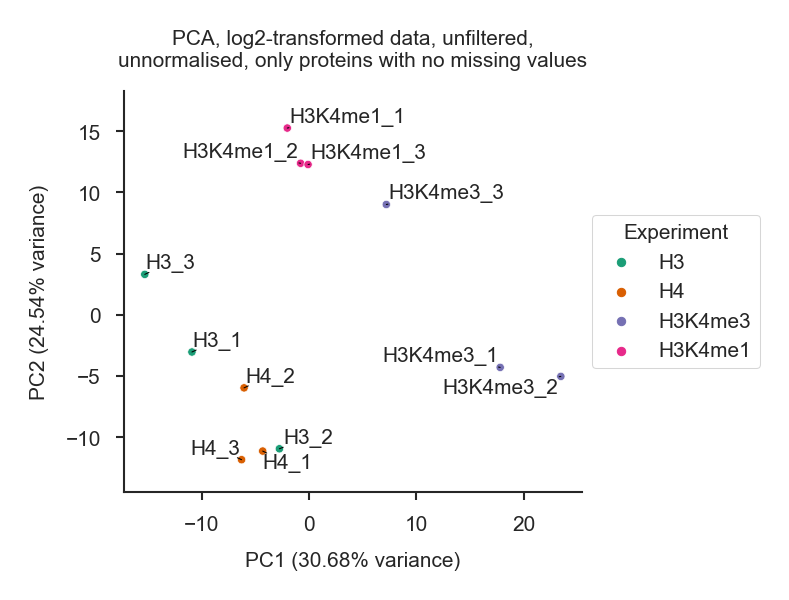

In [12]:
from adjustText import adjust_text
from sklearn.decomposition import PCA

pca = PCA(n_components=2)

# Note that we only look at the rows that are all not null:
projected = pca.fit_transform(data_numeric_log2.dropna(axis=0).T)

projected = pd.DataFrame(projected, index=data_numeric_log2.columns, columns=['PC1', 'PC2'])
explained_variance = pd.Series(pca.explained_variance_ratio_, index=projected.columns)

ax = plt.gca()

sns.scatterplot(x='PC1', y='PC2', hue='Experiment', data=projected.join(headers))

texts = []
for ix, row in projected.iterrows():
    texts.append(ax.text(row['PC1'], row['PC2'], ix, ha='center', va='center'))

xlim = ax.get_xlim()
ylim = ax.get_ylim()

# Increasing ylim helps place the H3K4me3 labels
ax.set_ylim(ylim[0]*1.1, ylim[1] * 1.1)

adjust_text(texts, projected['PC1'].values, projected['PC2'].values, arrowprops=dict(arrowstyle='-'))

ax.set_xlabel("PC1 ({:.2%} variance)".format(explained_variance.loc['PC1']))
ax.set_ylabel("PC2 ({:.2%} variance)".format(explained_variance.loc['PC2']))
ax.grid(False)
ax.set_title("PCA, log2-transformed data, unfiltered,\nunnormalised, only proteins with no missing values")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), title='Experiment')


_fname = OUTPUT_DIRECTORY / '01-EDA-log2-transformed-unnormalised-unfiltered-PCA.pdf'
_caption = """
Principal Component embedding of log2-transformed, unnormalised, and unfiltered dataset, including only the rows which have no missing values.
The principal component 1 (PC1) is plotted on the X axis, while the PC2 is plotted on the Y. 
The explained variance ratio is highlighted in parentheses.

Note that the experiment types (colour, see legend on the right) do not cluster together as this data is unnormalised.
"""
plt.savefig(_fname, bbox_inches='tight', dpi=DPI)
with open(str(_fname) + '.caption.md', 'w') as f:
    f.write(_caption)
    print(_caption)

## Normalisation

For normalisation of these intensities, Andrey suggests the use of Histones H4 and H2B, namely:

- `Histone H4 OS=Homo sapiens OX=9606 GN=H4C1 PE=1 SV=2`
- `Histone H2B type 1-C/E/F/G/I OS=Homo sapiens OX=9606 GN=H2BC4 PE=1 SV=4`

In our transformed data these correspond to indices `H4C1` and `H2BC4` (from the `GN=` annotation in the description)

In subsequent analyses I have found that using more than these two proteins performs a bit better.
Here's the list of all proteins with the wort `histone` in description, that we observe in our dataset:

In [13]:
data_metadata[data_metadata['Description'].str.lower().str.contains('histone')].sort_index()

# PSMs  # Peptides  # Unique Peptides Accession  Coverage [%]  \
Label                                                                      
H1-0           98           5                  5    P07305            27   
H1-1          188          10                  3    Q02539            31   
H1-10          47           5                  5    Q92522            23   
H1-5          278          12                  9    P16401            34   
H2AC20        295           7                  3    Q16777            59   
H2AC21        138           4                  2    Q8IUE6            52   
H2AW          278           7                  2    Q7L7L0            58   
H2AZ2         210           6                  4    Q71UI9            54   
H2BC4         964          15                  8    P62807            73   
H2BU1         814          10                  3    Q8N257            57   
H3-2          457          13                  3    Q5TEC6            58   
H4C1         1065          15                 15    P62805            59   
HDAC1          23           5                  5    Q13547            11   
HMGN1          86           7                  7    P05114            56   
HMGN2           4           2                  2    P05204            32   
KAT6A           9           5                  5    Q92794             2   
KAT7            8           3                  3    O95251             6   
MACROH2A1     406          17                 15    O75367            51   
MACROH2A2     181          16                 14    Q9P0M6            57   
PHF8            5           3                  2    Q9UPP1             3   
RBBP4          42           7                  2    Q09028            17   
RBBP7          39           8                  3    Q16576            23   
SAP18          12           3                  3    O00422            19   

                                                 Description       Gene  
Label                                                                    
H1-0       Histone H1.0 OS=Homo sapiens OX=9606 GN=H1-0 P...       H1-0  
H1-1       Histone H1.1 OS=Homo sapiens OX=9606 GN=H1-1 P...       H1-1  
H1-10      Histone H1.10 OS=Homo sapiens OX=9606 GN=H1-10...      H1-10  
H1-5       Histone H1.5 OS=Homo sapiens OX=9606 GN=H1-5 P...       H1-5  
H2AC20     Histone H2A type 2-C OS=Homo sapiens OX=9606 G...     H2AC20  
H2AC21     Histone H2A type 2-B OS=Homo sapiens OX=9606 G...     H2AC21  
H2AW       Histone H2A type 3 OS=Homo sapiens OX=9606 GN=...       H2AW  
H2AZ2      Histone H2A.V OS=Homo sapiens OX=9606 GN=H2AZ2...      H2AZ2  
H2BC4      Histone H2B type 1-C/E/F/G/I OS=Homo sapiens O...      H2BC4  
H2BU1      Histone H2B type 3-B OS=Homo sapiens OX=9606 G...      H2BU1  
H3-2       Histone HIST2H3PS2 OS=Homo sapiens OX=9606 GN=...       H3-2  
H4C1       Histone H4 OS=Homo sapiens OX=9606 GN=H4C1 PE=...       H4C1  
HDAC1      Histone deacetylase 1 OS=Homo sapiens OX=9606 ...      HDAC1  
HMGN1      Non-histone chromosomal protein HMG-14 OS=Homo...      HMGN1  
HMGN2      Non-histone chromosomal protein HMG-17 OS=Homo...      HMGN2  
KAT6A      Histone acetyltransferase KAT6A OS=Homo sapien...      KAT6A  
KAT7       Histone acetyltransferase KAT7 OS=Homo sapiens...       KAT7  
MACROH2A1  Core histone macro-H2A.1 OS=Homo sapiens OX=96...  MACROH2A1  
MACROH2A2  Core histone macro-H2A.2 OS=Homo sapiens OX=96...  MACROH2A2  
PHF8       Histone lysine demethylase PHF8 OS=Homo sapien...       PHF8  
RBBP4      Histone-binding protein RBBP4 OS=Homo sapiens ...      RBBP4  
RBBP7      Histone-binding protein RBBP7 OS=Homo sapiens ...      RBBP7  
SAP18      Histone deacetylase complex subunit SAP18 OS=H...      SAP18

Out of which the list `HISTONES` contains the set of core histone proteins and their variants

In [14]:
HISTONES = [
    'H2AC20', 
    'H2AC21', 
    'H2AW', 
    'H2AZ2', 
    'H2BC4',
    'H2BU1', 
    'H3-2', 
    'H4C1',
    'MACROH2A1', 
    'MACROH2A2'
]

# # Andrey suggests using these:
# NORMALISATION_PROTEINS = ['H4C1', 'H2BC4']

# I think perhaps it might be better to use the full collection of histone
# proteins instead:

NORMALISATION_PROTEINS = HISTONES

In [15]:
data_numeric_log2_histones = data_numeric_log2.loc[HISTONES]

In [16]:
data_numeric_log2_histones

Experiment_Replicate       H3_1       H3_2       H3_3       H4_1       H4_2  \
Label                                                                         
H2AC20                23.868026  23.581878  24.052757  23.886965  24.721894   
H2AC21                26.990903  27.346463  28.227990  27.467299  27.460546   
H2AW                  22.636653  22.526538  22.799367  22.828056  23.577282   
H2AZ2                 27.560936  27.052439  27.904829  27.940650  27.893452   
H2BC4                 32.073687  30.980693  32.136169  32.199801  32.095349   
H2BU1                 28.196541  27.625967  28.585255  28.446460  28.610910   
H3-2                  28.881372  28.326411  28.816868  28.835823  28.956387   
H4C1                  32.696155  32.225081  33.078298  32.807024  32.852358   
MACROH2A1             26.727165  25.996721  27.008867  26.827331  26.654992   
MACROH2A2             24.120026  23.584866  24.618128  24.359167  24.111399   

Experiment_Replicate       H4_3  H3K4me3_1  H3K4me3_2  H3K4me3_3  H3K4me1_1  \
Label                                                                         
H2AC20                24.636434  22.144510  20.641435  23.718491  23.610001   
H2AC21                27.473269  25.004669  25.129673  26.702265  27.299972   
H2AW                  23.739300  20.785081  19.937057  22.625721  22.284705   
H2AZ2                 27.789999  27.552673  26.859732  27.318096  27.321763   
H2BC4                 32.031985  30.789320  30.441673  30.772064  31.765862   
H2BU1                 28.438664  26.880351  26.413226  26.963313  27.491487   
H3-2                  28.441822  27.857877  27.440771  28.293155  28.599532   
H4C1                  32.886806  31.564237  30.964594  31.424174  32.268012   
MACROH2A1             26.821978  25.099306  24.384896  25.146207  26.033790   
MACROH2A2             24.145424  22.606825  22.357456  23.750444  23.431139   

Experiment_Replicate  H3K4me1_2  H3K4me1_3  
Label                                       
H2AC20                22.415764  23.559544  
H2AC21                27.671038  27.523113  
H2AW                  21.760985  22.012071  
H2AZ2                 27.311075  27.452810  
H2BC4                 31.648177  31.698302  
H2BU1                 27.617117  27.593277  
H3-2                  28.661686  28.809814  
H4C1                  32.197193  32.151775  
MACROH2A1             26.153324  26.214573  
MACROH2A2             24.047592  23.579026


Boxplot showing the unnormalised log2 data for histone proteins only.
The proteins are plotted on the Y axis, and the experiments on the X.

Proteins selected as normalisation factors are highlighted in red.



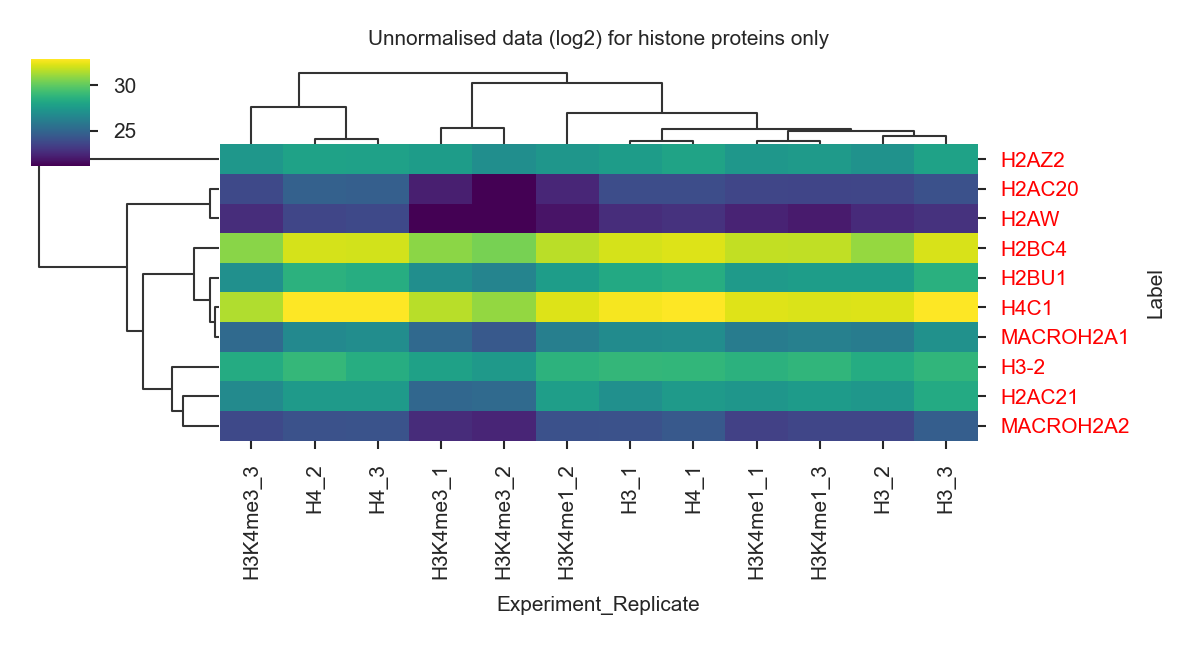

In [17]:
_cmap = sns.clustermap(
    data_numeric_log2_histones,
    cmap='viridis', robust=True, 
    figsize=(20*FIVE_MM_IN_INCH, 10*FIVE_MM_IN_INCH),
    metric='correlation',
    method='complete',
)
_cmap.ax_col_dendrogram.set_title("Unnormalised data (log2) for histone proteins only")

for tick in _cmap.ax_heatmap.get_yticklabels():
    tick_text = tick.get_text()
    if tick_text in NORMALISATION_PROTEINS:
        tick.set_color('red')
        
_fname = OUTPUT_DIRECTORY / '02-normalisation-histones-heatmap-unnormalised.pdf'
_caption = """
Boxplot showing the unnormalised log2 data for histone proteins only.
The proteins are plotted on the Y axis, and the experiments on the X.

Proteins selected as normalisation factors are highlighted in red.
"""
plt.savefig(_fname, bbox_inches='tight', dpi=DPI)
with open(str(_fname) + '.caption.md', 'w') as f:
    f.write(_caption)
    print(_caption)

Mark `NORMALISATION_PROTEINS` as "Used for normalisation"

In [18]:
comments_norm = pd.Series(None, dtype=object, index=data_numeric_log2.index)
comments_norm.loc[NORMALISATION_PROTEINS] = 'Used for normalisation'

Andrey used the sum of the (natural scale) intensities of these proteins as a normalisation factor;
we tried working on a similar note and use the mean of the log2-transformed intensities for such histone proteins,
however taking a median of M-offsets below seems to be a more robust estimator, the M-offsets can obtained by subtracting the row-wise mean from the data:

In [19]:
data_numeric_log2.sub(data_numeric_log2.mean(axis=1), axis=0)

Experiment_Replicate      H3_1      H3_2      H3_3      H4_1      H4_2  \
Label                                                                    
GBE1                       NaN       NaN       NaN       NaN -0.023897   
EFTUD2               -0.052896 -0.596434 -0.723658 -1.137478  1.351536   
YWHAB                -0.669287 -0.198373  1.200945 -0.789783  0.579016   
YWHAE                -0.091277 -0.926786       NaN -0.210777 -0.200777   
YWHAH                 0.128956  0.740520  2.175580 -0.731423  0.053010   
...                        ...       ...       ...       ...       ...   
ZNF800                0.340975 -0.335912 -0.694951 -2.542378 -0.626720   
ZRANB2               -0.451186  0.097227       NaN       NaN  0.135539   
ZFR                        NaN       NaN       NaN -0.920369 -1.168240   
AZGP1                -0.091596  0.041325  0.932542 -0.750126 -0.329965   
ZYX                  -0.765228 -0.385260  0.705155 -0.934918  0.979704   

Experiment_Replicate      H4_3  H3K4me3_1  H3K4me3_2  H3K4me3_3  H3K4me1_1  \
Label                                                                        
GBE1                       NaN        NaN   0.023897        NaN        NaN   
EFTUD2               -2.668573   1.119853   0.187030   1.094897   2.008826   
YWHAB                -0.804835  -0.364020   0.078823   1.124433   1.040866   
YWHAE                 0.196132  -0.363354  -0.038313   1.028328   0.348758   
YWHAH                -0.607493  -0.446710  -0.342799   0.218806  -1.142710   
...                        ...        ...        ...        ...        ...   
ZNF800               -1.141516   1.191631   0.349122   1.471630   0.723212   
ZRANB2               -0.061174  -1.049289  -0.728752   1.247179   0.810456   
ZFR                        NaN        NaN  -0.137336   1.361602   1.029128   
AZGP1                -0.461168  -0.792605  -0.512868   0.125730   0.336329   
ZYX                        NaN  -0.627065   0.191328   0.579164   0.257120   

Experiment_Replicate  H3K4me1_2  H3K4me1_3  
Label                                       
GBE1                        NaN        NaN  
EFTUD2                      NaN  -0.583102  
YWHAB                  0.269934  -1.467717  
YWHAE                 -0.039468   0.297534  
YWHAH                 -0.639014   0.593277  
...                         ...        ...  
ZNF800                 0.435852   0.829054  
ZRANB2                      NaN        NaN  
ZFR                    0.065580  -0.230365  
AZGP1                  0.664192   0.838210  
ZYX                         NaN        NaN  

[1046 rows x 12 columns]

### Normalisation factors calculation

We will now compute the MA statistics from the unnormalised data.

MA statistics are simply row-wise averages of the data (`avg` column, the `A` part)
And the log2 offsets from this average (`log2_diff` column, the `M` part)

In [20]:
data_numeric_log2_row_averages = data_numeric_log2.mean(axis=1)
data_numeric_log2_row_averages.name = 'avg'
data_numeric_log2_row_averages

Label
GBE1      15.954218
EFTUD2    17.997349
YWHAB     18.584910
YWHAE     18.484909
YWHAH     26.755395
            ...    
ZNF800    20.191179
ZRANB2    17.498717
ZFR       19.437602
AZGP1     22.849524
ZYX       18.797619
Name: avg, Length: 1046, dtype: float64

In [21]:
data_numeric_log2

Experiment_Replicate       H3_1       H3_2       H3_3       H4_1       H4_2  \
Label                                                                         
GBE1                        NaN        NaN        NaN        NaN  15.930321   
EFTUD2                17.944452  17.400914  17.273690  16.859870  19.348884   
YWHAB                 17.915623  18.386536  19.785854  17.795126  19.163926   
YWHAE                 18.393631  17.558123        NaN  18.274132  18.284131   
YWHAH                 26.884352  27.495915  28.930976  26.023972  26.808406   
...                         ...        ...        ...        ...        ...   
ZNF800                20.532154  19.855267  19.496228  17.648800  19.564459   
ZRANB2                17.047531  17.595944        NaN        NaN  17.634256   
ZFR                         NaN        NaN        NaN  18.517233  18.269363   
AZGP1                 22.757928  22.890848  23.782065  22.099397  22.519558   
ZYX                   18.032391  18.412359  19.502774  17.862702  19.777323   

Experiment_Replicate       H4_3  H3K4me3_1  H3K4me3_2  H3K4me3_3  H3K4me1_1  \
Label                                                                         
GBE1                        NaN        NaN  15.978116        NaN        NaN   
EFTUD2                15.328775  19.117202  18.184379  19.092246  20.006174   
YWHAB                 17.780075  18.220890  18.663732  19.709343  19.625775   
YWHAE                 18.681041  18.121555  18.446595  19.513236  18.833667   
YWHAH                 26.147902  26.308685  26.412596  26.974202  25.612686   
...                         ...        ...        ...        ...        ...   
ZNF800                19.049663  21.382810  20.540300  21.662809  20.914391   
ZRANB2                17.437543  16.449428  16.769965  18.745896  18.309174   
ZFR                         NaN        NaN  19.300266  20.799204  20.466730   
AZGP1                 22.388356  22.056919  22.336655  22.975253  23.185852   
ZYX                         NaN  18.170555  18.988947  19.376784  19.054739   

Experiment_Replicate  H3K4me1_2  H3K4me1_3  
Label                                       
GBE1                        NaN        NaN  
EFTUD2                      NaN  17.414247  
YWHAB                 18.854844  17.117192  
YWHAE                 18.445441  18.782443  
YWHAH                 26.116381  27.348672  
...                         ...        ...  
ZNF800                20.627030  21.020233  
ZRANB2                      NaN        NaN  
ZFR                   19.503182  19.207237  
AZGP1                 23.513716  23.687734  
ZYX                         NaN        NaN  

[1046 rows x 12 columns]

In [22]:
data_numeric_log2_diffs = data_numeric_log2.sub(data_numeric_log2_row_averages, axis=0)
data_numeric_log2_diffs

Experiment_Replicate      H3_1      H3_2      H3_3      H4_1      H4_2  \
Label                                                                    
GBE1                       NaN       NaN       NaN       NaN -0.023897   
EFTUD2               -0.052896 -0.596434 -0.723658 -1.137478  1.351536   
YWHAB                -0.669287 -0.198373  1.200945 -0.789783  0.579016   
YWHAE                -0.091277 -0.926786       NaN -0.210777 -0.200777   
YWHAH                 0.128956  0.740520  2.175580 -0.731423  0.053010   
...                        ...       ...       ...       ...       ...   
ZNF800                0.340975 -0.335912 -0.694951 -2.542378 -0.626720   
ZRANB2               -0.451186  0.097227       NaN       NaN  0.135539   
ZFR                        NaN       NaN       NaN -0.920369 -1.168240   
AZGP1                -0.091596  0.041325  0.932542 -0.750126 -0.329965   
ZYX                  -0.765228 -0.385260  0.705155 -0.934918  0.979704   

Experiment_Replicate      H4_3  H3K4me3_1  H3K4me3_2  H3K4me3_3  H3K4me1_1  \
Label                                                                        
GBE1                       NaN        NaN   0.023897        NaN        NaN   
EFTUD2               -2.668573   1.119853   0.187030   1.094897   2.008826   
YWHAB                -0.804835  -0.364020   0.078823   1.124433   1.040866   
YWHAE                 0.196132  -0.363354  -0.038313   1.028328   0.348758   
YWHAH                -0.607493  -0.446710  -0.342799   0.218806  -1.142710   
...                        ...        ...        ...        ...        ...   
ZNF800               -1.141516   1.191631   0.349122   1.471630   0.723212   
ZRANB2               -0.061174  -1.049289  -0.728752   1.247179   0.810456   
ZFR                        NaN        NaN  -0.137336   1.361602   1.029128   
AZGP1                -0.461168  -0.792605  -0.512868   0.125730   0.336329   
ZYX                        NaN  -0.627065   0.191328   0.579164   0.257120   

Experiment_Replicate  H3K4me1_2  H3K4me1_3  
Label                                       
GBE1                        NaN        NaN  
EFTUD2                      NaN  -0.583102  
YWHAB                  0.269934  -1.467717  
YWHAE                 -0.039468   0.297534  
YWHAH                 -0.639014   0.593277  
...                         ...        ...  
ZNF800                 0.435852   0.829054  
ZRANB2                      NaN        NaN  
ZFR                    0.065580  -0.230365  
AZGP1                  0.664192   0.838210  
ZYX                         NaN        NaN  

[1046 rows x 12 columns]

In [23]:
data_numeric_log2_ma = data_numeric_log2_diffs.stack()
data_numeric_log2_ma.name = 'log2_diff'
data_numeric_log2_ma = data_numeric_log2_ma.reset_index().join(data_numeric_log2_row_averages, on='Label')
data_numeric_log2_ma

Label Experiment_Replicate  log2_diff        avg
0       GBE1                 H4_2  -0.023897  15.954218
1       GBE1            H3K4me3_2   0.023897  15.954218
2     EFTUD2                 H3_1  -0.052896  17.997349
3     EFTUD2                 H3_2  -0.596434  17.997349
4     EFTUD2                 H3_3  -0.723658  17.997349
...      ...                  ...        ...        ...
9886     ZYX                 H4_2   0.979704  18.797619
9887     ZYX            H3K4me3_1  -0.627065  18.797619
9888     ZYX            H3K4me3_2   0.191328  18.797619
9889     ZYX            H3K4me3_3   0.579164  18.797619
9890     ZYX            H3K4me1_1   0.257120  18.797619

[9891 rows x 4 columns]

We will now compute the normalisation factors from the `NORMALISATION_PROTEINS`.

Andrey uses the sum of natural scale intensities, 
I have tried using the median of intensities (see below)

But I now think that it is more appropriate to take the median of the M offsets of the `NORMALISATION_PROTEINS`

In [24]:
# Andrey's normfactors
# normalisation_factors = (data_numeric_log2.loc[NORMALISATION_PROTEINS].apply(lambda x: np.power(2,x)).sum()).apply(np.log2)

# My normfactors (attempt):
# normalisation_factors = data_numeric_log2.loc[NORMALISATION_PROTEINS].median()

# Get the normfactors from MA offsets
_ma_data_for_normalisation_proteins = data_numeric_log2_ma[
    data_numeric_log2_ma['Label'].isin(NORMALISATION_PROTEINS)
]
print(_ma_data_for_normalisation_proteins.shape)
assert set(_ma_data_for_normalisation_proteins['Label'].unique()) == set(NORMALISATION_PROTEINS)


normalisation_factors = _ma_data_for_normalisation_proteins.groupby('Experiment_Replicate')['log2_diff'].median()

normalisation_factors

(120, 4)


Experiment_Replicate
H3K4me1_1    0.000170
H3K4me1_2    0.000889
H3K4me1_3    0.040875
H3K4me3_1   -0.923993
H3K4me3_2   -1.346912
H3K4me3_3   -0.261404
H3_1         0.415291
H3_2        -0.102478
H3_3         0.734135
H4_1         0.541352
H4_2         0.554244
H4_3         0.553196
Name: log2_diff, dtype: float64

In [25]:
_ma_data_for_normalisation_proteins

Label Experiment_Replicate  log2_diff        avg
2345  MACROH2A1                 H3_1   0.638069  26.089096
2346  MACROH2A1                 H3_2  -0.092375  26.089096
2347  MACROH2A1                 H3_3   0.919772  26.089096
2348  MACROH2A1                 H4_1   0.738235  26.089096
2349  MACROH2A1                 H4_2   0.565896  26.089096
...         ...                  ...        ...        ...
4691       H3-2            H3K4me3_2  -1.052689  28.493460
4692       H3-2            H3K4me3_3  -0.200305  28.493460
4693       H3-2            H3K4me1_1   0.106072  28.493460
4694       H3-2            H3K4me1_2   0.168226  28.493460
4695       H3-2            H3K4me1_3   0.316354  28.493460

[120 rows x 4 columns]

### Plots (Before)

#### MA

To illustrate the normalisation behaviour it is helpful to make some MA plots:

/usr/local/Caskroom/miniconda/base/envs/marcs-chip-ms-h3k4me1-h3k4me3/lib/python3.10/site-packages/seaborn/axisgrid.py:337: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


(10, 4)
(10, 4)
(10, 4)
(10, 4)
(10, 4)
(10, 4)
(10, 4)
(10, 4)
(10, 4)
(10, 4)
(10, 4)
(10, 4)

MA-like plot for log2-transformed, unnormalised and unfiltered data.

X axis plots mean(log2_intensity) across data rows (proteins). X axis is the same in every plot.
Y axis plots log2_intensity - mean(log2_intensity) offsets for individual samples

Histone proteins are highlighted in green.
Red line indicates the normalisation factor estimate.



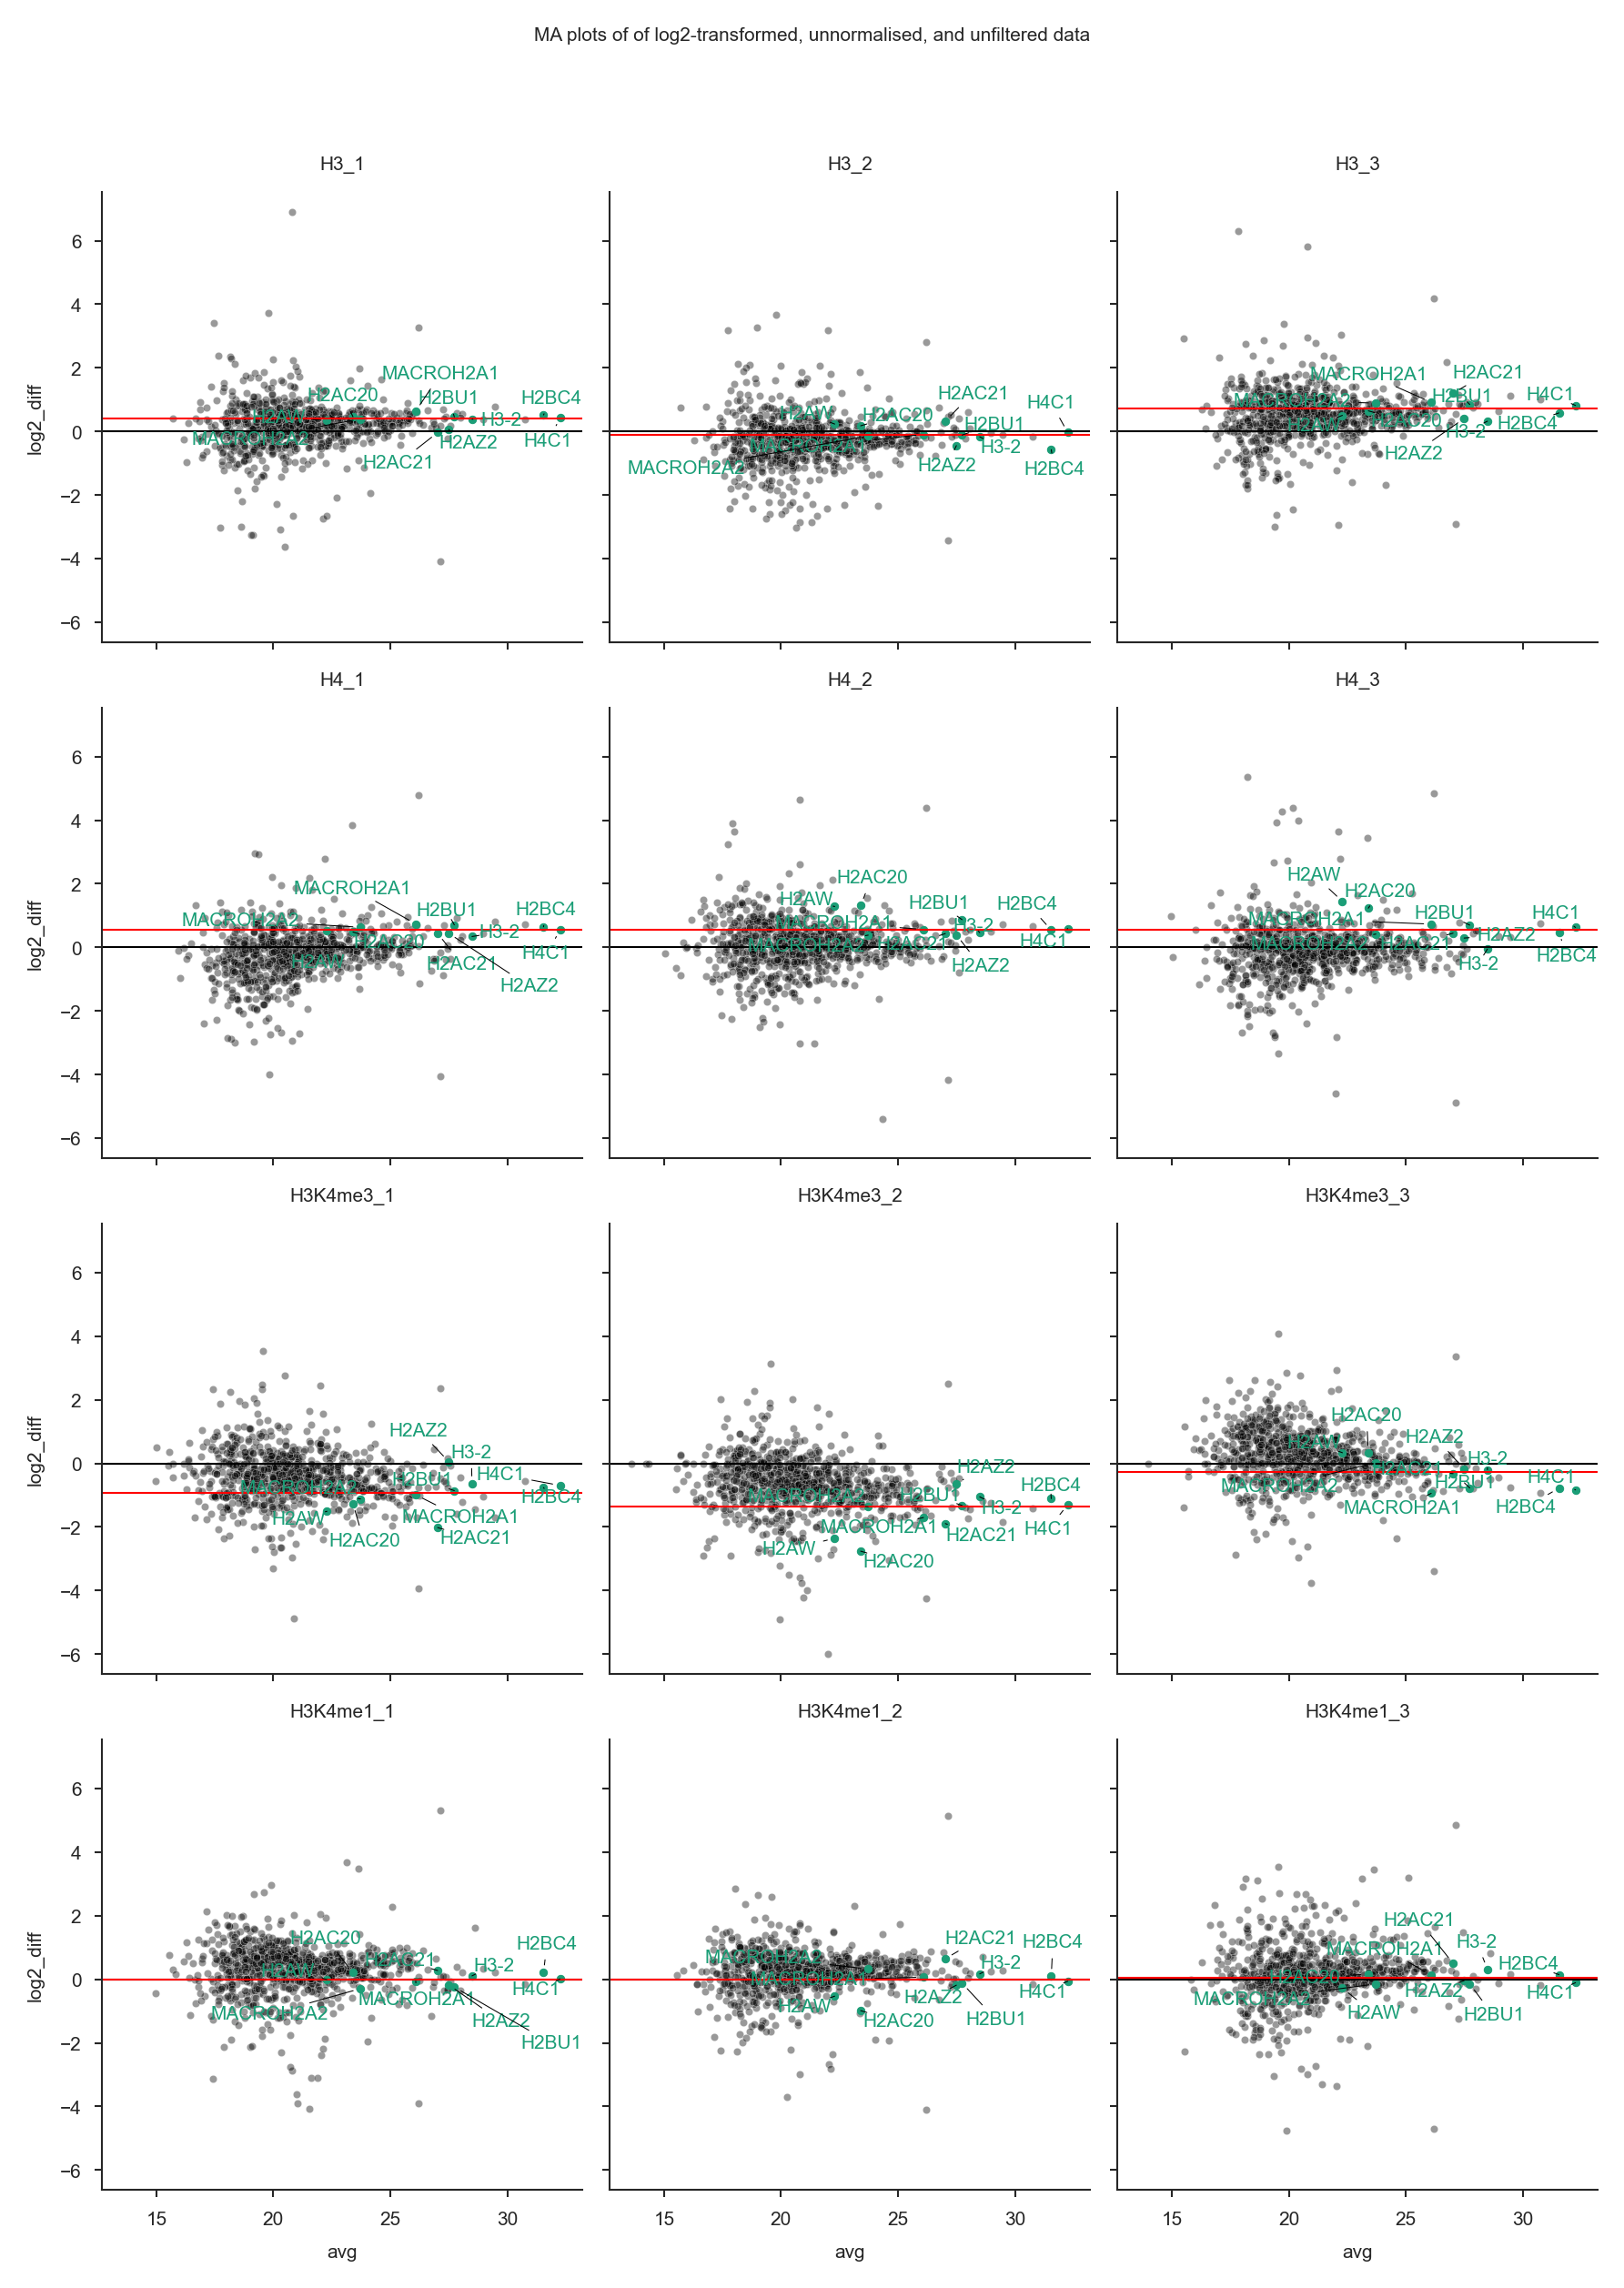

In [26]:
from adjustText import adjust_text
def annotate_histones(x, y, *, color=None, data=None):
    data_histones = data[data['Label'].isin(HISTONES)]
    ax = plt.gca()
    
    print(data_histones.shape)
    ax.scatter(data_histones[x], data_histones[y], color=color)
    
    texts = []
    for __, row in data_histones.iterrows():
        texts.append(ax.text(row[x], row[y], row['Label'], color=color))
        
    adjust_text(texts, arrowprops=dict(arrowstyle='-'), ax=ax)
    
def add_horizontal_line(*args, color=None, data=None):
    ax = plt.gca()
    ax.axhline(0, linestyle='-',color='black', zorder=1)

fgrid = sns.FacetGrid(col='Experiment_Replicate', col_wrap=3,
                      size=FIVE_MM_IN_INCH*10,
                      col_order=data_numeric_log2.columns, data=data_numeric_log2_ma)
fgrid.map(sns.scatterplot, 'avg', 'log2_diff', alpha=.4, color='black')
fgrid.map_dataframe(annotate_histones, 'avg', 'log2_diff')
fgrid.map_dataframe(add_horizontal_line)
fgrid.set_titles('{col_name}')

for experiment, ax in fgrid.axes_dict.items():
    ax.axhline(normalisation_factors.loc[experiment], color='r', linestyle='-')
    ax.grid(False)

plt.suptitle("MA plots of of log2-transformed, unnormalised, and unfiltered data", y=1.05)

_fname = OUTPUT_DIRECTORY / '02-normalisation-log2-transformed-unnormalised-unfiltered-ma-plot.pdf'
_caption = """
MA-like plot for log2-transformed, unnormalised and unfiltered data.

X axis plots mean(log2_intensity) across data rows (proteins). X axis is the same in every plot.
Y axis plots log2_intensity - mean(log2_intensity) offsets for individual samples

Histone proteins are highlighted in green.
Red line indicates the normalisation factor estimate.
"""
plt.savefig(_fname, bbox_inches='tight', dpi=DPI)
with open(str(_fname) + '.caption.md', 'w') as f:
    f.write(_caption)
    print(_caption)

#### Boxplot

Alternatively, we can plot all of this in a boxplot format:


Boxplot showing the distribution of signal intensities for non-histone proteins (green), and the histone proteins (orange), prior to normalisation.
The intensity is plotted on the X axis, while the samples are facetted on the Y. The outliers ("fliers") are hidden.

Black line shows the estimated normalisation offsets centred around the mean of normalisation proteins.



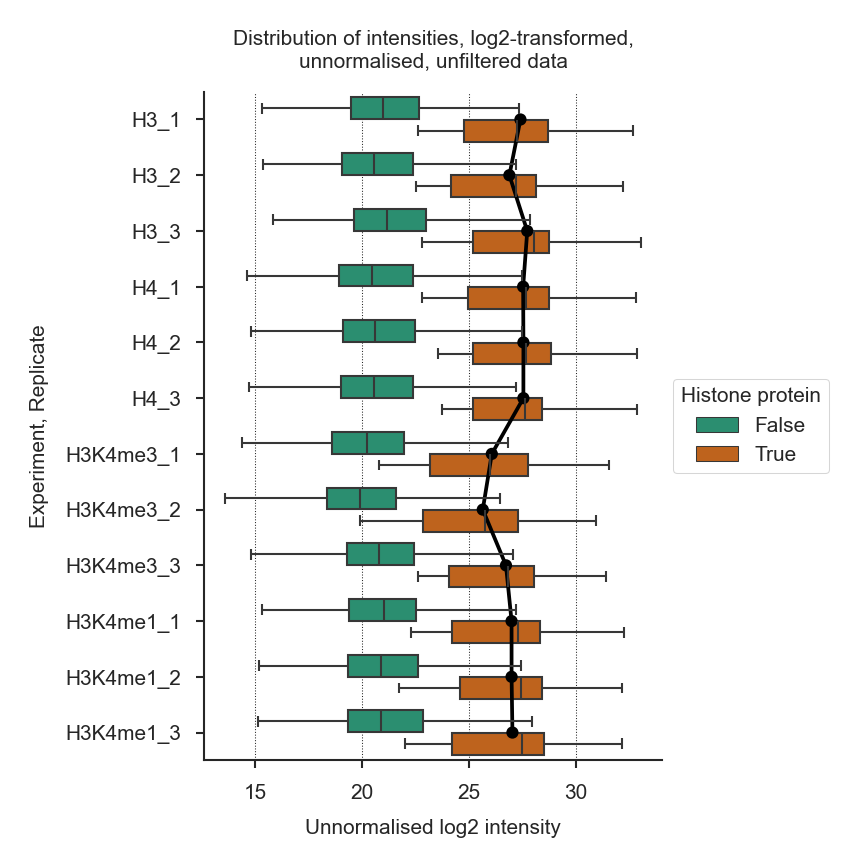

In [27]:
_df = data_numeric_log2.stack(list(data_numeric_log2.columns.names)).copy()
_df.name = 'log2_intensity_unnormalised'
_df = _df.reset_index()

_df['is_histone'] = False
_df.loc[_df['Label'].isin(HISTONES), 'is_histone'] = True

_df_cov = pd.DataFrame(
    # The + below recentres the normalisation factors around the mean of normalisation proteins
    {'normalisation_factors': normalisation_factors + data_numeric_log2.loc[NORMALISATION_PROTEINS].mean(axis=1).mean()}, 
)

fig = plt.figure(figsize=(10*FIVE_MM_IN_INCH, 15*FIVE_MM_IN_INCH))
ax = plt.gca()

sns.pointplot(
    y='Experiment_Replicate', x='normalisation_factors', 
    data=_df_cov.reset_index(),
    order=data_numeric_log2.columns,
    marker='.',
    color='black',
    label="Estimated covariates",
)

sns.boxplot(
    y='Experiment_Replicate', x='log2_intensity_unnormalised', 
    data=_df, hue='is_histone', showfliers=False,
    order=data_numeric_log2.columns,
)


ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), title="Histone protein")
ax.set_xlabel("Unnormalised log2 intensity")
ax.set_ylabel("Experiment, Replicate")
ax.set_title("Distribution of intensities, log2-transformed,\nunnormalised, unfiltered data")

_fname = OUTPUT_DIRECTORY / '02-normalisation-boxplot.pdf'
_caption = """
Boxplot showing the distribution of signal intensities for non-histone proteins (green), and the histone proteins (orange), prior to normalisation.
The intensity is plotted on the X axis, while the samples are facetted on the Y. The outliers ("fliers") are hidden.

Black line shows the estimated normalisation offsets centred around the mean of normalisation proteins.
"""
plt.savefig(_fname, bbox_inches='tight', dpi=DPI)
with open(str(_fname) + '.caption.md', 'w') as f:
    f.write(_caption)
    print(_caption)

### The bit where normalisation is performed

To perform the normalisation we simply subtract the normalisation factors from the dataset.

Note that as we are using (zero-centred) offsets for the normalisation, the intuitive meaning of the normalised intensities stays more or less the same.

In [28]:
data_numeric_log2_normalised = data_numeric_log2 - normalisation_factors
# In the row below we need to make sure column order stays the same
data_numeric_log2_normalised = data_numeric_log2_normalised[data_numeric_log2.columns]

In [29]:
from numpy.testing import assert_array_equal

# The minus operator above works columnwise, we can confirm this
for col in data_numeric_log2_normalised:
    assert_array_equal(data_numeric_log2_normalised[col], data_numeric_log2[col] - normalisation_factors.loc[col])

The normalisation has the effect of making the normalisation protein M-offsets constant
(though not necessarily zero, as median is used, not mean):

In [30]:
data_numeric_log2_normalised.sub(data_numeric_log2_normalised.mean(axis=1), axis=0).loc[NORMALISATION_PROTEINS]

Experiment_Replicate      H3_1      H3_2      H3_3      H4_1      H4_2  \
Label                                                                    
H2AC20                0.066707  0.298328 -0.067406 -0.040415  0.781622   
H2AC21               -0.432041  0.441288  0.486202 -0.081706 -0.101351   
H2AW                 -0.054259  0.353395 -0.210389  0.011084  0.747417   
H2AZ2                -0.333779 -0.324507 -0.308730 -0.080126 -0.140216   
H2BC4                 0.122753 -0.452473 -0.133609  0.122807  0.005462   
H2BU1                 0.059817  0.007011  0.129687  0.183674  0.335233   
H3-2                 -0.010264 -0.047457 -0.393613 -0.181875 -0.074204   
H4C1                  0.038336  0.085031  0.101634  0.023144  0.055585   
MACROH2A1             0.239892  0.027217  0.202750  0.213997  0.028766   
MACROH2A2            -0.004108 -0.021500  0.175149  0.108972 -0.151689   

Experiment_Replicate      H4_3  H3K4me3_1  H3K4me3_2  H3K4me3_3  H3K4me1_1  \
Label                                                                        
H2AC20                0.697211  -0.317525  -1.397682   0.593867   0.223803   
H2AC21               -0.087580  -1.078991  -0.531068  -0.043984   0.292150   
H2AW                  0.910483  -0.566547  -0.991652   0.611503   0.008914   
H2AZ2                -0.242621   0.997242   0.727220   0.100075  -0.157831   
H2BC4                -0.056854   0.177670   0.252941  -0.502175   0.230049   
H2BU1                 0.164034   0.082911   0.038704  -0.496717  -0.230117   
H3-2                 -0.587720   0.305524   0.311337   0.078212   0.123016   
H4C1                  0.091082   0.245702   0.068978  -0.556951   0.025314   
MACROH2A1             0.196800  -0.048683  -0.340175  -0.664371  -0.038362   
MACROH2A2            -0.116616  -0.178026  -0.004477   0.303004  -0.277875   

Experiment_Replicate  H3K4me1_2  H3K4me1_3  
Label                                       
H2AC20                -0.971153   0.132642  
H2AC21                 0.662496   0.474585  
H2AW                  -0.515525  -0.304424  
H2AZ2                 -0.169239  -0.067489  
H2BC4                  0.111645   0.121784  
H2BU1                 -0.105206  -0.169031  
H3-2                   0.184451   0.292593  
H4C1                  -0.046225  -0.131629  
MACROH2A1              0.080453   0.101717  
MACROH2A2              0.337859  -0.170692

In [31]:
data_numeric_log2_normalised.sub(data_numeric_log2_normalised.mean(axis=1), axis=0).loc[NORMALISATION_PROTEINS].median()

Experiment_Replicate
H3_1         0.017114
H3_2         0.017114
H3_3         0.017114
H4_1         0.017114
H4_2         0.017114
H4_3         0.017114
H3K4me3_1    0.017114
H3K4me3_2    0.017114
H3K4me3_3    0.017114
H3K4me1_1    0.017114
H3K4me1_2    0.017114
H3K4me1_3    0.017114
dtype: float64

### Plots (After)

Let's see whether the normalisation improved things

#### Boxplot


Boxplot showing the distribution of signal intensities for non-histone proteins (green), and the histone proteins (orange), after  normalisation by the mean of histone protein intensities.
The intensity is plotted on the X axis, while the samples are facetted on the Y. The outliers ("fliers") are hidden.



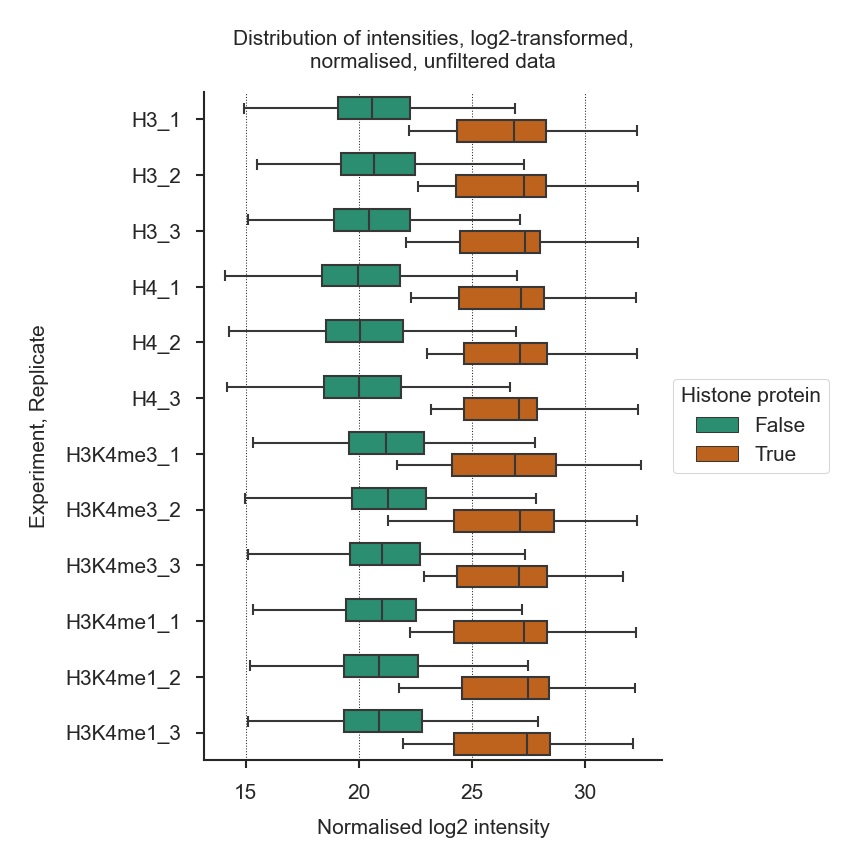

In [32]:
_df = data_numeric_log2_normalised.stack(list(data_numeric_log2.columns.names)).copy()
_df.name = 'log2_intensity_normalised'
_df = _df.reset_index()

_df['is_histone'] = False
_df.loc[_df['Label'].isin(HISTONES), 'is_histone'] = True


fig = plt.figure(figsize=(10*FIVE_MM_IN_INCH, 15*FIVE_MM_IN_INCH))
ax = plt.gca()

sns.boxplot(
    y='Experiment_Replicate', x='log2_intensity_normalised', 
    data=_df, hue='is_histone', showfliers=False,
    order=data_numeric_log2.columns,
)


ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), title="Histone protein")
ax.set_xlabel("Normalised log2 intensity")
ax.set_ylabel("Experiment, Replicate")
ax.set_title("Distribution of intensities, log2-transformed,\nnormalised, unfiltered data")

_fname = OUTPUT_DIRECTORY / '02-normalisation-boxplot-post-normalisation.pdf'
_caption = """
Boxplot showing the distribution of signal intensities for non-histone proteins (green), and the histone proteins (orange), after  normalisation by the mean of histone protein intensities.
The intensity is plotted on the X axis, while the samples are facetted on the Y. The outliers ("fliers") are hidden.
"""
plt.savefig(_fname, bbox_inches='tight', dpi=DPI)
with open(str(_fname) + '.caption.md', 'w') as f:
    f.write(_caption)
    print(_caption)

#### Histone heatmap

Let's replot histones after normalisation


Boxplot showing the unnormalised log2 data for histone proteins only.
The proteins are plotted on the Y axis, and the experiments on the X.

Proteins selected as normalisation factors are highlighted in red.



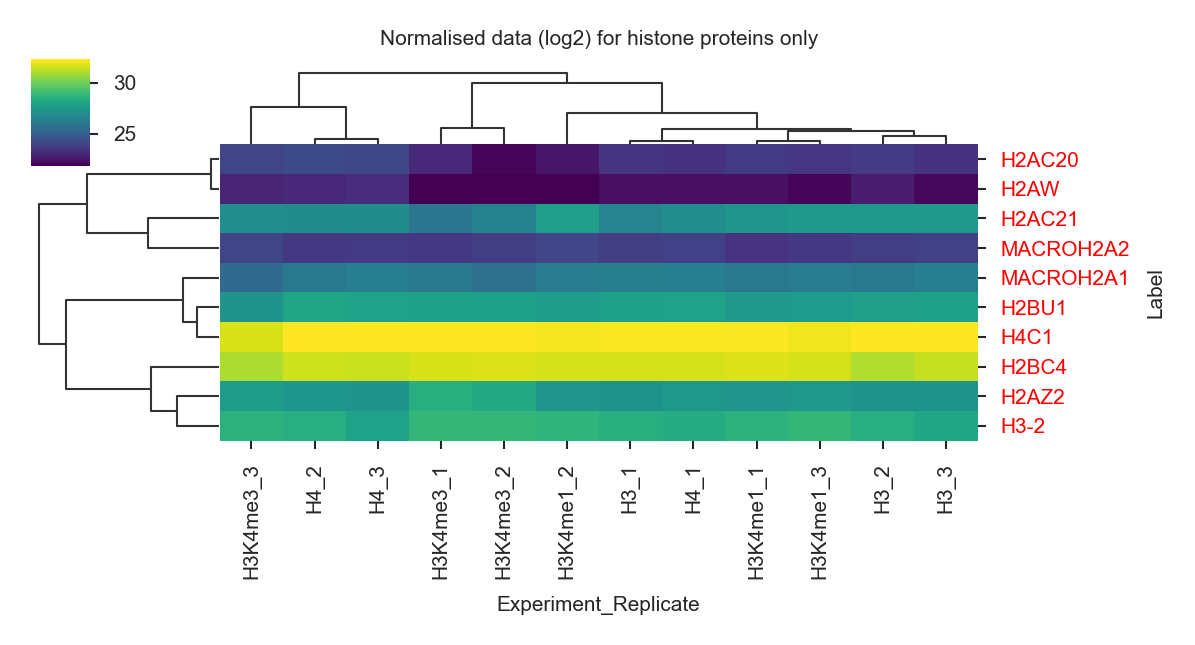

In [33]:
_cmap = sns.clustermap(
    data_numeric_log2_normalised.loc[HISTONES],
    cmap='viridis', robust=True, 
    figsize=(20*FIVE_MM_IN_INCH, 10*FIVE_MM_IN_INCH),
    metric='correlation',
    method='complete',
)
_cmap.ax_col_dendrogram.set_title("Normalised data (log2) for histone proteins only")

for tick in _cmap.ax_heatmap.get_yticklabels():
    tick_text = tick.get_text()
    if tick_text in NORMALISATION_PROTEINS:
        tick.set_color('red')
        
_fname = OUTPUT_DIRECTORY / '02-normalisation-histones-heatmap-post-normalisation.pdf'
_caption = """
Boxplot showing the unnormalised log2 data for histone proteins only.
The proteins are plotted on the Y axis, and the experiments on the X.

Proteins selected as normalisation factors are highlighted in red.
"""
plt.savefig(_fname, bbox_inches='tight', dpi=DPI)
with open(str(_fname) + '.caption.md', 'w') as f:
    f.write(_caption)
    print(_caption)

#### MA

And the MA plot

In [34]:
data_numeric_log2_normalised_row_averages = data_numeric_log2_normalised.mean(axis=1)
data_numeric_log2_normalised_row_averages.name = 'avg'
data_numeric_log2_normalised_row_averages

Label
GBE1      16.350552
EFTUD2    17.978760
YWHAB     18.567796
YWHAE     18.532978
YWHAH     26.738282
            ...    
ZNF800    20.174065
ZRANB2    17.637703
ZFR       19.504857
AZGP1     22.832410
ZYX       18.840907
Name: avg, Length: 1046, dtype: float64

In [35]:
data_numeric_log2_normalised_diffs = data_numeric_log2_normalised.sub(data_numeric_log2_normalised_row_averages, axis=0)

In [36]:
data_numeric_log2_normalised_ma = data_numeric_log2_normalised_diffs.stack()
data_numeric_log2_normalised_ma.name = 'log2_diff'
data_numeric_log2_normalised_ma = data_numeric_log2_normalised_ma.reset_index().join(data_numeric_log2_normalised_row_averages, on='Label')
data_numeric_log2_normalised_ma

Label Experiment_Replicate  log2_diff        avg
0       GBE1                 H4_2  -0.974475  16.350552
1       GBE1            H3K4me3_2   0.974475  16.350552
2     EFTUD2                 H3_1  -0.449598  17.978760
3     EFTUD2                 H3_2  -0.475368  17.978760
4     EFTUD2                 H3_3  -1.439205  17.978760
...      ...                  ...        ...        ...
9886     ZYX                 H4_2   0.382171  18.840907
9887     ZYX            H3K4me3_1   0.253640  18.840907
9888     ZYX            H3K4me3_2   1.494951  18.840907
9889     ZYX            H3K4me3_3   0.797280  18.840907
9890     ZYX            H3K4me1_1   0.213662  18.840907

[9891 rows x 4 columns]

/usr/local/Caskroom/miniconda/base/envs/marcs-chip-ms-h3k4me1-h3k4me3/lib/python3.10/site-packages/seaborn/axisgrid.py:337: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


(10, 4)
(10, 4)
(10, 4)
(10, 4)
(10, 4)
(10, 4)
(10, 4)
(10, 4)
(10, 4)
(10, 4)
(10, 4)
(10, 4)

MA-like plot for log2-transformed, normalised and unfiltered data.

X axis plots mean(log2_intensity) across data rows (proteins). X axis is the same in every plot.
Y axis plots log2_intensity - mean(log2_intensity) offsets for individual samples

Histone proteins are highlighted in green.

Red line indicates x=0 line around which the data is centered now.



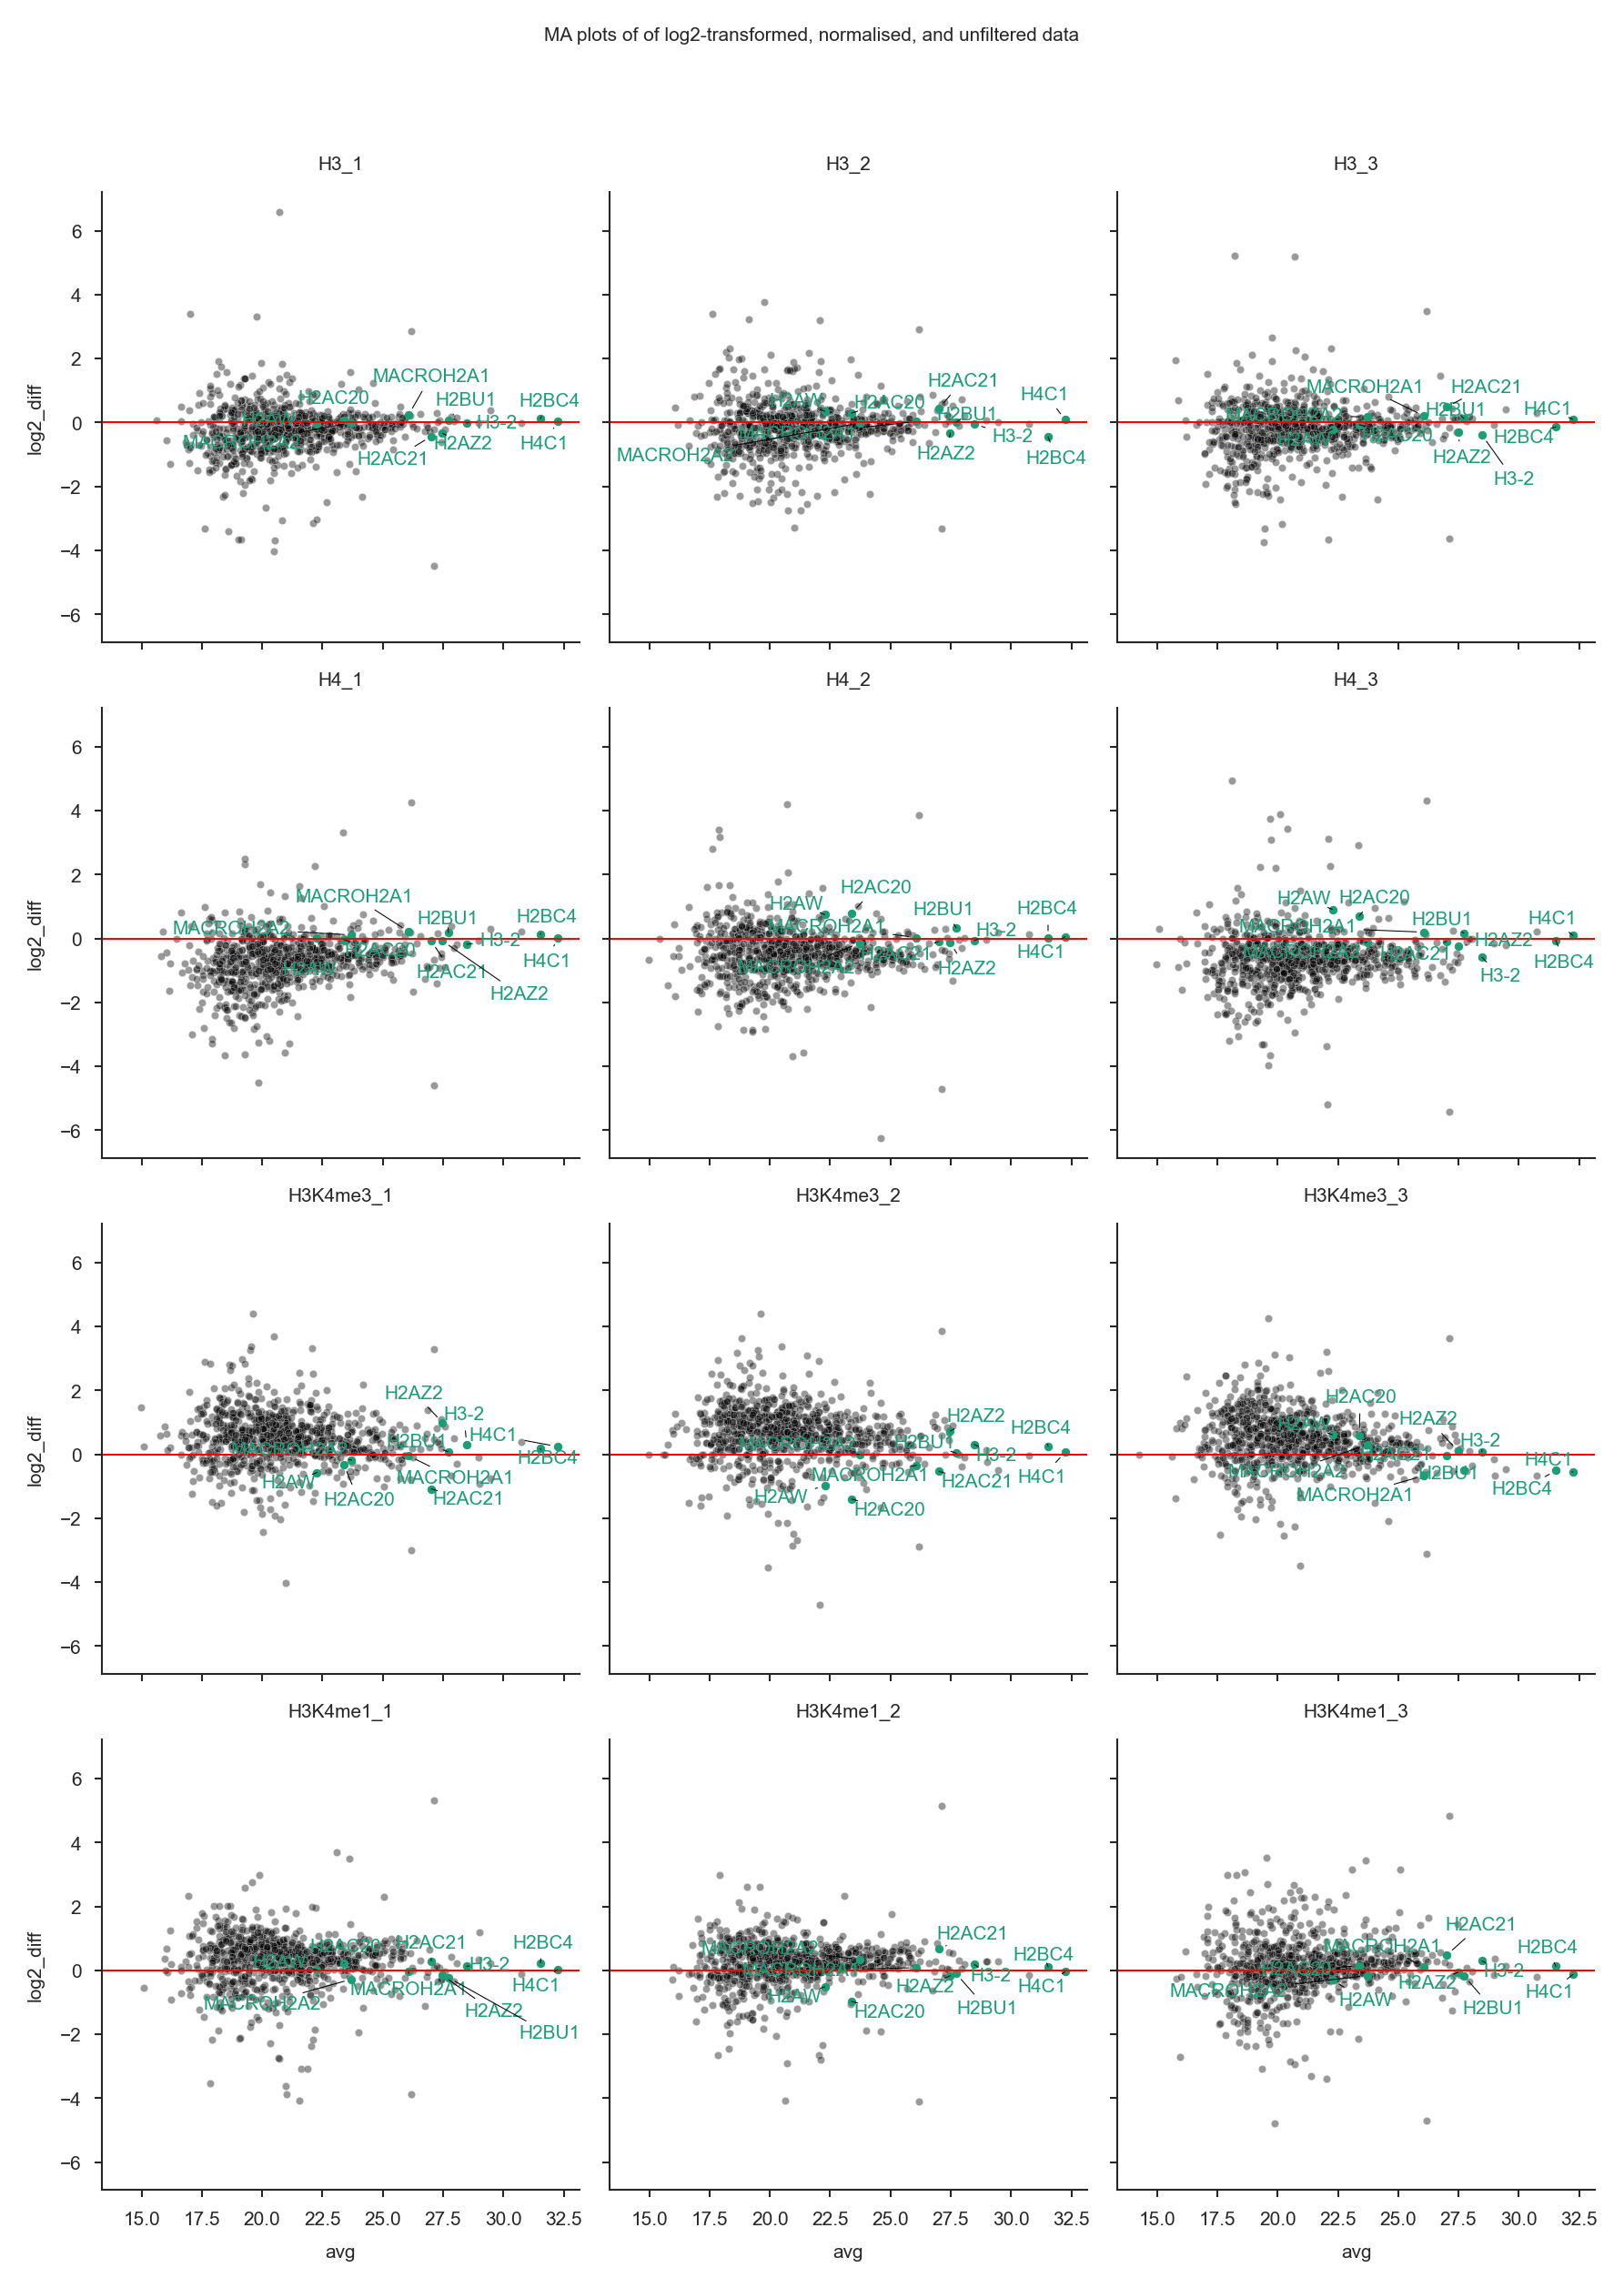

In [37]:
fgrid = sns.FacetGrid(col='Experiment_Replicate', col_wrap=3,
                      size=FIVE_MM_IN_INCH*10,
                      col_order=data_numeric_log2.columns, data=data_numeric_log2_normalised_ma)
fgrid.map(sns.scatterplot, 'avg', 'log2_diff', alpha=.4, color='black')
fgrid.map_dataframe(annotate_histones, 'avg', 'log2_diff')
# fgrid.map_dataframe(add_horizontal_line)
fgrid.set_titles('{col_name}')
for experiment, ax in fgrid.axes_dict.items():
    ax.axhline(0, linestyle='-', color='red', zorder=1)
    ax.grid(False)

plt.suptitle("MA plots of of log2-transformed, normalised, and unfiltered data", y=1.05)

_fname = OUTPUT_DIRECTORY / '02-normalisation-log2-transformed-normalised-unfiltered-ma-plot.pdf'
_caption = """
MA-like plot for log2-transformed, normalised and unfiltered data.

X axis plots mean(log2_intensity) across data rows (proteins). X axis is the same in every plot.
Y axis plots log2_intensity - mean(log2_intensity) offsets for individual samples

Histone proteins are highlighted in green.

Red line indicates x=0 line around which the data is centered now.
"""
plt.savefig(_fname, bbox_inches='tight', dpi=DPI)
with open(str(_fname) + '.caption.md', 'w') as f:
    f.write(_caption)
    print(_caption)

#### Correlation matrix


A Pearson correlation matrix showing the coerrelation coefficient estimate,
for the datasets, after normalisation. 



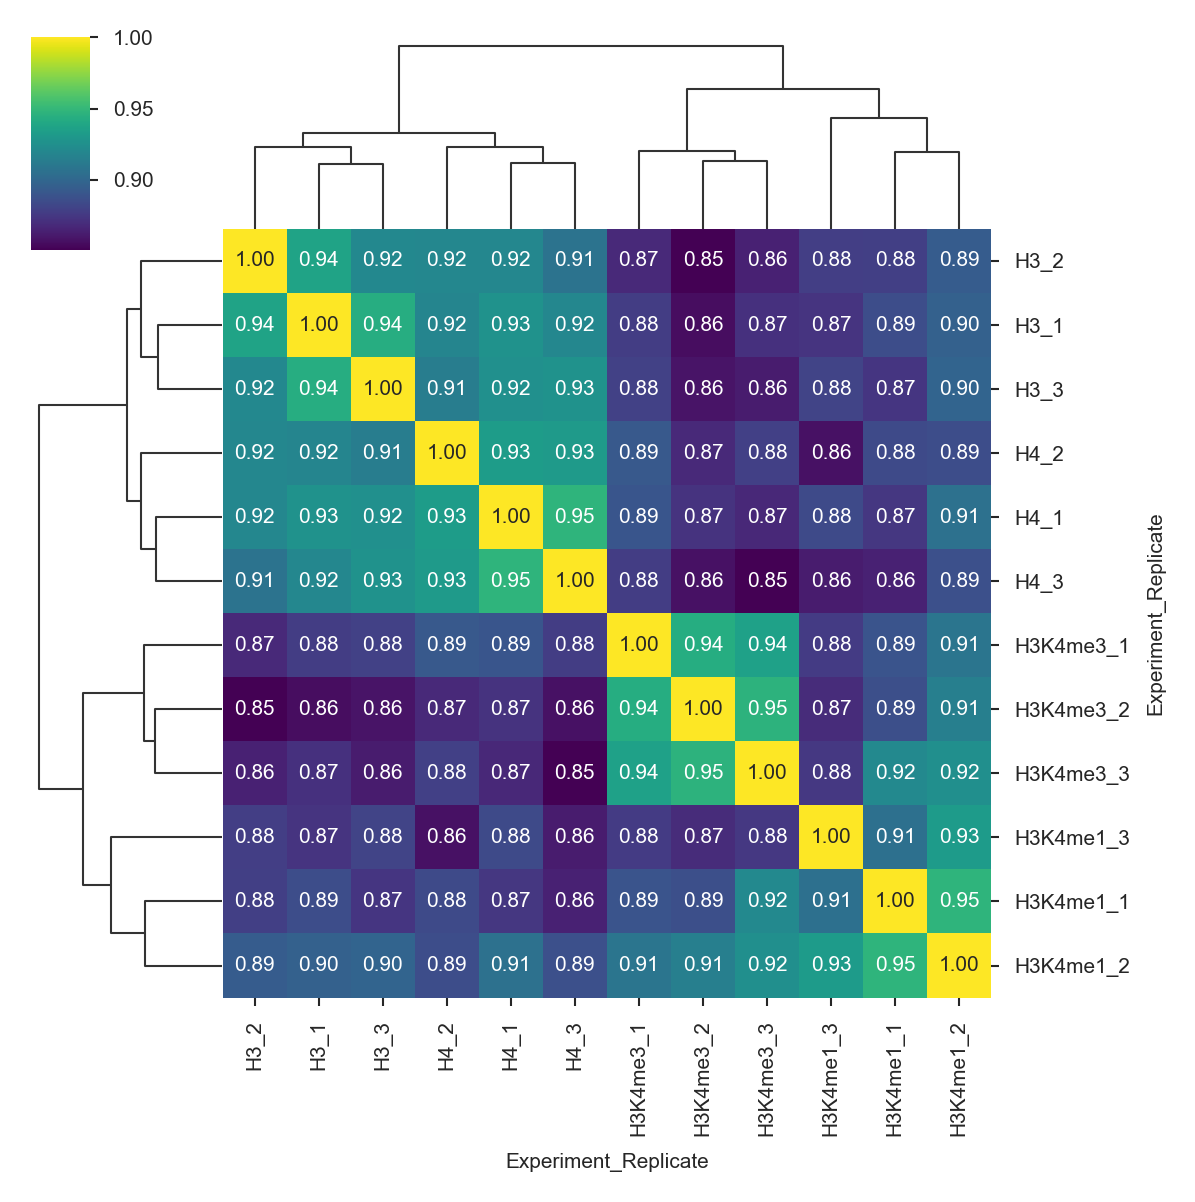

In [38]:
sns.clustermap(data_numeric_log2_normalised.corr(), 
               cmap='viridis', 
               annot=True, fmt='.2f',
               figsize=(FIVE_MM_IN_INCH*20, FIVE_MM_IN_INCH*20))

_fname = OUTPUT_DIRECTORY / '02-correlation-matrix-of-normalised-data.pdf'
_caption = """
A Pearson correlation matrix showing the coerrelation coefficient estimate,
for the datasets, after normalisation. 
"""
plt.savefig(_fname, bbox_inches='tight', dpi=DPI)
with open(str(_fname) + '.caption.md', 'w') as f:
    f.write(_caption)
    print(_caption)

#### PCA

We can also observe how the PCA plot changes after the normalisation


Principal Component embedding of log2-transformed, normalised, and unfiltered dataset, including only the rows which have no missing values.
The principal component 1 (PC1) is plotted on the X axis, while the PC2 is plotted on the Y. 
The explained variance ratio is highlighted in parentheses.

Note that the experiment types (colour, see legend on the right) cluster together much better after the normalisation.



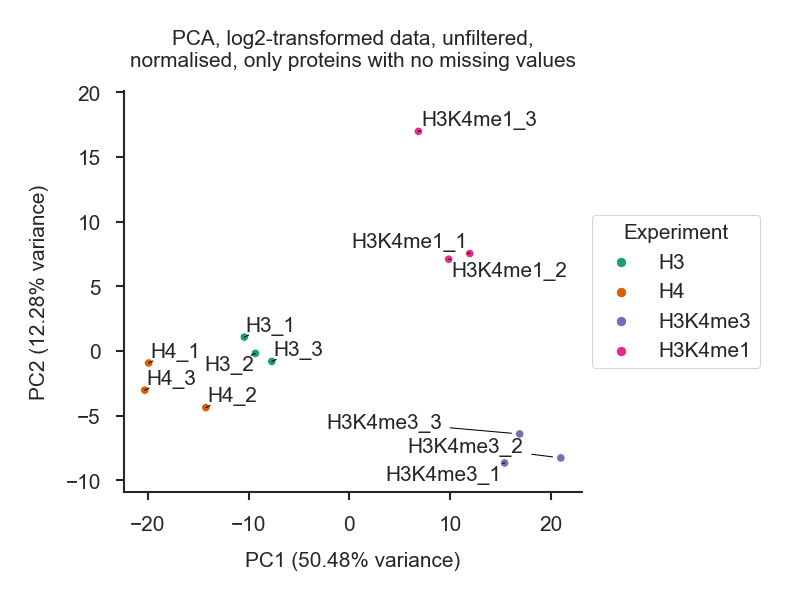

In [39]:
from adjustText import adjust_text
from sklearn.decomposition import PCA

pca = PCA(n_components=2)

# Note that we only look at the rows that are all not null:
projected = pca.fit_transform(data_numeric_log2_normalised.dropna(axis=0).T)

projected = pd.DataFrame(projected, index=data_numeric_log2_normalised.columns, columns=['PC1', 'PC2'])
explained_variance = pd.Series(pca.explained_variance_ratio_, index=projected.columns)

ax = plt.gca()

sns.scatterplot(x='PC1', y='PC2', hue='Experiment', data=projected.join(headers))

texts = []
for ix, row in projected.iterrows():
    texts.append(ax.text(row['PC1'], row['PC2'], ix, ha='center', va='center'))

xlim = ax.get_xlim()
ylim = ax.get_ylim()

# Increasing ylim helps place the H3K4me3 labels
ax.set_ylim(ylim[0]*1.1, ylim[1] * 1.1)

adjust_text(texts, projected['PC1'].values, projected['PC2'].values, arrowprops=dict(arrowstyle='-'))

ax.set_xlabel("PC1 ({:.2%} variance)".format(explained_variance.loc['PC1']))
ax.set_ylabel("PC2 ({:.2%} variance)".format(explained_variance.loc['PC2']))
ax.grid(False)
ax.set_title("PCA, log2-transformed data, unfiltered,\nnormalised, only proteins with no missing values")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), title='Experiment')


_fname = OUTPUT_DIRECTORY / '02-normalisation-PCA-post-normalisation.pdf'
_caption = """
Principal Component embedding of log2-transformed, normalised, and unfiltered dataset, including only the rows which have no missing values.
The principal component 1 (PC1) is plotted on the X axis, while the PC2 is plotted on the Y. 
The explained variance ratio is highlighted in parentheses.

Note that the experiment types (colour, see legend on the right) cluster together much better after the normalisation.
"""
plt.savefig(_fname, bbox_inches='tight', dpi=DPI)
with open(str(_fname) + '.caption.md', 'w') as f:
    f.write(_caption)
    print(_caption)

## Filtering

It is counterproductive to throw _all_ of the data into the model.
For better performance we will filter out some of the proteins.

Particularly, we will only keep the proteins which have at least `MINIMUM_NUMBER_OF_OBSERVED_VALUES_PER_CONDITION` in any of the four experimental conditions (H3, H4, H3K4me1, or H3K4me3).

In [40]:
MINIMUM_NUMBER_OF_OBSERVED_VALUES_PER_CONDITION

2

First count how many non-null values does each protein have:

In [41]:
# Make a long-format DF with non-null values
_df = (~data_numeric_log2_normalised.isnull()).stack()
_df.name = 'is_not_null'

# Join with headers
_df = _df.reset_index().join(headers, on='Experiment_Replicate')

# Groupby label and experiment and count
number_non_null_per_condition = _df.groupby(['Label', 'Experiment'])['is_not_null'].sum().unstack('Experiment')
number_non_null_per_condition

Experiment  H3  H3K4me1  H3K4me3  H4
Label                               
ABCF1        3        3        3   3
ACBD3        0        1        0   2
ACIN1        3        1        3   3
ACLY         3        3        2   2
ACO1         2        1        3   2
...         ..      ...      ...  ..
ZNF512       3        3        3   3
ZNF512B      2        2        3   2
ZNF800       3        3        3   3
ZRANB2       2        1        3   2
ZYX          3        1        3   2

[1046 rows x 4 columns]

Now check which labels match our condition:

In [42]:
sufficient_number_of_values = (number_non_null_per_condition >= MINIMUM_NUMBER_OF_OBSERVED_VALUES_PER_CONDITION).any(axis=1)
sufficient_number_of_values

Label
ABCF1      True
ACBD3      True
ACIN1      True
ACLY       True
ACO1       True
           ... 
ZNF512     True
ZNF512B    True
ZNF800     True
ZRANB2     True
ZYX        True
Length: 1046, dtype: bool

We will throw away all of the proteins which have the value set to False, in hte series above. There are this many of them:

In [43]:
sufficient_number_of_values.value_counts()

True     929
False    117
dtype: int64

In order to stay civilised we will create a new series called "Comment" and mark the reason of filtering out in there:

In [44]:
data_comment = pd.Series(None, index=data_numeric_log2_normalised.index, name='Comment', dtype=str)
data_comment.loc[~sufficient_number_of_values] = "Insufficient number of non-null values"

In [45]:
data_comment

Label
GBE1      Insufficient number of non-null values
EFTUD2                                       NaN
YWHAB                                        NaN
YWHAE                                        NaN
YWHAH                                        NaN
                           ...                  
ZNF800                                       NaN
ZRANB2                                       NaN
ZFR                                          NaN
AZGP1                                        NaN
ZYX                                          NaN
Name: Comment, Length: 1046, dtype: object

In [46]:
data_comment.value_counts()

Insufficient number of non-null values    117
Name: Comment, dtype: int64

Perfect, we can move on to modelling

## Modeling

### The inputs

We will model the only the normalised data which has a sufficient number of values:

In [47]:
data_to_model = data_numeric_log2_normalised.loc[sufficient_number_of_values]
data_to_model

Experiment_Replicate       H3_1       H3_2       H3_3       H4_1       H4_2  \
Label                                                                         
EFTUD2                17.529162  17.503392  16.539555  16.318518  18.794640   
YWHAB                 17.500332  18.489014  19.051719  17.253775  18.609681   
YWHAE                 17.978340  17.660600        NaN  17.732780  17.729887   
YWHAH                 26.469061  27.598393  28.196840  25.482620  26.254161   
YWHAG                 18.916806  17.748610  17.837578  17.155736  17.583312   
...                         ...        ...        ...        ...        ...   
ZNF800                20.116863  19.957744  18.762092  17.107449  19.010215   
ZRANB2                16.632241  17.698422        NaN        NaN  17.080012   
ZFR                         NaN        NaN        NaN  17.975881  17.715118   
AZGP1                 22.342637  22.993326  23.047930  21.558046  21.965314   
ZYX                   17.617100  18.514837  18.768639  17.321350  19.223079   

Experiment_Replicate       H4_3  H3K4me3_1  H3K4me3_2  H3K4me3_3  H3K4me1_1  \
Label                                                                         
EFTUD2                14.775579  20.041195  19.531290  19.353650  20.006004   
YWHAB                 17.226879  19.144883  20.010644  19.970746  19.625605   
YWHAE                 18.127845  19.045548  19.793507  19.774640  18.833497   
YWHAH                 25.594706  27.232678  27.759508  27.235605  25.612516   
YWHAG                 17.639075  18.917128  18.725439  20.108796  19.400871   
...                         ...        ...        ...        ...        ...   
ZNF800                18.496467  22.306802  21.887212  21.924212  20.914221   
ZRANB2                16.884347  17.373421  18.116876  19.007300  18.309003   
ZFR                         NaN        NaN  20.647178  21.060608  20.466560   
AZGP1                 21.835160  22.980912  23.683567  23.236657  23.185682   
ZYX                         NaN  19.094547  20.335859  19.638187  19.054569   

Experiment_Replicate  H3K4me1_2  H3K4me1_3  
Label                                       
EFTUD2                      NaN  17.373371  
YWHAB                 18.853954  17.076317  
YWHAE                 18.444551  18.741568  
YWHAH                 26.115492  27.307797  
YWHAG                 18.872245  18.985820  
...                         ...        ...  
ZNF800                20.626141  20.979358  
ZRANB2                      NaN        NaN  
ZFR                   19.502292  19.166362  
AZGP1                 23.512826  23.646859  
ZYX                         NaN        NaN  

[929 rows x 12 columns]

This is how the missing value distribution for this data looks like


Distribution of missing values in the log2-transformed, normalised, and filtered data which will be used for modelling. 
The heatmap above displays all  929 proteins remaining in the data after filtering in rows, and all experiments in columns. 
Dark values indicate the presence of a value, while white space indicates the absence of one. 
The sparkline on the right hand side counts the number of values per protein, which ranges from zero to 12 in this dataset.



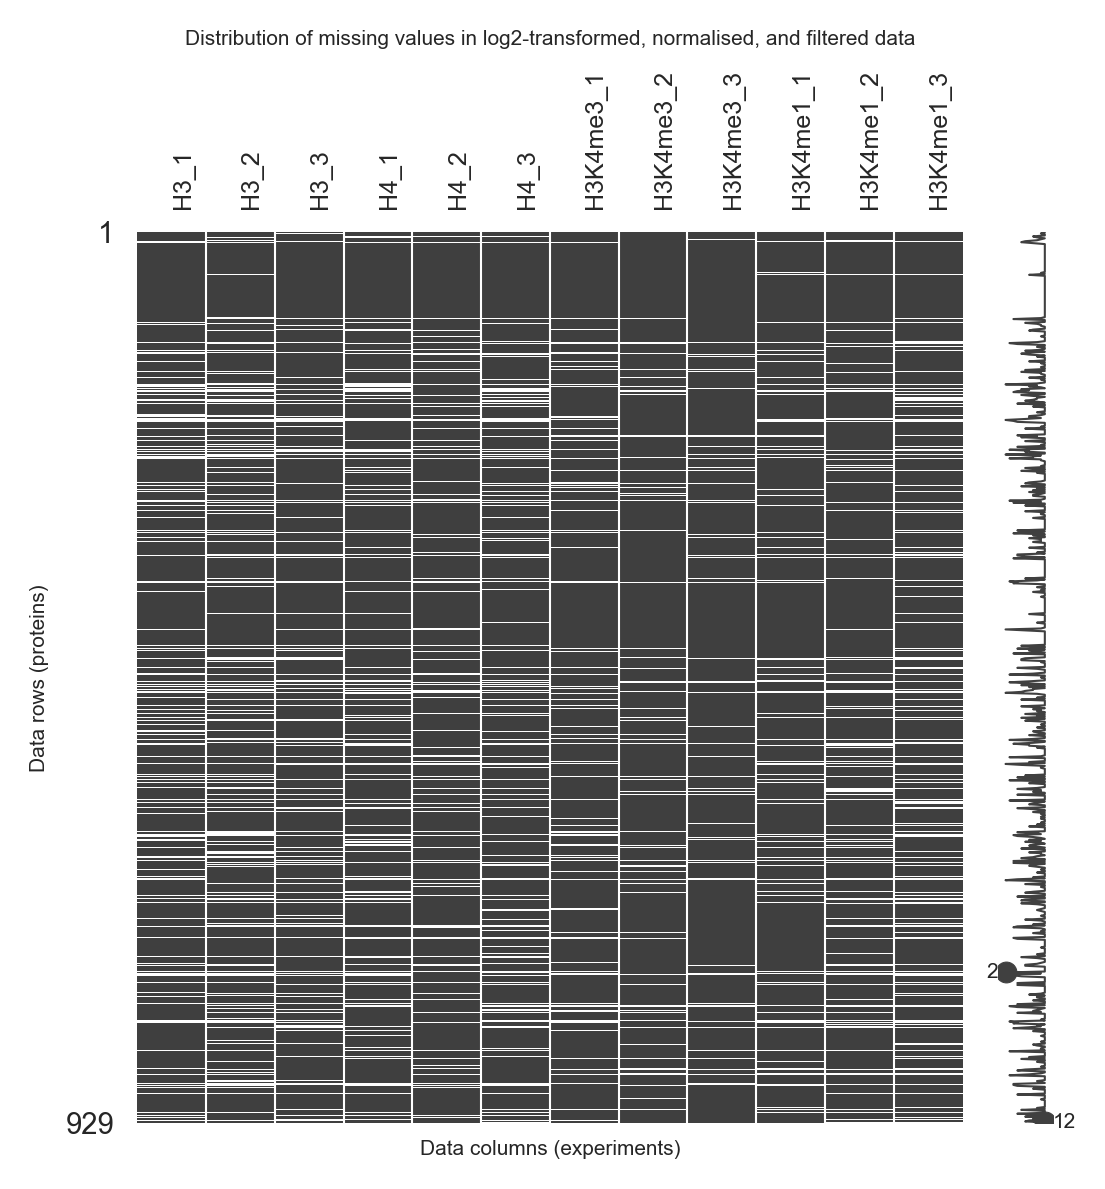

In [48]:
import missingno as msgno
msgno.matrix(data_to_model, figsize=(20*FIVE_MM_IN_INCH, 20*FIVE_MM_IN_INCH), fontsize=6)

plt.title("Distribution of missing values in log2-transformed, normalised, and filtered data")
plt.xlabel("Data columns (experiments)")
plt.ylabel("Data rows (proteins)")
plt.xticks(rotation=90)

_fname = OUTPUT_DIRECTORY / '03-modelling-log2-transformed-normalised-filtered-missing-values.png'
_caption = """
Distribution of missing values in the log2-transformed, normalised, and filtered data which will be used for modelling. 
The heatmap above displays all  929 proteins remaining in the data after filtering in rows, and all experiments in columns. 
Dark values indicate the presence of a value, while white space indicates the absence of one. 
The sparkline on the right hand side counts the number of values per protein, which ranges from zero to 12 in this dataset.
"""
plt.savefig(_fname, bbox_inches='tight', dpi=DPI)
with open(str(_fname) + '.caption.md', 'w') as f:
    f.write(_caption)
    print(_caption)

The special cases here are the proteins which have all zero values in some of the conditions:

In [49]:
all_zero_in_some_condition = (number_non_null_per_condition == 0).any(axis=1)
all_zero_in_some_condition = all_zero_in_some_condition.loc[data_to_model.index]
all_zero_in_some_condition.value_counts()

False    827
True     102
dtype: int64

These proteins are special cases. To visualise them better let's establish a consistent sort order
which is based on which condition is missing

In [50]:
all_zero_in_some_condition_sort_order = number_non_null_per_condition.loc[all_zero_in_some_condition[all_zero_in_some_condition].index].sort_values(by=['H3', 'H4', 'H3K4me1', 'H3K4me3']).index

Let's plot these special cases


Distribution of missing values in the log2-transformed, normalised, and filtered data of proteins that correspond to "special cases" in the modeling as they have all zero values in at least one of the conditions.
The heatmap above displays all 102 of such proteins, sorted by their missing value pattern. 
Dark values indicate the presence of a value, while white space indicates the absence of one. 
The sparkline on the right hand side counts the number of values per protein, which ranges from zero to 12 in this dataset.



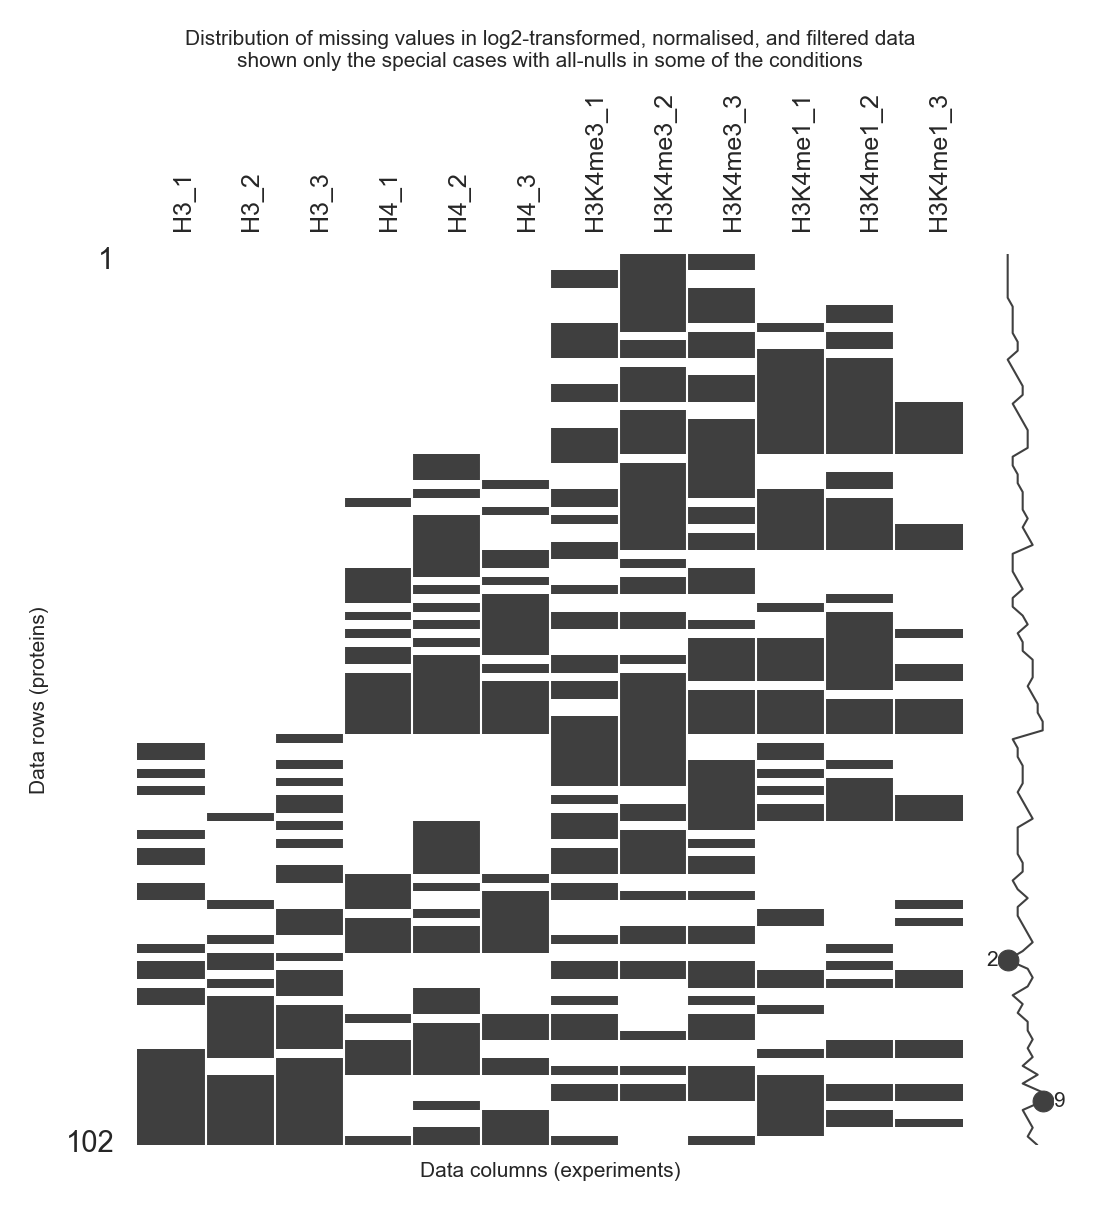

In [51]:
import missingno as msgno
msgno.matrix(
    data_to_model.loc[all_zero_in_some_condition_sort_order], figsize=(20*FIVE_MM_IN_INCH, 20*FIVE_MM_IN_INCH), fontsize=6)

plt.title("Distribution of missing values in log2-transformed, normalised, and filtered data\nshown only the special cases with all-nulls in some of the conditions")
plt.xlabel("Data columns (experiments)")
plt.ylabel("Data rows (proteins)")
plt.xticks(rotation=90)

# For some reason this plot does not rasterize well..
_fname = OUTPUT_DIRECTORY / '03-modelling-log2-transformed-normalised-filtered-missing-values-all_zero_in_some_condition.png'
_caption = """
Distribution of missing values in the log2-transformed, normalised, and filtered data of proteins that correspond to "special cases" in the modeling as they have all zero values in at least one of the conditions.
The heatmap above displays all 102 of such proteins, sorted by their missing value pattern. 
Dark values indicate the presence of a value, while white space indicates the absence of one. 
The sparkline on the right hand side counts the number of values per protein, which ranges from zero to 12 in this dataset.
"""
plt.savefig(_fname, bbox_inches='tight', dpi=DPI)
with open(str(_fname) + '.caption.md', 'w') as f:
    f.write(_caption)
    print(_caption)

We can also get a few special cases of proteins from that list

In [52]:
number_non_null_per_condition

Experiment  H3  H3K4me1  H3K4me3  H4
Label                               
ABCF1        3        3        3   3
ACBD3        0        1        0   2
ACIN1        3        1        3   3
ACLY         3        3        2   2
ACO1         2        1        3   2
...         ..      ...      ...  ..
ZNF512       3        3        3   3
ZNF512B      2        2        3   2
ZNF800       3        3        3   3
ZRANB2       2        1        3   2
ZYX          3        1        3   2

[1046 rows x 4 columns]

In [53]:
number_non_null_per_condition.loc[
    (number_non_null_per_condition[['H3', 'H4']] > 2).any(axis=1) & (number_non_null_per_condition[['H3K4me1', 'H3K4me3']] == 0).all(axis=1)
]

Experiment  H3  H3K4me1  H3K4me3  H4
Label                               
TNNT3        2        0        0   3

In [54]:
REPRESENTATIVE_NULLS = [
    'FAM98A', 'PHF8', 'EIF4G1', 'ZMYND11', # Controls null, proteins non-null
    'PSMC1', 'SNTB2', 'TUBB2A', 'TNNT3', # Controls non-null, proteins null
]

/usr/local/Caskroom/miniconda/base/envs/marcs-chip-ms-h3k4me1-h3k4me3/lib/python3.10/site-packages/seaborn/axisgrid.py:337: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)



Distribution of non-null values of log2-transformed, normalised, and filtered dataset. 
The rows facet the four experiment types, while the columns split the data per replicate.
The green distribution plot shows the histogram of observed log2 values in the data.
The black curve shows the corresponding normal distribution fit to the data, whose parameters are written in the top-right corner.
The black vertical line indicates the mean ($\mu$) estimate.



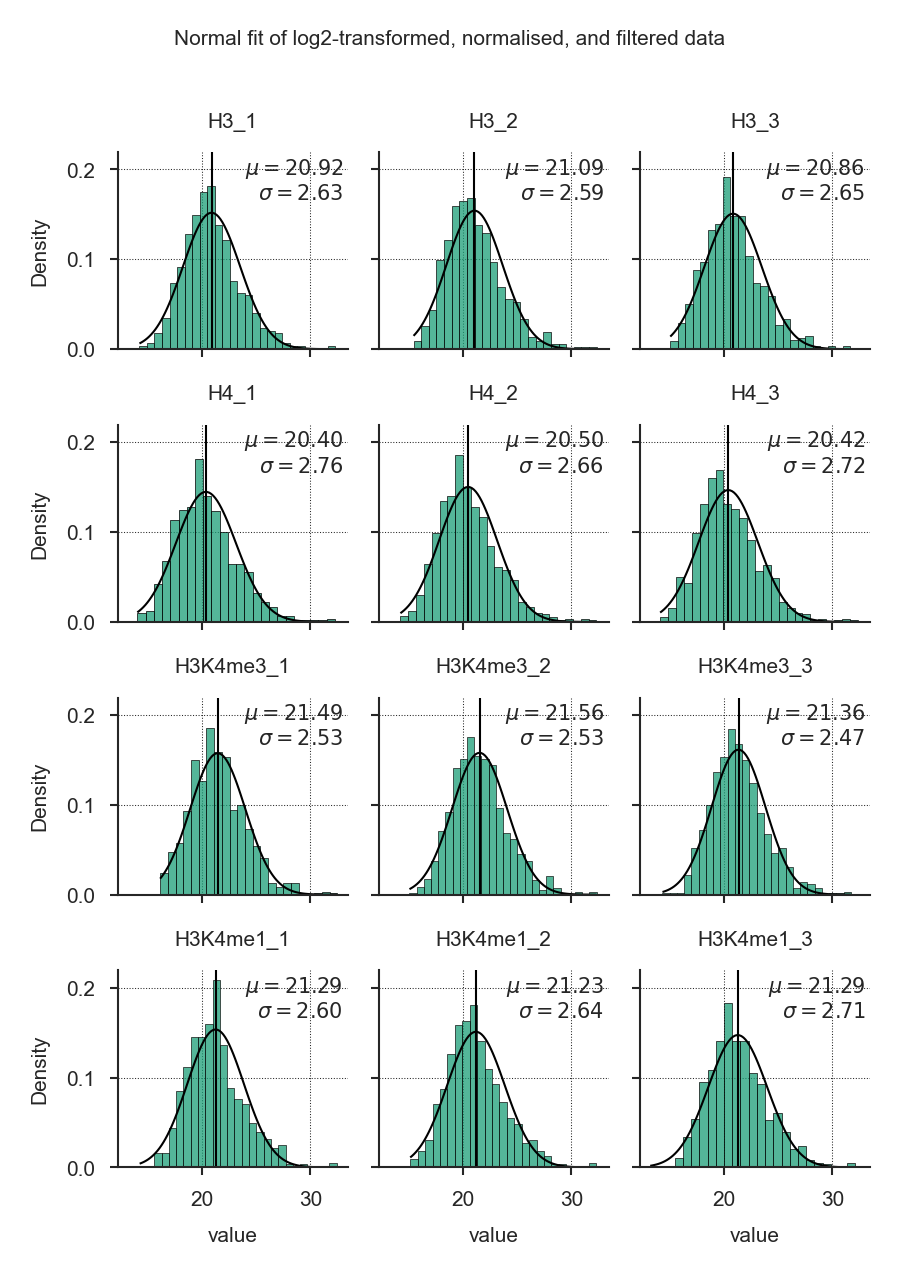

In [55]:
# Convert data to long format
_df = data_to_model.copy()
_df = _df.stack(_df.columns.names)
_df.name = 'value'
_df = _df.reset_index()

# Plot the histograms and normal distribution fits
fgrid = sns.FacetGrid(col='Experiment_Replicate', col_wrap=3, col_order=data_to_model.columns, data=_df, size=FIVE_MM_IN_INCH*5)
fgrid.map(sns.histplot, 'value', stat='density')
fgrid.map(_plot_norm_fit, 'value')
fgrid.set_titles('{col_name}')

plt.suptitle("Normal fit of log2-transformed, normalised, and filtered data", y=1.05)

_fname = OUTPUT_DIRECTORY / '03-modelling-log2-transformed-normalised-filtered-normal-fit.pdf'
_caption = """
Distribution of non-null values of log2-transformed, normalised, and filtered dataset. 
The rows facet the four experiment types, while the columns split the data per replicate.
The green distribution plot shows the histogram of observed log2 values in the data.
The black curve shows the corresponding normal distribution fit to the data, whose parameters are written in the top-right corner.
The black vertical line indicates the mean ($\mu$) estimate.
"""
plt.savefig(_fname, bbox_inches='tight', dpi=DPI)
with open(str(_fname) + '.caption.md', 'w') as f:
    f.write(_caption)
    print(_caption)

### Design matrix and contrasts

For modeling we will use limma and encode the data as a "means" model.

We first need to load the limma into `rpy2` environment:

In [56]:
import rpy2.robjects as robjects
from rpy2.robjects import pandas2ri, numpy2ri

%load_ext rpy2.ipython

Time to load data into R, we will use `limma` for most tastks:

In [57]:
%%R

library("limma")
packageVersion("limma")

[1] ‘3.50.1’


Now we load the header data and make sure that it's columns are interpreted as factors correctly:

In [58]:
assert headers.index.equals(data_to_model.columns), "Make sure that headers index matches data_to_model columns!"

In [59]:
%%R -i headers


headers$Experiment <- as.factor(headers$Experiment)
headers$Experiment <- relevel(headers$Experiment, ref="H4")

headers$Replicate <- as.factor(headers$Replicate)
headers

          Experiment Replicate
H3_1              H3         1
H3_2              H3         2
H3_3              H3         3
H4_1              H4         1
H4_2              H4         2
H4_3              H4         3
H3K4me3_1    H3K4me3         1
H3K4me3_2    H3K4me3         2
H3K4me3_3    H3K4me3         3
H3K4me1_1    H3K4me1         1
H3K4me1_2    H3K4me1         2
H3K4me1_3    H3K4me1         3


To create the design matrix, we will use a Means (no intercept) design 

In [60]:
%%R

# Do not use intercept:
design <- model.matrix(~0 + Experiment, headers)
design

          ExperimentH4 ExperimentH3 ExperimentH3K4me1 ExperimentH3K4me3
H3_1                 0            1                 0                 0
H3_2                 0            1                 0                 0
H3_3                 0            1                 0                 0
H4_1                 1            0                 0                 0
H4_2                 1            0                 0                 0
H4_3                 1            0                 0                 0
H3K4me3_1            0            0                 0                 1
H3K4me3_2            0            0                 0                 1
H3K4me3_3            0            0                 0                 1
H3K4me1_1            0            0                 1                 0
H3K4me1_2            0            0                 1                 0
H3K4me1_3            0            0                 1                 0
attr(,"assign")
[1] 1 1 1 1
attr(,"contrasts")
attr(,"contrasts"

From this design matrix we are primarily interested in three contrasts:

- `H3K4me1vsControl`: `H3K4me1` vs mean of `H4` and `H3` controls
- `H3K4me3vsControl`: `H3K4me3` vs mean of `H4` and `H3` controls
- `H3K4me3vsH3K4me1`: `H3K4me3` vs `H3K4me1` (note that this is the same as `H3K4me1vsControl` vs `H3K4me3vsControl`)

In [61]:
%%R -o contrasts_matrix_as_df

contrasts.matrix <- limma::makeContrasts(
    "H3K4me1vsControl"=ExperimentH3K4me1-(ExperimentH4 + ExperimentH3)/2,
    "H3K4me3vsControl"=ExperimentH3K4me3-(ExperimentH4 + ExperimentH3)/2, 
    "H3K4me3vsH3K4me1"=ExperimentH3K4me3-ExperimentH3K4me1, 
    
    levels=design
)

contrasts_matrix_as_df = as.data.frame(contrasts.matrix)
contrasts.matrix

                   Contrasts
Levels              H3K4me1vsControl H3K4me3vsControl H3K4me3vsH3K4me1
  ExperimentH4                  -0.5             -0.5                0
  ExperimentH3                  -0.5             -0.5                0
  ExperimentH3K4me1              1.0              0.0               -1
  ExperimentH3K4me3              0.0              1.0                1


In [62]:
contrasts_matrix_as_df

H3K4me1vsControl  H3K4me3vsControl  H3K4me3vsH3K4me1
ExperimentH4                   -0.5              -0.5               0.0
ExperimentH3                   -0.5              -0.5               0.0
ExperimentH3K4me1               1.0               0.0              -1.0
ExperimentH3K4me3               0.0               1.0               1.0

### The fit

Here we fit the simple limma model, and extract the resulting coefficient estimates and contrasts.
Note that we use `robust=TRUE` in the `eBayes` function

In [63]:
%%R -i data_to_model -o coef_estimates_design -o coef_estimates_contrasts


fit <- limma::lmFit(data_to_model, design)

coef_estimates_design = as.data.frame(fit$coefficients)

fit2 <- limma::contrasts.fit(fit, contrasts.matrix)

# Note robust=TRUE
fit2 <- limma::eBayes(fit2, robust=TRUE)

coef_estimates_contrasts <- as.data.frame(fit2$coefficients)


For coefficient estimates it is now most important to check that the coefficients were estimated in a predictable way for those special case proteins that have all nulls in at least one of the conditions.

In [64]:
_df = number_non_null_per_condition.loc[data_to_model.index]

fraction_null_coefs = []
# For each experiment
for experiment in _df.columns:
    # For each number of non-null values possible
    for non_null_count, _subdf in _df[experiment].groupby(_df[experiment]):
        # Count number of null coefficient_estimates for the coefficient
        fraction_null_coefs.append([experiment, non_null_count, coef_estimates_design.loc[_subdf.index, f'Experiment{experiment}'].isnull().astype(float).mean()])
        
fraction_null_coefs = pd.DataFrame(fraction_null_coefs, columns=['Experiment',' Number of non-null observations', 'Fraction of null coefficient estimates'])
fraction_null_coefs
        

Experiment   Number of non-null observations  \
0          H3                                 0   
1          H3                                 1   
2          H3                                 2   
3          H3                                 3   
4     H3K4me1                                 0   
5     H3K4me1                                 1   
6     H3K4me1                                 2   
7     H3K4me1                                 3   
8     H3K4me3                                 0   
9     H3K4me3                                 1   
10    H3K4me3                                 2   
11    H3K4me3                                 3   
12         H4                                 0   
13         H4                                 1   
14         H4                                 2   
15         H4                                 3   

    Fraction of null coefficient estimates  
0                                      1.0  
1                                      0.0  
2                                      0.0  
3                                      0.0  
4                                      1.0  
5                                      0.0  
6                                      0.0  
7                                      0.0  
8                                      1.0  
9                                      0.0  
10                                     0.0  
11                                     0.0  
12                                     1.0  
13                                     0.0  
14                                     0.0  
15                                     0.0

Note that the coefficients are always null when there is zero data for this particular condition (fraction=1)
But always non-null otherwise

Below is avisualisation of a few representative proteins:

In [65]:
data_to_model.loc[REPRESENTATIVE_NULLS]

Experiment_Replicate       H3_1       H3_2       H3_3       H4_1       H4_2  \
Label                                                                         
FAM98A                      NaN        NaN        NaN  16.288369  17.207787   
PHF8                        NaN        NaN        NaN        NaN        NaN   
EIF4G1                18.489189  22.331849  18.040000        NaN        NaN   
ZMYND11                     NaN  17.706539        NaN        NaN        NaN   
PSMC1                       NaN  17.412761        NaN  17.637945  18.284566   
SNTB2                 16.751258  18.714858  17.239940        NaN        NaN   
TUBB2A                17.807961  17.508858  18.851722  18.240167  16.913304   
TNNT3                 17.916977        NaN  18.110342  16.532208  16.597527   

Experiment_Replicate       H4_3  H3K4me3_1  H3K4me3_2  H3K4me3_3  H3K4me1_1  \
Label                                                                         
FAM98A                17.267267  20.181928  19.692893  19.882885  19.893043   
PHF8                        NaN  20.682903  20.790425  20.305104  14.309719   
EIF4G1                      NaN  19.045679  19.987642  18.706725  18.845305   
ZMYND11                     NaN  22.710720  22.877675  22.606844  20.331341   
PSMC1                 16.385890  18.264181  17.293807  18.641409        NaN   
SNTB2                 17.684112        NaN        NaN        NaN  17.346170   
TUBB2A                15.882954  17.830394        NaN  19.206813        NaN   
TNNT3                 17.648350        NaN        NaN        NaN        NaN   

Experiment_Replicate  H3K4me1_2  H3K4me1_3  
Label                                       
FAM98A                18.221506  18.182710  
PHF8                  15.183549  15.807594  
EIF4G1                18.802224  17.789048  
ZMYND11               20.292264  20.448003  
PSMC1                       NaN        NaN  
SNTB2                 17.268692  17.350656  
TUBB2A                      NaN        NaN  
TNNT3                       NaN        NaN

In [66]:
coef_estimates_design.loc[REPRESENTATIVE_NULLS, ['ExperimentH3', 'ExperimentH4', 'ExperimentH3K4me3', 'ExperimentH3K4me1']]

ExperimentH3  ExperimentH4  ExperimentH3K4me3  ExperimentH3K4me1
FAM98A            NaN     16.921141          19.919235          18.765753
PHF8              NaN           NaN          20.592811          15.100288
EIF4G1      19.620346           NaN          19.246682          18.478859
ZMYND11     17.706539           NaN          22.731746          20.357203
PSMC1       17.412761     17.436134          18.066466                NaN
SNTB2       17.568685     17.684112                NaN          17.321839
TUBB2A      18.056180     17.012141          18.518604                NaN
TNNT3       18.013659     16.926028                NaN                NaN

And the corresponding contrasts:

In [67]:
coef_estimates_contrasts.loc[REPRESENTATIVE_NULLS]

H3K4me1vsControl  H3K4me3vsControl  H3K4me3vsH3K4me1
FAM98A                NaN               NaN          1.153482
PHF8                  NaN               NaN          5.492523
EIF4G1                NaN               NaN          0.767823
ZMYND11               NaN               NaN          2.374543
PSMC1                 NaN          0.642019               NaN
SNTB2           -0.304559               NaN               NaN
TUBB2A                NaN          0.984443               NaN
TNNT3                 NaN               NaN               NaN

## Results

The results can be extracted from R by calling the `topTable` function in limma once for each contrast, and setting `number` parameter to the number of rows in the data:

In [68]:
%%R -o results_r

coefs <- colnames(contrasts.matrix)
results_r <- list()

for (i in 1:length(coefs)) {
    coef <- coefs[[i]]
    results_r[[coef]] <- limma::topTable(fit2, coef=coef, adjust.method="BH", number=nrow(data_to_model))
}


We convert these results to python and add another column called "Significant" which is true if the adjusted p value is lower than `FDR_THRESHOLD` specified in parameters

In [69]:
FDR_THRESHOLD

0.05

In [70]:
with robjects.conversion.localconverter(robjects.default_converter + pandas2ri.converter) as co:
    results = {
        k: co.rpy2py(v) for k,v in results_r.items()
    }

for k in results.keys():
    results[k]['significant'] = results[k]['adj.P.Val'] <= FDR_THRESHOLD
    
results = pd.concat(results, keys=results.keys(), axis=1)
results

H3K4me1vsControl                                                    \
                   logFC          t       P.Value     adj.P.Val          B   
HSPA5          -7.844577 -33.200584  9.034384e-12  7.186475e-09  16.644766   
IGHG1           9.457355  31.809345  1.715149e-11  7.186475e-09  16.142245   
MTA2           -3.539802 -15.913318  1.469490e-08  4.104775e-06  10.357831   
CDC5L           4.446435  13.732227  7.836164e-08  1.641676e-05   8.733193   
RPL29           2.697286  10.162448  1.124473e-06  1.806907e-04   6.013663   
...                  ...        ...           ...           ...        ...   
PRPF4                NaN        NaN           NaN           NaN        NaN   
UBA1                 NaN        NaN           NaN           NaN        NaN   
ZC3H18               NaN        NaN           NaN           NaN        NaN   
ZMYND11              NaN        NaN           NaN           NaN        NaN   
ZFR                  NaN        NaN           NaN           NaN        NaN   

                    H3K4me3vsControl                                         \
        significant            logFC          t       P.Value     adj.P.Val   
HSPA5          True        -6.619897 -28.017373  5.056605e-11  4.080274e-08   
IGHG1          True         7.958321  26.767419  9.680366e-11  4.080274e-08   
MTA2           True        -2.491481 -11.200550  4.476369e-07  3.430526e-05   
CDC5L          True         2.591532   8.003605  1.147319e-05  2.073288e-04   
RPL29          True         0.268241   1.010641  3.354520e-01  4.005467e-01   
...             ...              ...        ...           ...           ...   
PRPF4         False              NaN        NaN           NaN           NaN   
UBA1          False              NaN        NaN           NaN           NaN   
ZC3H18        False        -0.412714  -0.559897  6.052087e-01  6.686644e-01   
ZMYND11       False              NaN        NaN           NaN           NaN   
ZFR           False              NaN        NaN           NaN           NaN   

                               H3K4me3vsH3K4me1                       \
                 B significant            logFC          t   P.Value   
HSPA5    15.346740        True         1.224680   4.488792  0.001094   
IGHG1    14.807543        True        -1.499034  -4.366436  0.001362   
MTA2      6.960742        True         1.048321   4.081377  0.002100   
CDC5L     3.631819        True        -1.854903  -4.961133  0.000563   
RPL29    -6.685128       False        -2.429045  -7.925697  0.000011   
...            ...         ...              ...        ...       ...   
PRPF4          NaN       False        -0.508684  -0.749482  0.494946   
UBA1           NaN       False        -0.197186  -0.472962  0.659528   
ZC3H18   -6.776153       False              NaN        NaN       NaN   
ZMYND11        NaN       False         2.374543  11.143247  0.000024   
ZFR            NaN       False         1.142155   2.625751  0.039099   

                                         
        adj.P.Val         B significant  
HSPA5    0.022362 -0.806270        True  
IGHG1    0.027210 -1.022066        True  
MTA2     0.032913 -1.469024        True  
CDC5L    0.015642 -0.114171        True  
RPL29    0.002105  3.846700        True  
...           ...       ...         ...  
PRPF4    0.725096 -6.263008       False  
UBA1     0.829541 -6.312663       False  
ZC3H18        NaN       NaN       False  
ZMYND11  0.002956  3.421679        True  
ZFR      0.168944 -4.056730       False  

[929 rows x 18 columns]

In [71]:
assert set(results.index) == set(data_to_model.index), "Results index does not match input index"

In [72]:
results.loc(axis=1)[:, 'significant'].sum()

H3K4me1vsControl  significant    287
H3K4me3vsControl  significant    455
H3K4me3vsH3K4me1  significant     80
dtype: int64

### Sanity checks

#### Intuitive interpretation of contrasts

We now check these results to see that the estimated log fold changes (by limma) are close to what we would expect from naive modelling. 

This is needed both as a sanity check, and as a justification for "fold change imputation" for a few cases where the FCs could not be estimated analytically.

In [73]:
data_to_model_by_experiment = {
    'H3': data_to_model[['H3_1', 'H3_2', 'H3_3']],
    'H4': data_to_model[['H4_1', 'H4_2', 'H4_3']],
    'H3K4me1': data_to_model[['H3K4me1_1', 'H3K4me1_2', 'H3K4me1_3']],
    'H3K4me3': data_to_model[['H3K4me3_1', 'H3K4me3_2', 'H3K4me3_3']],
    'Controls': data_to_model[['H3_1', 'H3_2', 'H3_3', 'H4_1', 'H4_2', 'H4_3']],
}

In [74]:
_controls = 0.5 * (data_to_model_by_experiment['H3'].mean(axis=1) +  data_to_model_by_experiment['H4'].mean(axis=1))
expected_naively = {
    'H3K4me1vsControl': data_to_model_by_experiment['H3K4me1'].mean(axis=1) - _controls,
    'H3K4me3vsControl': data_to_model_by_experiment['H3K4me3'].mean(axis=1) - _controls,
    'H3K4me3vsH3K4me1': data_to_model_by_experiment['H3K4me3'].mean(axis=1) - data_to_model_by_experiment['H3K4me1'].mean(axis=1),
}

In [75]:
_controls

Label
EFTUD2    16.910141
YWHAB     18.021900
YWHAE     17.841487
YWHAH     26.599297
YWHAG     17.813519
            ...    
ZNF800    18.908472
ZRANB2    17.073755
ZFR             NaN
AZGP1     22.290402
ZYX       18.286203
Length: 929, dtype: float64

In [76]:
expected_naively['H3K4me3vsH3K4me1'].loc['PHF8']

5.492522985678656

In [77]:
results['H3K4me3vsH3K4me1', 'logFC'].loc['PHF8']

5.492522985678656

import pingouin as pg

In [78]:
import pingouin as pg


    Comparison of the H3K4me1vsControl coefficient estimates computed by the model (y axis), and their expected values (x axis).
    The expected values were computed naively - by subtracting the coresponding means from each other.
    The actual values were computed using the limma statistical model.
    
    The scatterpoint highlight individual protein estimates, the line is a linear regression estimate.
    The 95% confidence interval for pearson R estimate is written in the top left corner.
    
    If the model is working correctly, we would expect a perfect fit here.
    

    Comparison of the H3K4me3vsControl coefficient estimates computed by the model (y axis), and their expected values (x axis).
    The expected values were computed naively - by subtracting the coresponding means from each other.
    The actual values were computed using the limma statistical model.
    
    The scatterpoint highlight individual protein estimates, the line is a linear regression estimate.
 

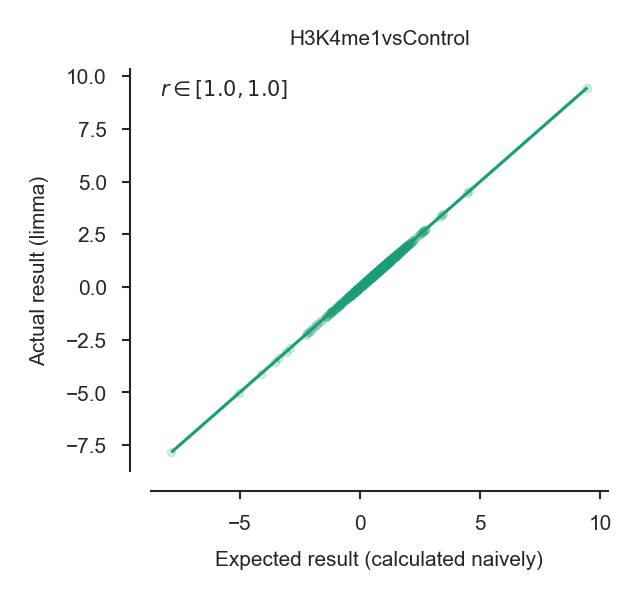

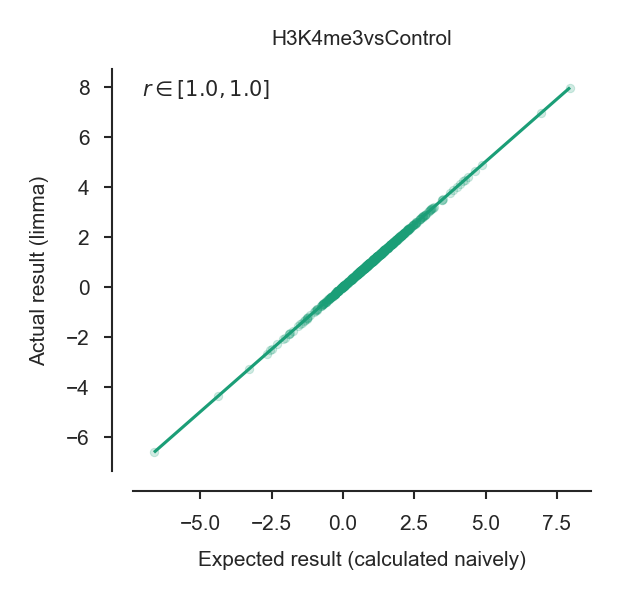

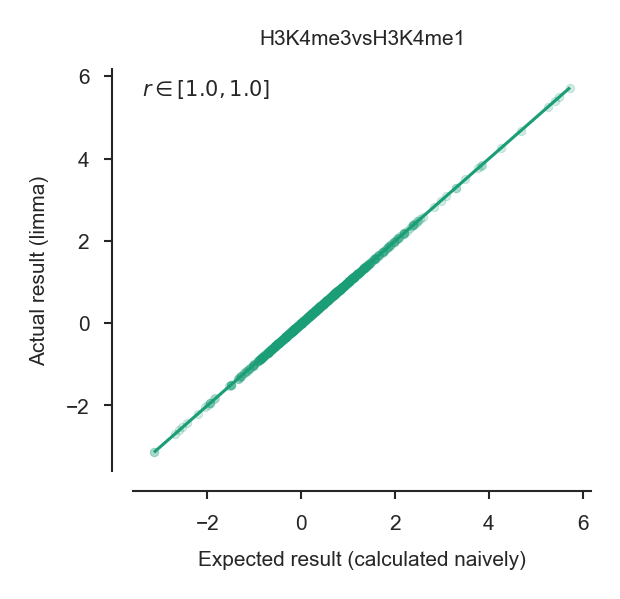

In [79]:
for column, expectation in expected_naively.items():
    fig = plt.figure()
    ax = plt.gca()
    
    _df = pd.DataFrame({'expectation': expectation, 'actual': results[column, 'logFC']})
    
    correlation = pg.corr(_df['expectation'], _df['actual'], method='pearson')
    assert correlation.loc['pearson', 'r'] == 1 # This should always be one
    correlation = correlation.loc['pearson', 'CI95%']
    
    sns.regplot(x='expectation', y='actual', scatter_kws=dict(alpha=0.2), data=_df)
    
    ax.text(0.02, 0.98, r'$r \in [{}, {}]$'.format(*correlation), transform=ax.transAxes, ha='left', va='top')
    ax.set_xlabel("Expected result (calculated naively)")
    ax.set_ylabel("Actual result (limma)")
    ax.set_title(column)
    sns.despine(ax=ax, offset=5)
    
    ax.grid(False)
    
    _fname = OUTPUT_DIRECTORY / f'04-modelling-sanity-checks-for-coefficient-interpretation-{column}.pdf'
    _caption = f"""
    Comparison of the {column} coefficient estimates computed by the model (y axis), and their expected values (x axis).
    The expected values were computed naively - by subtracting the coresponding means from each other.
    The actual values were computed using the limma statistical model.
    
    The scatterpoint highlight individual protein estimates, the line is a linear regression estimate.
    The 95% confidence interval for pearson R estimate is written in the top left corner.
    
    If the model is working correctly, we would expect a perfect fit here.
    """
    plt.savefig(_fname, bbox_inches='tight', dpi=DPI)
    with open(str(_fname) + '.caption.md', 'w') as f:
        f.write(_caption)
        print(_caption)
    

It's also worth seeing how much these results would change if we took a naive mean of the controls, i.e. mean(H3_1,H3_2,H3_3,H4_1,H4_2,H4_3) as opposed to the mean-of-means approach, i.e. 0.5 (mean(H3_1,H3_2,H3_3) + mean(H4_1,H4_2,H4_3))

In [80]:
_controls_simple = data_to_model_by_experiment['Controls'].mean(axis=1)
expected_naively_simple_mean_of_controls = {
    'H3K4me1vsControl': data_to_model_by_experiment['H3K4me1'].mean(axis=1) - _controls_simple,
    'H3K4me3vsControl': data_to_model_by_experiment['H3K4me3'].mean(axis=1) - _controls_simple,
}


    Comparison of the H3K4me1vsControl coefficient estimates computed by the model (y axis), and their simplified expected values (x axis).
    The expected values were computed naively - by subtracting the coresponding means from each other, and by taking a simple mean of the controls, as opposed to the mean-of-means used in the model.
    The actual values were computed using the limma statistical model.
    
    The scatterpoint highlight individual protein estimates, the line is a linear regression estimate.
    The 95% confidence interval for pearson R estimate is written in the top left corner.
    
    If the model is working correctly, we would expect a perfect fit here.
    

    Comparison of the H3K4me3vsControl coefficient estimates computed by the model (y axis), and their simplified expected values (x axis).
    The expected values were computed naively - by subtracting the coresponding means from each other, and by taking a simple mean of the controls, as opposed to the

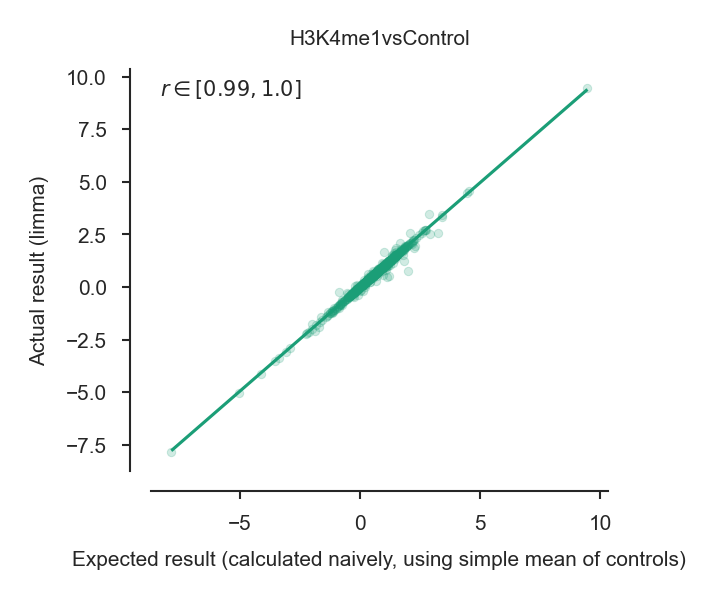

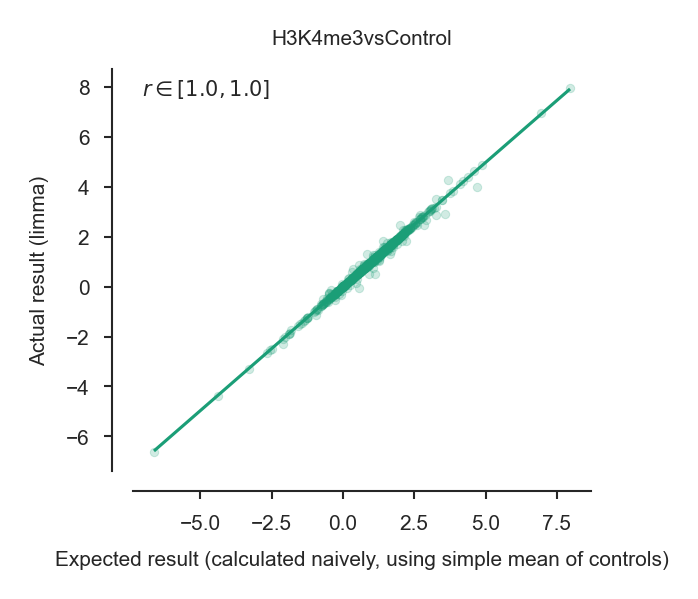

In [81]:
for column, expectation in expected_naively_simple_mean_of_controls.items():
    fig = plt.figure()
    ax = plt.gca()
    
    _df = pd.DataFrame({'expectation': expectation, 'actual': results[column, 'logFC']})
    
    correlation = pg.corr(_df['expectation'], _df['actual'], method='pearson').loc['pearson', 'CI95%']
    
    sns.regplot(x='expectation', y='actual', scatter_kws=dict(alpha=0.2), data=_df)
    
    ax.text(0.02, 0.98, r'$r \in [{}, {}]$'.format(*correlation), transform=ax.transAxes, ha='left', va='top')
    ax.set_xlabel("Expected result (calculated naively, using simple mean of controls)")
    ax.set_ylabel("Actual result (limma)")
    ax.set_title(column)
    sns.despine(ax=ax, offset=5)
    
    ax.grid(False)
    
    _fname = OUTPUT_DIRECTORY / f'04-modelling-sanity-checks-for-coefficient-interpretation-{column}-simple-mean-of-controls.pdf'
    _caption = f"""
    Comparison of the {column} coefficient estimates computed by the model (y axis), and their simplified expected values (x axis).
    The expected values were computed naively - by subtracting the coresponding means from each other, and by taking a simple mean of the controls, as opposed to the mean-of-means used in the model.
    The actual values were computed using the limma statistical model.
    
    The scatterpoint highlight individual protein estimates, the line is a linear regression estimate.
    The 95% confidence interval for pearson R estimate is written in the top left corner.
    
    If the model is working correctly, we would expect a perfect fit here.
    """
    plt.savefig(_fname, bbox_inches='tight', dpi=DPI)
    with open(str(_fname) + '.caption.md', 'w') as f:
        f.write(_caption)
        print(_caption)
    

#### Heatmaps

##### H3K4me1 vs Control

In [82]:
_colname = 'H3K4me1vsControl'
_significant = results.loc[results[_colname, 'significant'], _colname].sort_values(by='logFC', ascending=False)
_significant

logFC          t       P.Value     adj.P.Val          B  \
IGHG1    9.457355  31.809345  1.715149e-11  7.186475e-09  16.142245   
SRP14    4.551977  10.199864  1.293728e-06  1.806907e-04   5.893245   
CDC5L    4.446435  13.732227  7.836164e-08  1.641676e-05   8.733193   
CLIC1    3.450968   5.713125  7.143917e-04  7.043062e-03  -0.182155   
HNRNPA3  3.404189   4.775210  7.448363e-04  7.127701e-03  -0.750735   
...           ...        ...           ...           ...        ...   
NOMO2   -3.083872  -7.633239  2.574463e-04  3.902620e-03   0.970322   
CCT8    -3.383511  -5.227424  7.858127e-04  7.236385e-03  -0.294245   
MTA2    -3.539802 -15.913318  1.469490e-08  4.104775e-06  10.357831   
MACF1   -4.131096  -3.879420  4.644836e-03  1.996089e-02  -2.139545   
HSPA5   -7.844577 -33.200584  9.034384e-12  7.186475e-09  16.644766   

         significant  
IGHG1           True  
SRP14           True  
CDC5L           True  
CLIC1           True  
HNRNPA3         True  
...              ...  
NOMO2           True  
CCT8            True  
MTA2            True  
MACF1           True  
HSPA5           True  

[287 rows x 6 columns]



Heatmap of the significant `logFC` estimates for the H3K4me1vsControl coefficient.
The proteins are sorted by the estimate, descending.

The left heatmap plots the `logFC` estimate, the colour axis limits are set to [-4.0, 4.0].
The right heatmap shows the data used for modelling, standardised to have zero mean of controls (H3 and H4). 

Missing values are marked in grey.



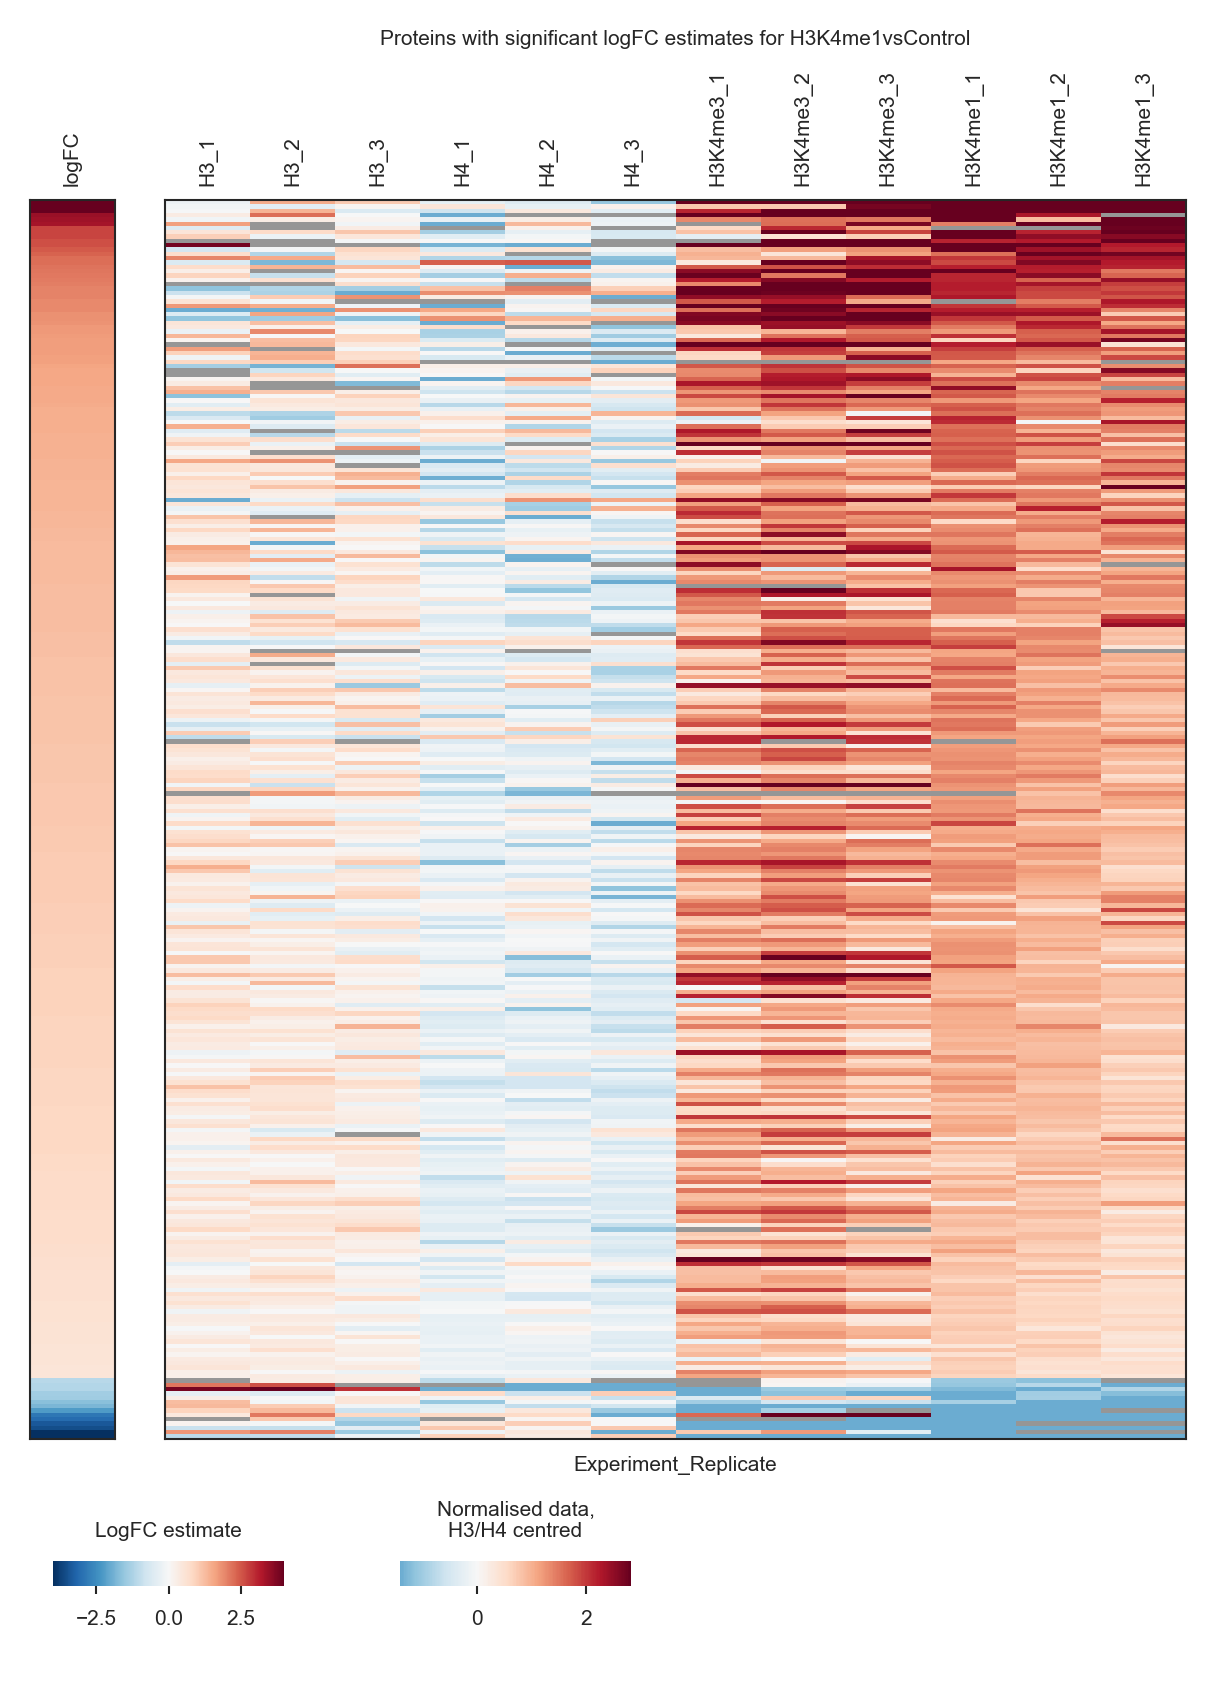

In [83]:
from matplotlib.gridspec import GridSpec
figure = plt.figure(figsize=(20*FIVE_MM_IN_INCH, 28*FIVE_MM_IN_INCH), constrained_layout=True)

gs = GridSpec(2, 2, figure=figure, width_ratios=(1, 12), height_ratios=(10,1))
ax_legends = figure.add_subplot(gs[1,:])
ax_legends.axis('off')
cax_left = ax_legends.inset_axes([0.02, 0.58, 0.2, 0.2], transform=ax_legends.transAxes)
cax_right = ax_legends.inset_axes([0.32, 0.58, 0.2, 0.2], transform=ax_legends.transAxes)

cax_left.set_title("LogFC estimate")
cax_right.set_title("Normalised data,\nH3/H4 centred")

ax_left = figure.add_subplot(gs[0, 0])
ax_right = figure.add_subplot(gs[0, 1], sharey=ax_left)


vmax = np.ceil(_significant['logFC'].abs().replace(np.inf, np.nan).dropna().quantile(0.97))
vmin = -vmax

_matrix = data_to_model.sub(data_to_model_by_experiment['Controls'].mean(axis=1), axis=0)
_matrix = _matrix.loc[_significant.index]

heatmap_right = sns.heatmap(
    _matrix, 
    cmap='RdBu_r', robust=True, center=0,
    ax=ax_right, yticklabels=0, 
    cbar=True,
    cbar_ax = cax_right,
    cbar_kws=dict(orientation='horizontal'),
    linewidth=0,
    linecolor='black',
)

heatmap_right.set_facecolor('#969696')

heatmap_left = sns.heatmap(
    _significant[['logFC']], 
    cmap='RdBu_r', 
    center=0, 
    robust=True,
    ax=ax_left, yticklabels=0, 
    cbar=True,
    cbar_ax=cax_left,
    cbar_kws=dict(orientation='horizontal'),
    linewidth=0,
    vmin=vmin, vmax=vmax,
    linecolor='black',
)

heatmap_right.xaxis.tick_top()
heatmap_right.xaxis.set_tick_params(length=0, rotation=90)

heatmap_left.xaxis.tick_top()
heatmap_left.xaxis.set_tick_params(length=0, rotation=90)

heatmap_right.yaxis.set_tick_params(length=0)
heatmap_left.yaxis.set_tick_params(length=0)

for ax in [heatmap_left, heatmap_right]:
    for spine in ax.spines:
        ax.spines[spine].set_visible(True)

for tick in heatmap_right.yaxis.get_ticklabels():
    tick.set_visible(False)

heatmap_right.set_title(f"Proteins with significant logFC estimates for {_colname}")

_fname = OUTPUT_DIRECTORY / f'05-modelling-heatmap-of-significant-proteins-for-{_colname}.pdf'
_caption = f"""

Heatmap of the significant `logFC` estimates for the {_colname} coefficient.
The proteins are sorted by the estimate, descending.

The left heatmap plots the `logFC` estimate, the colour axis limits are set to [{vmin}, {vmax}].
The right heatmap shows the data used for modelling, standardised to have zero mean of controls (H3 and H4). 

Missing values are marked in grey.
"""
plt.savefig(_fname, bbox_inches='tight', dpi=DPI)
with open(str(_fname) + '.caption.md', 'w') as f:
    f.write(_caption)
    print(_caption)


##### H3K4me3 vs Control

In [84]:
_colname = 'H3K4me3vsControl'
_significant = results.loc[results[_colname, 'significant'], _colname].sort_values(by='logFC', ascending=False)
_significant

logFC          t       P.Value     adj.P.Val          B  \
IGHG1   7.958321  26.767419  9.680366e-11  4.080274e-08  14.807543   
PHF2    6.941459  12.499641  1.519305e-06  6.403869e-05   5.976898   
SPIN1   4.866698  20.188846  1.374807e-09  3.863207e-07  12.565923   
LIMS1   4.619832   6.181317  8.090111e-04  3.831440e-03  -0.133135   
POLR2B  4.390271   9.146447  7.310654e-06  1.648981e-04   4.242652   
...          ...        ...           ...           ...        ...   
MTA2   -2.491481 -11.200550  4.476369e-07  3.430526e-05   6.960742   
CCT8   -2.542245  -5.999651  3.187671e-04  2.083106e-03   0.360536   
DDX42  -2.672275  -3.644257  5.335225e-03  1.414338e-02  -2.719184   
NOMO2  -3.280705  -5.547318  1.425795e-03  5.523633e-03  -0.631837   
HSPA5  -6.619897 -28.017373  5.056605e-11  4.080274e-08  15.346740   

        significant  
IGHG1          True  
PHF2           True  
SPIN1          True  
LIMS1          True  
POLR2B         True  
...             ...  
MTA2           True  
CCT8           True  
DDX42          True  
NOMO2          True  
HSPA5          True  

[455 rows x 6 columns]



Heatmap of the significant `logFC` estimates for the H3K4me3vsControl coefficient.
The proteins are sorted by the estimate, descending.

The left heatmap plots the `logFC` estimate, the colour axis limits are set to [-4.0, 4.0].
The right heatmap shows the data used for modelling, standardised to have zero mean of controls (H3 and H4). 

Missing values are marked in grey.



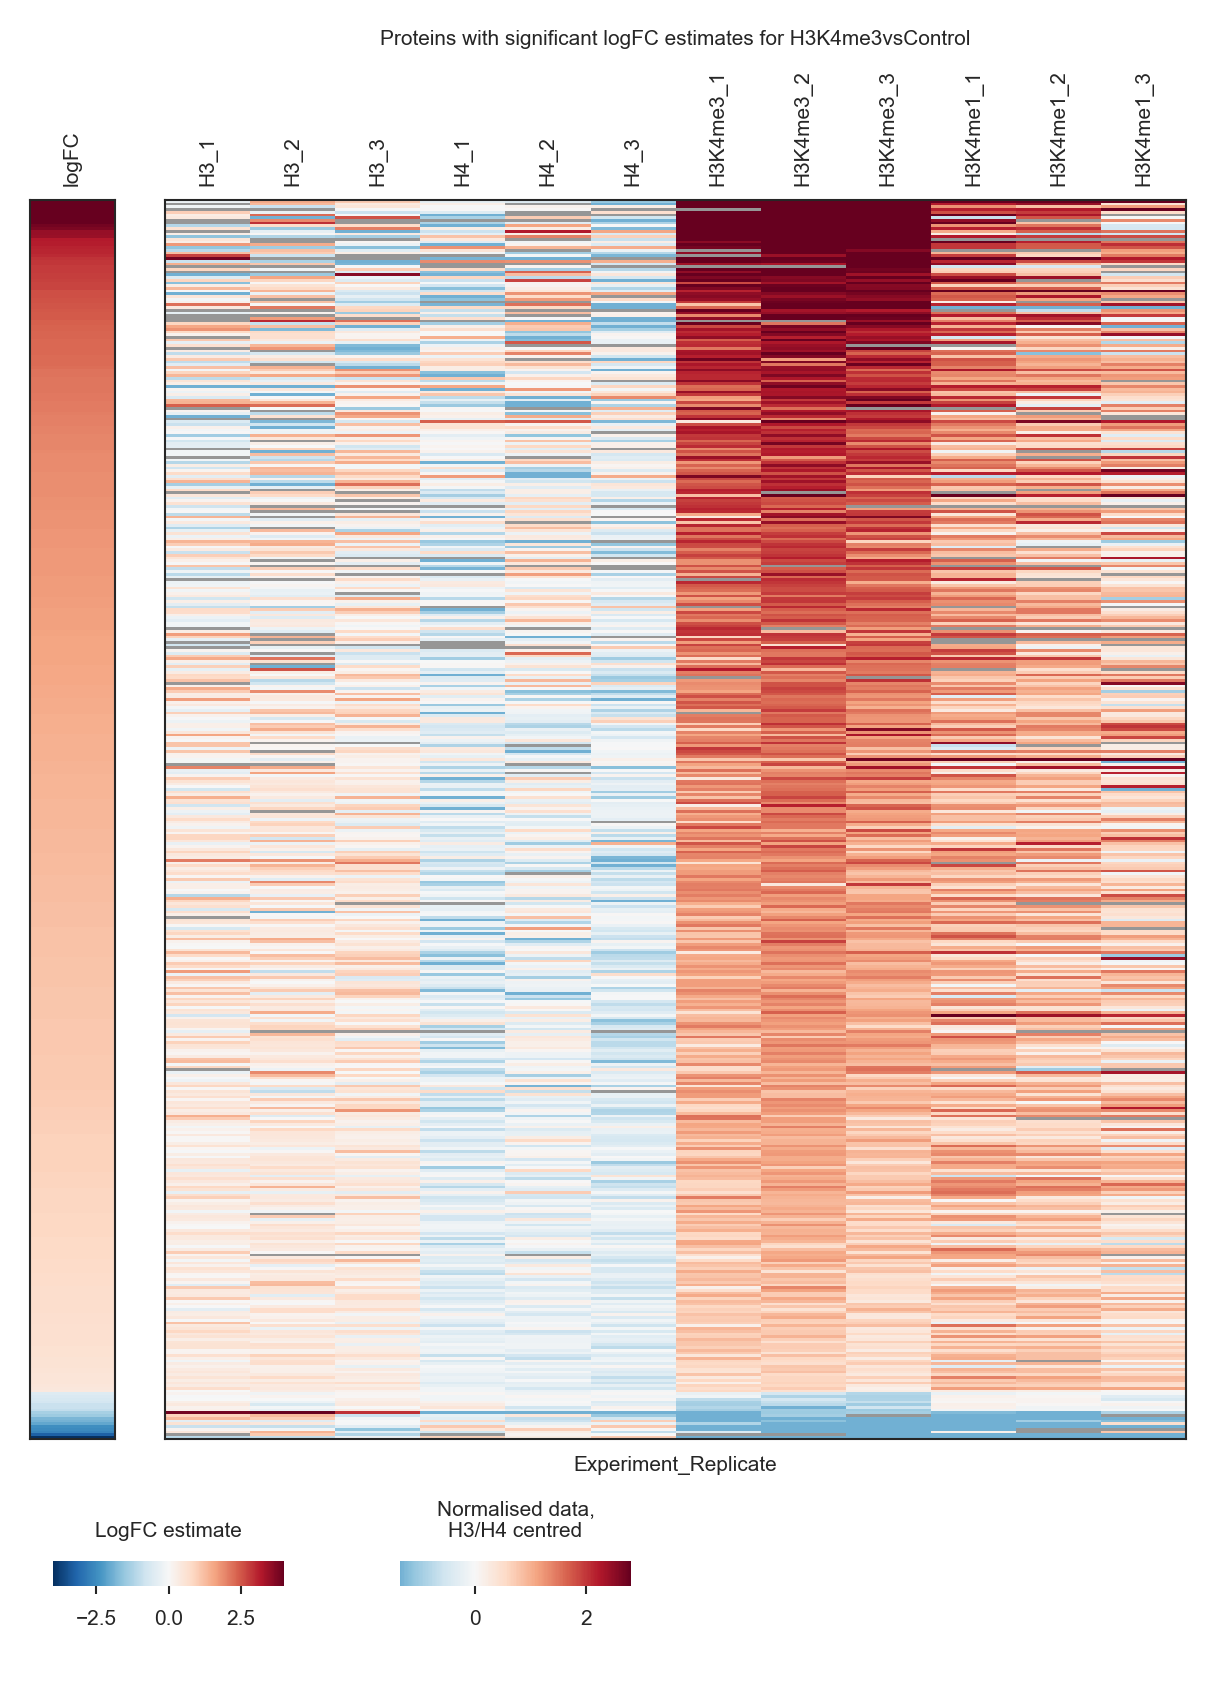

In [85]:
from matplotlib.gridspec import GridSpec
figure = plt.figure(figsize=(20*FIVE_MM_IN_INCH, 28*FIVE_MM_IN_INCH), constrained_layout=True)

gs = GridSpec(2, 2, figure=figure, width_ratios=(1, 12), height_ratios=(10,1))
ax_legends = figure.add_subplot(gs[1,:])
ax_legends.axis('off')
cax_left = ax_legends.inset_axes([0.02, 0.58, 0.2, 0.2], transform=ax_legends.transAxes)
cax_right = ax_legends.inset_axes([0.32, 0.58, 0.2, 0.2], transform=ax_legends.transAxes)

cax_left.set_title("LogFC estimate")
cax_right.set_title("Normalised data,\nH3/H4 centred")

ax_left = figure.add_subplot(gs[0, 0])
ax_right = figure.add_subplot(gs[0, 1], sharey=ax_left)


vmax = np.ceil(_significant['logFC'].abs().replace(np.inf, np.nan).dropna().quantile(0.97))
vmin = -vmax

_matrix = data_to_model.sub(data_to_model_by_experiment['Controls'].mean(axis=1), axis=0)
_matrix = _matrix.loc[_significant.index]

heatmap_right = sns.heatmap(
    _matrix, 
    cmap='RdBu_r', robust=True, center=0,
    ax=ax_right, yticklabels=0, 
    cbar=True,
    cbar_ax = cax_right,
    cbar_kws=dict(orientation='horizontal'),
    linewidth=0,
    linecolor='black',
)
heatmap_right.set_facecolor('#969696')

heatmap_left = sns.heatmap(
    _significant[['logFC']], 
    cmap='RdBu_r', 
    center=0, 
    robust=True,
    ax=ax_left, yticklabels=0, 
    cbar=True,
    cbar_ax=cax_left,
    cbar_kws=dict(orientation='horizontal'),
    linewidth=0,
    vmin=vmin, vmax=vmax,
    linecolor='black',
)

heatmap_right.xaxis.tick_top()
heatmap_right.xaxis.set_tick_params(length=0, rotation=90)

heatmap_left.xaxis.tick_top()
heatmap_left.xaxis.set_tick_params(length=0, rotation=90)

heatmap_right.yaxis.set_tick_params(length=0)
heatmap_left.yaxis.set_tick_params(length=0)

for ax in [heatmap_left, heatmap_right]:
    for spine in ax.spines:
        ax.spines[spine].set_visible(True)

for tick in heatmap_right.yaxis.get_ticklabels():
    tick.set_visible(False)

heatmap_right.set_title(f"Proteins with significant logFC estimates for {_colname}")

_fname = OUTPUT_DIRECTORY / f'05-modelling-heatmap-of-significant-proteins-for-{_colname}.pdf'
_caption = f"""

Heatmap of the significant `logFC` estimates for the {_colname} coefficient.
The proteins are sorted by the estimate, descending.

The left heatmap plots the `logFC` estimate, the colour axis limits are set to [{vmin}, {vmax}].
The right heatmap shows the data used for modelling, standardised to have zero mean of controls (H3 and H4). 

Missing values are marked in grey.
"""
plt.savefig(_fname, bbox_inches='tight', dpi=DPI)
with open(str(_fname) + '.caption.md', 'w') as f:
    f.write(_caption)
    print(_caption)


##### H3K4me3 vs H3K4me1

In [86]:
_colname = 'H3K4me3vsH3K4me1'
_significant = results.loc[results[_colname, 'significant'], _colname].sort_values(by='logFC', ascending=False)
_significant

logFC          t   P.Value  adj.P.Val         B  significant
SIN3A   5.726674  13.505960  0.000028   0.003097  2.788239         True
PHF8    5.492523  13.056130  0.000012   0.002105  4.017383         True
CALR    5.405705   5.662944  0.000206   0.009069  0.909832         True
PHF2    5.259702   8.859556  0.000020   0.002956  3.426649         True
MACF1   4.671100   4.103219  0.003395   0.044301 -1.569139         True
...          ...        ...       ...        ...       ...          ...
IGHG1  -1.499034  -4.366436  0.001362   0.027210 -1.022066         True
CDC5L  -1.854903  -4.961133  0.000563   0.015642 -0.114171         True
GOLGA3 -2.202439  -8.753877  0.000251   0.009606  1.267253         True
RPL29  -2.429045  -7.925697  0.000011   0.002105  3.846700         True
SRP14  -3.139299  -6.091969  0.000115   0.007934  1.500477         True

[80 rows x 6 columns]



Heatmap of the significant `logFC` estimates for the H3K4me3vsH3K4me1 coefficient.
The proteins are sorted by the estimate, descending.

The left heatmap plots the `logFC` estimate, the colour axis limits are set to [-6.0, 6.0].
The right heatmap shows the data used for modelling, standardised to have mean(H3K4me3 and H3K4me1) = 0. 

Missing values are marked in grey.



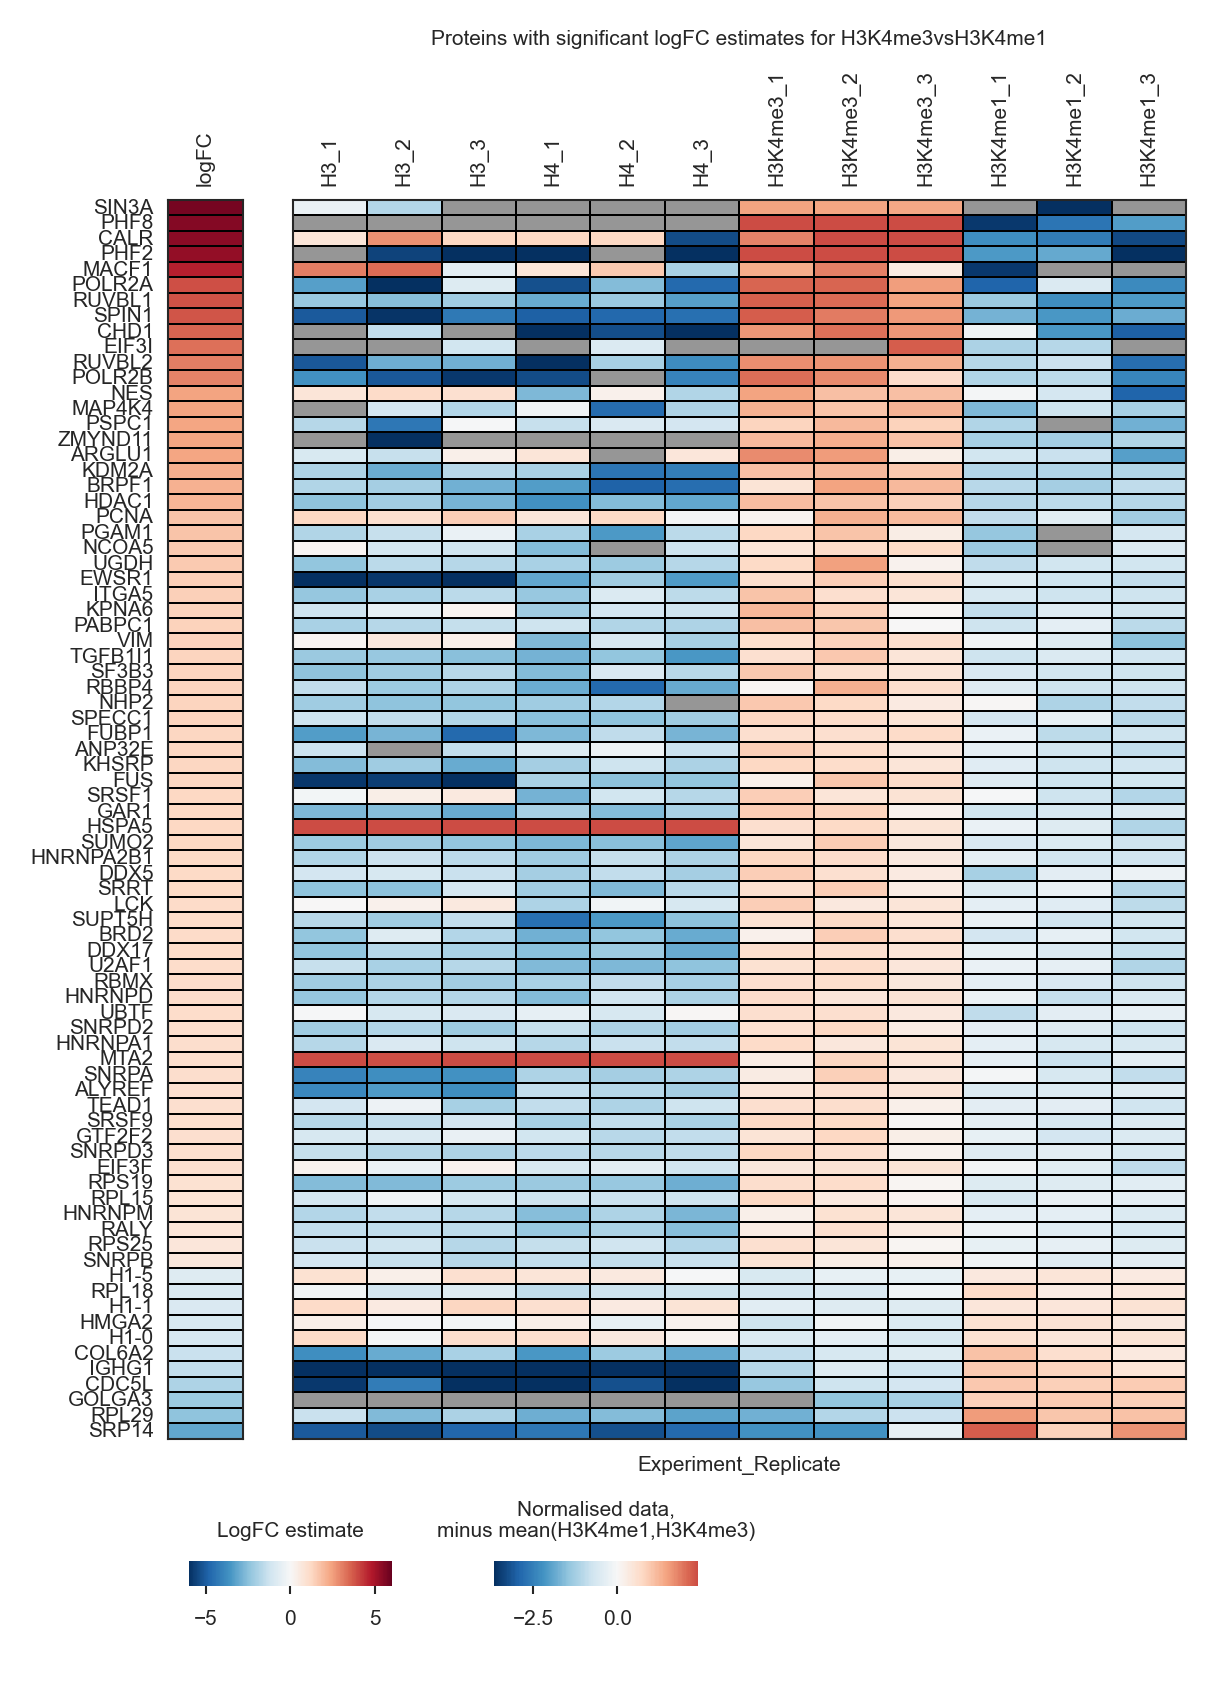

In [87]:
from matplotlib.gridspec import GridSpec
figure = plt.figure(figsize=(20*FIVE_MM_IN_INCH, 28*FIVE_MM_IN_INCH), constrained_layout=True)

gs = GridSpec(2, 2, figure=figure, width_ratios=(1, 12), height_ratios=(10,1))
ax_legends = figure.add_subplot(gs[1,:])
ax_legends.axis('off')
cax_left = ax_legends.inset_axes([0.02, 0.58, 0.2, 0.2], transform=ax_legends.transAxes)
cax_right = ax_legends.inset_axes([0.32, 0.58, 0.2, 0.2], transform=ax_legends.transAxes)

cax_left.set_title("LogFC estimate")
cax_right.set_title("Normalised data,\nminus mean(H3K4me1,H3K4me3)")

ax_left = figure.add_subplot(gs[0, 0])
ax_right = figure.add_subplot(gs[0, 1], sharey=ax_left)


vmax = np.ceil(_significant['logFC'].abs().replace(np.inf, np.nan).dropna().quantile(0.97))
vmin = -vmax

_matrix = data_to_model.sub(data_to_model_by_experiment['H3K4me1'].join(data_to_model_by_experiment['H3K4me3']).mean(axis=1), axis=0)
_matrix = _matrix.loc[_significant.index]

heatmap_right = sns.heatmap(
    _matrix, 
    cmap='RdBu_r', robust=True, center=0,
    ax=ax_right, yticklabels=1, 
    cbar=True,
    cbar_ax = cax_right,
    cbar_kws=dict(orientation='horizontal'),
    linewidth=0.1,
    linecolor='black',
)
heatmap_right.set_facecolor('#969696')
heatmap_left = sns.heatmap(
    _significant[['logFC']], 
    cmap='RdBu_r', 
    center=0, 
    robust=True,
    ax=ax_left, yticklabels=1, 
    cbar=True,
    cbar_ax=cax_left,
    cbar_kws=dict(orientation='horizontal'),
    linewidth=0.1,
    vmin=vmin, vmax=vmax,
    linecolor='black',
)

heatmap_right.xaxis.tick_top()
heatmap_right.xaxis.set_tick_params(length=0, rotation=90)

heatmap_left.xaxis.tick_top()
heatmap_left.xaxis.set_tick_params(length=0, rotation=90)

heatmap_right.yaxis.set_tick_params(length=0)
heatmap_left.yaxis.set_tick_params(length=0)

for ax in [heatmap_left, heatmap_right]:
    for spine in ax.spines:
        ax.spines[spine].set_visible(True)

for tick in heatmap_right.yaxis.get_ticklabels():
    tick.set_visible(False)

heatmap_right.set_title(f"Proteins with significant logFC estimates for {_colname}")

_fname = OUTPUT_DIRECTORY / f'05-modelling-heatmap-of-significant-proteins-for-{_colname}.pdf'
_caption = f"""

Heatmap of the significant `logFC` estimates for the {_colname} coefficient.
The proteins are sorted by the estimate, descending.

The left heatmap plots the `logFC` estimate, the colour axis limits are set to [{vmin}, {vmax}].
The right heatmap shows the data used for modelling, standardised to have mean(H3K4me3 and H3K4me1) = 0. 

Missing values are marked in grey.
"""
plt.savefig(_fname, bbox_inches='tight', dpi=DPI)
with open(str(_fname) + '.caption.md', 'w') as f:
    f.write(_caption)
    print(_caption)


## Imputation of results

While the model behaves correctly for most proteins, we want to:

1. flag the following result estimates:
   - estimates which are based only on one data point
   - imputed estimates (see below)
2. impute certain fold change estimates, namely:
   - mark proteins detected in treatments, but not detected in both controls as "infinitely enriched" (logFC=+inf)
   - mark proteins detected in both controls, but not in treatmets as "infinitely excluded" (logFC=-inf)
   - in cases where logFC could not be estimated because one (but not both!) controls are missing, calculate the logFC only from the control that is detected.

Make sure code below aligns with the contrasts matrix here:

In [88]:
contrasts_matrix_as_df

H3K4me1vsControl  H3K4me3vsControl  H3K4me3vsH3K4me1
ExperimentH4                   -0.5              -0.5               0.0
ExperimentH3                   -0.5              -0.5               0.0
ExperimentH3K4me1               1.0               0.0              -1.0
ExperimentH3K4me3               0.0               1.0               1.0

In [89]:
def flag_and_or_impute(estimate, treatments, controls):
    
    # Count number of datapoints for treatment and control
    number_non_null_treatments = (~treatments.isnull()).sum(axis=1)
    number_non_null_controls = (~controls.isnull()).sum(axis=1)
    
    # First check if our estimate is based on a single datapoint
    # This is true if treatments have only one non-null value
                                                            
    based_on_single_datapoint = number_non_null_treatments == 1
    # Or the controls have only one non-null value
    based_on_single_datapoint |= number_non_null_controls == 1
    
    # Now let's see if we need to impute some of the estimates
    
    
    # Start with copying the estimates
    imputed_estimate = estimate.copy()
    
    # Find datapoints w/o estimates
    no_estimate = estimate.isnull()
    
    # Impute positive infinities
    imputed_estimate.loc[
        # Where we have no estimate, but treatment data and no control data
        no_estimate & (number_non_null_treatments > 0)  & (number_non_null_controls == 0),
    ] = np.inf
    
    # Impute negative infinities
    imputed_estimate.loc[
        # Where we have no estimate, no treatment data but some control data
        no_estimate & (number_non_null_treatments == 0)  & (number_non_null_controls > 0),
    ] = -np.inf
    
    # Impute estimates where we have some treatment and control data, but still no estimate
    # (this happens when only one of the controls give a value, for instance)
    imputable_entries = no_estimate & (number_non_null_treatments > 0)  & (number_non_null_controls > 0)
    
    # Here we are using the results from the "sanity checks above" - that the mean estimates are
    # the same as model estimates..
    imputed_estimate.loc[
        imputable_entries,
    ] = treatments.loc[imputable_entries].mean(axis=1) - controls.loc[imputable_entries].mean(axis=1)
    
    
    # We can get the list of imputed estimates by comparing the null estimates between the imputed and (real) column:
    
    is_imputed = (~imputed_estimate.isnull()) & (no_estimate)
    
    # assert that for all non-null estimates imputed estimate is the same (i.e. that we didn't override)
    assert_array_equal(imputed_estimate.loc[~no_estimate], estimate.loc[~no_estimate])
    
    
    return pd.DataFrame({
        'logFC_imputed': imputed_estimate,
        'logFC_is_imputed': is_imputed,
        'logFC_based_on_single_datapoint': based_on_single_datapoint, 
    })
    


In [90]:
results_flags_and_imputations = {}


results_flags_and_imputations['H3K4me1vsControl'] = flag_and_or_impute(
    results['H3K4me1vsControl', 'logFC'],
    data_to_model_by_experiment['H3K4me1'],
    data_to_model_by_experiment['Controls']
)

results_flags_and_imputations['H3K4me3vsControl'] = flag_and_or_impute(
    results['H3K4me3vsControl', 'logFC'],
    data_to_model_by_experiment['H3K4me3'],
    data_to_model_by_experiment['Controls']
)

results_flags_and_imputations['H3K4me3vsH3K4me1'] = flag_and_or_impute(
    results['H3K4me3vsH3K4me1', 'logFC'],
    data_to_model_by_experiment['H3K4me3'],
    data_to_model_by_experiment['H3K4me1']
)

results_flags_and_imputations = pd.concat(results_flags_and_imputations, axis=1)
results_flags_and_imputations

H3K4me1vsControl                                                   \
           logFC_imputed logFC_is_imputed logFC_based_on_single_datapoint   
ABCF1           1.062881            False                           False   
ACBD3           1.421232             True                            True   
ACIN1           0.379968            False                            True   
ACLY           -1.150847            False                           False   
ACO1            0.704483            False                            True   
...                  ...              ...                             ...   
ZNF512          0.562529            False                           False   
ZNF512B         1.809980            False                           False   
ZNF800          1.931435            False                           False   
ZRANB2          1.235248            False                            True   
ZYX             0.768366            False                            True   

        H3K4me3vsControl                                                   \
           logFC_imputed logFC_is_imputed logFC_based_on_single_datapoint   
ABCF1           1.273823            False                           False   
ACBD3               -inf             True                           False   
ACIN1           0.980969            False                           False   
ACLY            3.098678            False                           False   
ACO1            1.217040            False                           False   
...                  ...              ...                             ...   
ZNF512          0.079178            False                           False   
ZNF512B         1.054206            False                           False   
ZNF800          3.130937            False                           False   
ZRANB2          1.092110            False                           False   
ZYX             1.403328            False                           False   

        H3K4me3vsH3K4me1                                                   
           logFC_imputed logFC_is_imputed logFC_based_on_single_datapoint  
ABCF1           0.210942            False                           False  
ACBD3               -inf             True                            True  
ACIN1           0.601001            False                            True  
ACLY            4.249525            False                           False  
ACO1            0.512557            False                            True  
...                  ...              ...                             ...  
ZNF512         -0.483352            False                           False  
ZNF512B        -0.755774            False                           False  
ZNF800          1.199502            False                           False  
ZRANB2         -0.143138            False                            True  
ZYX             0.634962            False                            True  

[929 rows x 9 columns]

In [91]:
results_flags_and_imputations['H3K4me1vsControl', 'logFC_is_imputed'].value_counts()

False    844
True      85
Name: (H3K4me1vsControl, logFC_is_imputed), dtype: int64

In [92]:
results_flags_and_imputations['H3K4me3vsControl', 'logFC_is_imputed'].value_counts()

False    845
True      84
Name: (H3K4me3vsControl, logFC_is_imputed), dtype: int64

In [93]:
results_flags_and_imputations['H3K4me3vsH3K4me1', 'logFC_is_imputed'].value_counts()

False    883
True      46
Name: (H3K4me3vsH3K4me1, logFC_is_imputed), dtype: int64

We should augment the data_comment columns

In [94]:
def comment_string(flags, column):
    
    if flags['logFC_is_imputed'] and flags['logFC_based_on_single_datapoint']:
        return f'logFC({column}) estimation failed and was imputed based on a single datapoint only'
    elif flags['logFC_is_imputed']:
        return f'logFC({column}) estimation failed and was imputed'
    elif flags['logFC_based_on_single_datapoint']:
        return f'logFC({column}) estimation was based on a single datapoint only'
    elif pd.isnull(flags['logFC_imputed']):
        return f'logFC({column}) estimation failed'
    

In [95]:
comments_results_flags = {
    col: results_flags_and_imputations[col].apply(comment_string, column=col, axis=1) for col in contrasts_matrix_as_df.columns
}

In [96]:
comments_results_flags['H3K4me3vsH3K4me1'].value_counts()

logFC(H3K4me3vsH3K4me1) estimation was based on a single datapoint only                       79
logFC(H3K4me3vsH3K4me1) estimation failed and was imputed                                     34
logFC(H3K4me3vsH3K4me1) estimation failed and was imputed based on a single datapoint only    12
logFC(H3K4me3vsH3K4me1) estimation failed                                                      4
dtype: int64

In [97]:
comments_results_flags['H3K4me1vsControl'].value_counts()

logFC(H3K4me1vsControl) estimation failed and was imputed                                     50
logFC(H3K4me1vsControl) estimation was based on a single datapoint only                       45
logFC(H3K4me1vsControl) estimation failed and was imputed based on a single datapoint only    35
logFC(H3K4me1vsControl) estimation failed                                                      6
dtype: int64

In [98]:
comments_results_flags['H3K4me3vsControl'].value_counts()

logFC(H3K4me3vsControl) estimation failed and was imputed                                     54
logFC(H3K4me3vsControl) estimation failed and was imputed based on a single datapoint only    30
logFC(H3K4me3vsControl) estimation was based on a single datapoint only                       17
logFC(H3K4me3vsControl) estimation failed                                                      2
dtype: int64

Let's check the imputation results for the representative null proteins below, a reminder of what the data to model for these proteins looks like:

In [99]:
data_to_model.loc[REPRESENTATIVE_NULLS]

Experiment_Replicate       H3_1       H3_2       H3_3       H4_1       H4_2  \
Label                                                                         
FAM98A                      NaN        NaN        NaN  16.288369  17.207787   
PHF8                        NaN        NaN        NaN        NaN        NaN   
EIF4G1                18.489189  22.331849  18.040000        NaN        NaN   
ZMYND11                     NaN  17.706539        NaN        NaN        NaN   
PSMC1                       NaN  17.412761        NaN  17.637945  18.284566   
SNTB2                 16.751258  18.714858  17.239940        NaN        NaN   
TUBB2A                17.807961  17.508858  18.851722  18.240167  16.913304   
TNNT3                 17.916977        NaN  18.110342  16.532208  16.597527   

Experiment_Replicate       H4_3  H3K4me3_1  H3K4me3_2  H3K4me3_3  H3K4me1_1  \
Label                                                                         
FAM98A                17.267267  20.181928  19.692893  19.882885  19.893043   
PHF8                        NaN  20.682903  20.790425  20.305104  14.309719   
EIF4G1                      NaN  19.045679  19.987642  18.706725  18.845305   
ZMYND11                     NaN  22.710720  22.877675  22.606844  20.331341   
PSMC1                 16.385890  18.264181  17.293807  18.641409        NaN   
SNTB2                 17.684112        NaN        NaN        NaN  17.346170   
TUBB2A                15.882954  17.830394        NaN  19.206813        NaN   
TNNT3                 17.648350        NaN        NaN        NaN        NaN   

Experiment_Replicate  H3K4me1_2  H3K4me1_3  
Label                                       
FAM98A                18.221506  18.182710  
PHF8                  15.183549  15.807594  
EIF4G1                18.802224  17.789048  
ZMYND11               20.292264  20.448003  
PSMC1                       NaN        NaN  
SNTB2                 17.268692  17.350656  
TUBB2A                      NaN        NaN  
TNNT3                       NaN        NaN

The corresponding mean estimates for the coefficients minus simple mean of controls (for comparison) where approrpiate

In [100]:
data_to_model_by_experiment['H3K4me1'].loc[REPRESENTATIVE_NULLS].mean(axis=1) - data_to_model_by_experiment['Controls'].loc[REPRESENTATIVE_NULLS].mean(axis=1)

Label
FAM98A     1.844612
PHF8            NaN
EIF4G1    -1.141487
ZMYND11    2.650663
PSMC1           NaN
SNTB2     -0.275703
TUBB2A          NaN
TNNT3           NaN
dtype: float64

In [101]:
data_to_model_by_experiment['H3K4me3'].loc[REPRESENTATIVE_NULLS].mean(axis=1) - data_to_model_by_experiment['Controls'].loc[REPRESENTATIVE_NULLS].mean(axis=1)

Label
FAM98A     2.998094
PHF8            NaN
EIF4G1    -0.373664
ZMYND11    5.025207
PSMC1      0.636175
SNTB2           NaN
TUBB2A     0.984443
TNNT3           NaN
dtype: float64

The imputed estimates are shown below:

In [102]:
results_flags_and_imputations.loc[REPRESENTATIVE_NULLS].loc(axis=1)[:, 'logFC_imputed']

H3K4me1vsControl H3K4me3vsControl H3K4me3vsH3K4me1
           logFC_imputed    logFC_imputed    logFC_imputed
FAM98A          1.844612         2.998094         1.153482
PHF8                 inf              inf         5.492523
EIF4G1         -1.141487        -0.373664         0.767823
ZMYND11         2.650663         5.025207         2.374543
PSMC1               -inf         0.642019              inf
SNTB2          -0.304559             -inf             -inf
TUBB2A              -inf         0.984443              inf
TNNT3               -inf             -inf              NaN

Please verify that they are intuitively correct:

1. `PHF8` should have infinite enrichments for `H3K4me1vsControl` and `H3K4me3vsControl`, as it has no estimate for `ExperimentH3` and `ExperimentH4` coefficients (as _all_ values in the two controls are missing), but is detected in `H3K4me3` and `H3K4me1` experiments. 
2. `FAM98A`, `EIF4G1` and `ZMYND11` should have values imputed with fold change against simple mean of controls as they have estimates for one control (H3 or H4) but not both. 
3. `H3K4me1vsControl` should be -inf for `PSMC1` and `TUBB2A` , while `H3K4me3vsH3K4me1` should be +inf for these proteins as they have no estimate for `ExperimentH3K4me1`. Similarly impute `SNTB2` to have `H3K4me3vsControl` and `H3K4me3vsH3K4me1`  estimates of negative infinity as this protein has no estimate for `ExperimentH3K4me3`.
4. Finally, since `TNN3` has estimates only for the `Control`-associated samples, it should have `H3K4me1vsControl` and `H3K4me3vsControl` imputed to infinity, but no estimate for `H3K4me3vsH3K4me1`.

### Heatmaps of imputed proteins

#### H3K4me3vsControl

In [103]:
_colname = 'H3K4me3vsControl'
_imputed = results_flags_and_imputations.loc[results_flags_and_imputations[_colname, 'logFC_is_imputed'], _colname].sort_values(by='logFC_imputed', ascending=False)
_imputed

logFC_imputed  logFC_is_imputed  logFC_based_on_single_datapoint
SRP9                inf              True                            False
PHF8                inf              True                            False
KIF5B               inf              True                            False
SRSF4               inf              True                            False
CRIP2               inf              True                            False
...                 ...               ...                              ...
CTHRC1             -inf              True                            False
CPNE1              -inf              True                            False
APOBEC3C           -inf              True                            False
AP2A2              -inf              True                            False
NIBAN2             -inf              True                            False

[84 rows x 3 columns]



Heatmap of the imputed `logFC` estimates for the H3K4me3vsControl coefficient.
The proteins are sorted by the estimate, descending.

The left heatmap plots the imputed `logFC` estimate, the colour axis limits are set to [-8.0, 8.0].
Note that some imputed logFC estimates are infinite (which may be both positive or negative). Such points are displayed at the darkest shade of respective colour.

The right heatmap shows the data used for modelling in viridis colour scale. 
Note that all imptued estimates were infered from partial data only.



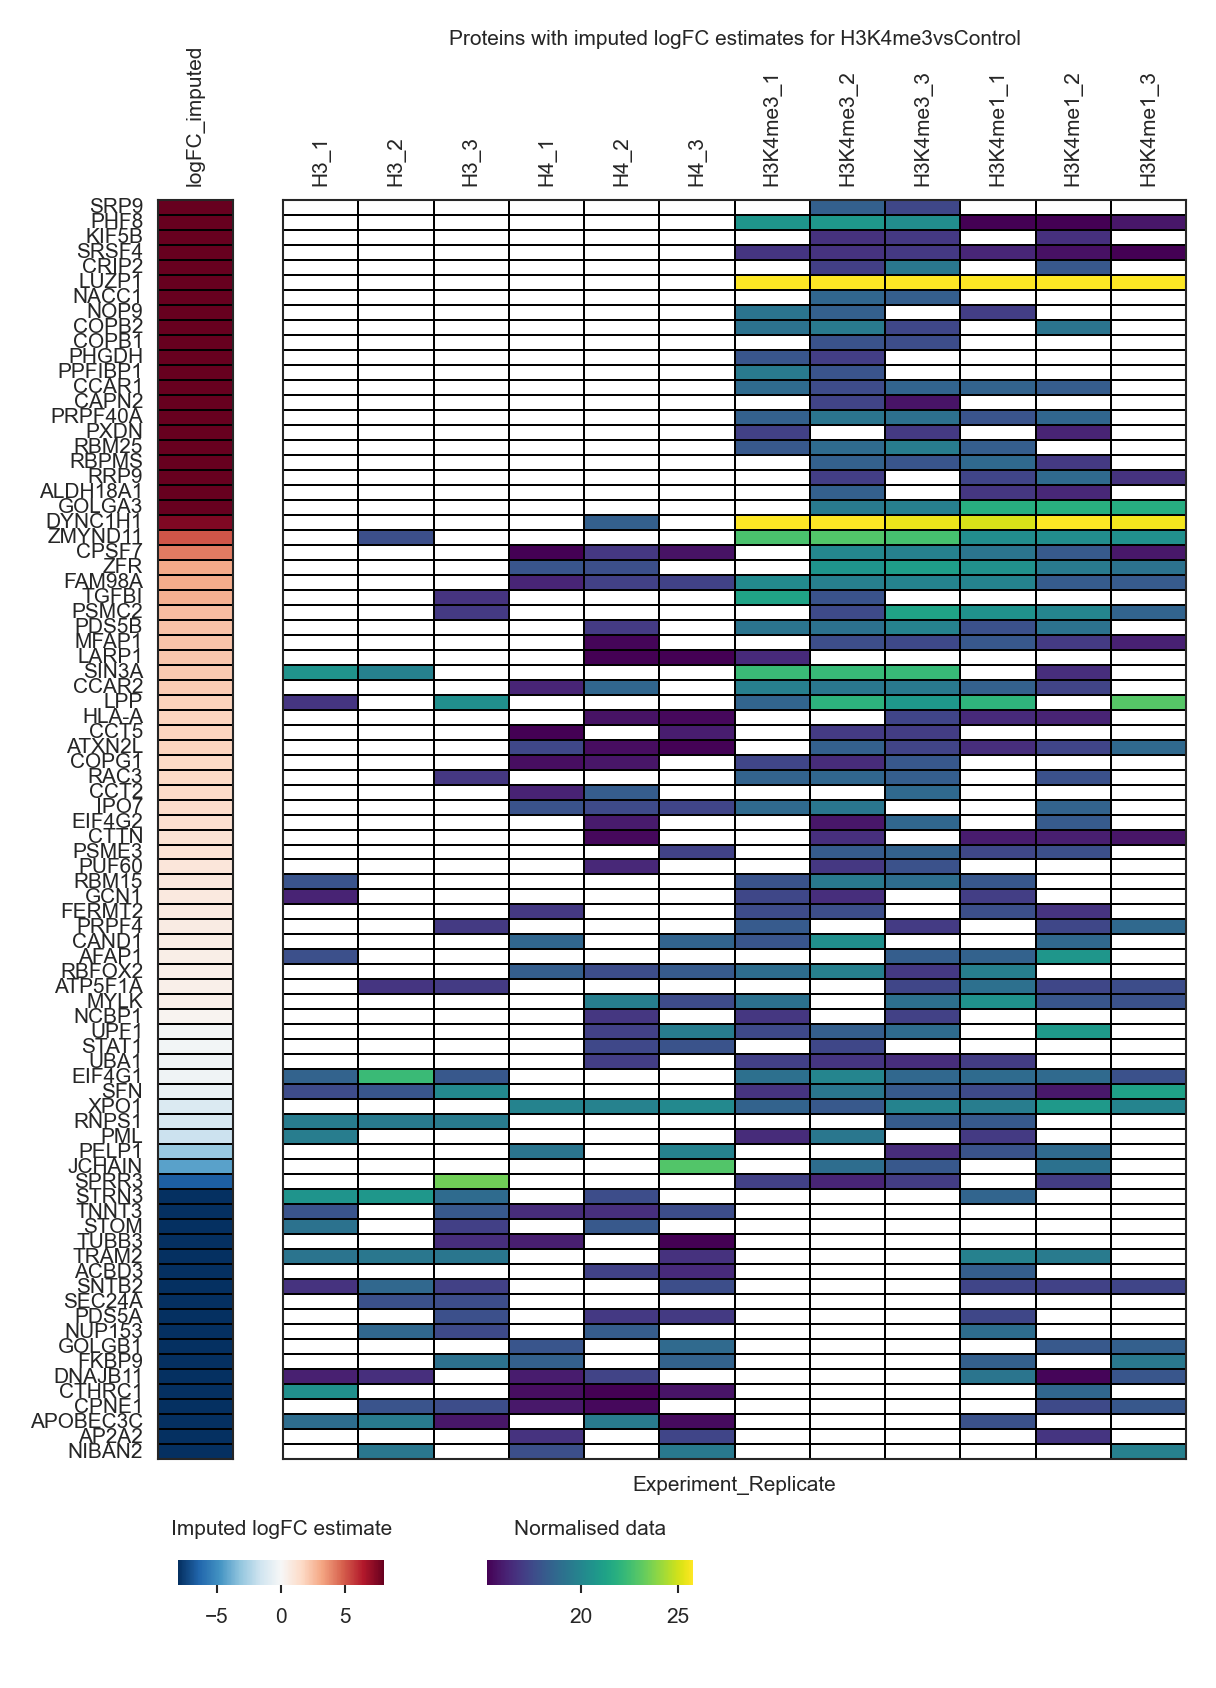

In [104]:
from matplotlib.gridspec import GridSpec
figure = plt.figure(figsize=(20*FIVE_MM_IN_INCH, 28*FIVE_MM_IN_INCH), constrained_layout=True)

gs = GridSpec(2, 2, figure=figure, width_ratios=(1, 12), height_ratios=(10,1))
ax_legends = figure.add_subplot(gs[1,:])
ax_legends.axis('off')
cax_left = ax_legends.inset_axes([0.02, 0.58, 0.2, 0.2], transform=ax_legends.transAxes)
cax_right = ax_legends.inset_axes([0.32, 0.58, 0.2, 0.2], transform=ax_legends.transAxes)

cax_left.set_title("Imputed logFC estimate")
cax_right.set_title("Normalised data")

ax_left = figure.add_subplot(gs[0, 0])
ax_right = figure.add_subplot(gs[0, 1], sharey=ax_left)


vmax = np.ceil(_imputed['logFC_imputed'].abs().replace(np.inf, np.nan).dropna().max())
vmin = -vmax

heatmap_right = sns.heatmap(
    data_to_model.loc[_imputed.index], 
    cmap='viridis', robust=True, 
    ax=ax_right, yticklabels=1, 
    cbar=True,
    cbar_ax = cax_right,
    cbar_kws=dict(orientation='horizontal'),
    linewidth=0.1,
    linecolor='black',
)
heatmap_left = sns.heatmap(
    _imputed[['logFC_imputed']].replace(-np.inf, vmin -1).replace(np.inf, vmax + 1), 
    cmap='RdBu_r', 
    center=0, 
    vmin=vmin, vmax=vmax,
    ax=ax_left, yticklabels=1, 
    cbar=True,
    cbar_ax=cax_left,
    cbar_kws=dict(orientation='horizontal'),
    linewidth=0.1,
    linecolor='black',
)

heatmap_right.xaxis.tick_top()
heatmap_right.xaxis.set_tick_params(length=0, rotation=90)

heatmap_left.xaxis.tick_top()
heatmap_left.xaxis.set_tick_params(length=0, rotation=90)

heatmap_right.yaxis.set_tick_params(length=0)
heatmap_left.yaxis.set_tick_params(length=0)

for ax in [heatmap_left, heatmap_right]:
    for spine in ax.spines:
        ax.spines[spine].set_visible(True)

for tick in heatmap_right.yaxis.get_ticklabels():
    tick.set_visible(False)

heatmap_right.set_title(f"Proteins with imputed logFC estimates for {_colname}")

_fname = OUTPUT_DIRECTORY / f'06-modelling-imputed-values-for-{_colname}.pdf'
_caption = f"""

Heatmap of the imputed `logFC` estimates for the {_colname} coefficient.
The proteins are sorted by the estimate, descending.

The left heatmap plots the imputed `logFC` estimate, the colour axis limits are set to [{vmin}, {vmax}].
Note that some imputed logFC estimates are infinite (which may be both positive or negative). Such points are displayed at the darkest shade of respective colour.

The right heatmap shows the data used for modelling in viridis colour scale. 
Note that all imptued estimates were infered from partial data only.
"""
plt.savefig(_fname, bbox_inches='tight', dpi=DPI)
with open(str(_fname) + '.caption.md', 'w') as f:
    f.write(_caption)
    print(_caption)


#### H3K4me1vsControl

In [105]:
_colname = 'H3K4me1vsControl'
_imputed = results_flags_and_imputations.loc[results_flags_and_imputations[_colname, 'logFC_is_imputed'], _colname].sort_values(by='logFC_imputed', ascending=False)
_imputed

logFC_imputed  logFC_is_imputed  logFC_based_on_single_datapoint
NOP9              inf              True                             True
GOLGA3            inf              True                            False
HRG               inf              True                            False
KIF5B             inf              True                             True
CRIP2             inf              True                             True
...               ...               ...                              ...
LPL              -inf              True                            False
PUF60            -inf              True                             True
PRPF31           -inf              True                            False
ING1             -inf              True                            False
SMTN             -inf              True                            False

[85 rows x 3 columns]



Heatmap of the imputed `logFC` estimates for the H3K4me1vsControl coefficient.
The proteins are sorted by the estimate, descending.

The left heatmap plots the imputed `logFC` estimate, the colour axis limits are set to [-8.0, 8.0].
Note that some imputed logFC estimates are infinite (which may be both positive or negative). Such points are displayed at the darkest shade of respective colour.

The right heatmap shows the data used for modelling in viridis colour scale. 
Note that all imptued estimates were infered from partial data only.



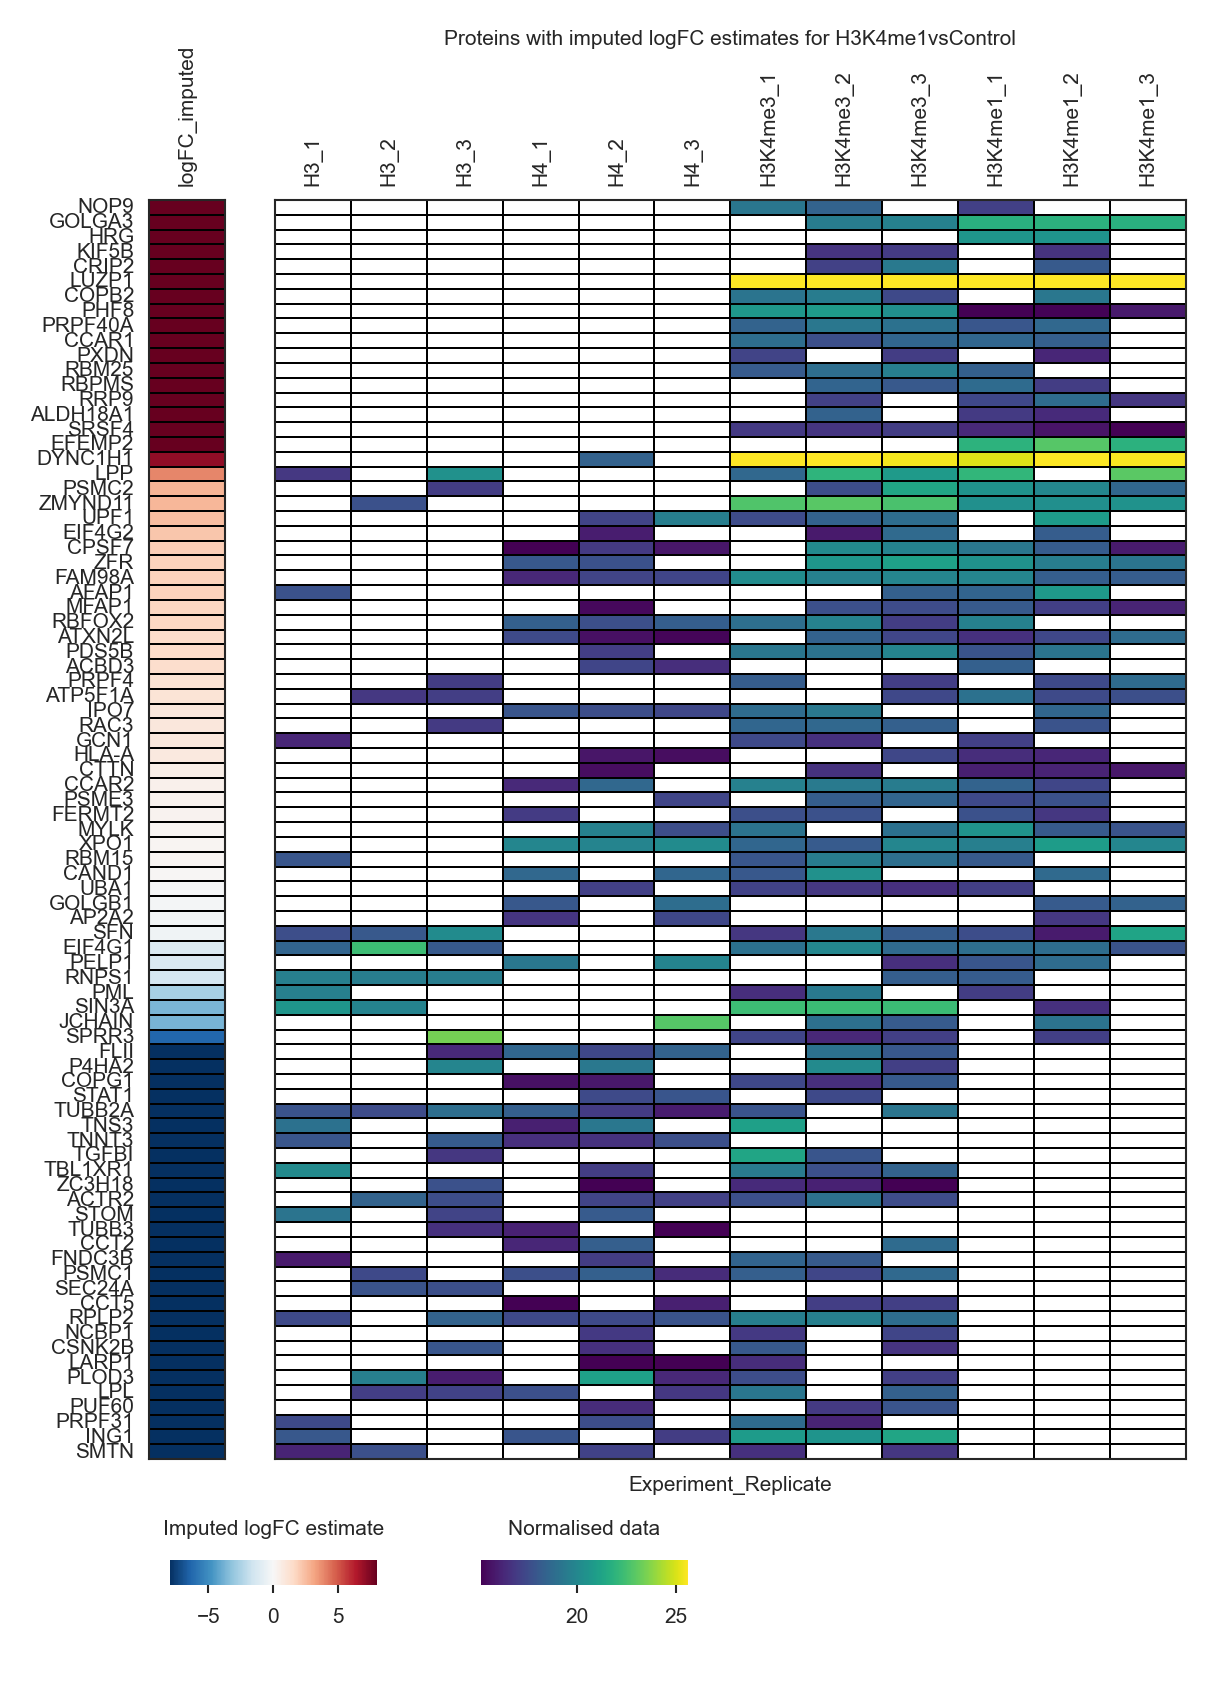

In [106]:
from matplotlib.gridspec import GridSpec
figure = plt.figure(figsize=(20*FIVE_MM_IN_INCH, 28*FIVE_MM_IN_INCH), constrained_layout=True)

gs = GridSpec(2, 2, figure=figure, width_ratios=(1, 12), height_ratios=(10,1))
ax_legends = figure.add_subplot(gs[1,:])
ax_legends.axis('off')
cax_left = ax_legends.inset_axes([0.02, 0.58, 0.2, 0.2], transform=ax_legends.transAxes)
cax_right = ax_legends.inset_axes([0.32, 0.58, 0.2, 0.2], transform=ax_legends.transAxes)

cax_left.set_title("Imputed logFC estimate")
cax_right.set_title("Normalised data")

ax_left = figure.add_subplot(gs[0, 0])
ax_right = figure.add_subplot(gs[0, 1], sharey=ax_left)


vmax = np.ceil(_imputed['logFC_imputed'].abs().replace(np.inf, np.nan).dropna().max())
vmin = -vmax

heatmap_right = sns.heatmap(
    data_to_model.loc[_imputed.index], 
    cmap='viridis', robust=True, 
    ax=ax_right, yticklabels=1, 
    cbar=True,
    cbar_ax = cax_right,
    cbar_kws=dict(orientation='horizontal'),
    linewidth=0.1,
    linecolor='black',
)
heatmap_left = sns.heatmap(
    _imputed[['logFC_imputed']].replace(-np.inf, vmin -1).replace(np.inf, vmax + 1), 
    cmap='RdBu_r', 
    center=0, 
    vmin=vmin, vmax=vmax,
    ax=ax_left, yticklabels=1, 
    cbar=True,
    cbar_ax=cax_left,
    cbar_kws=dict(orientation='horizontal'),
    linewidth=0.1,
    linecolor='black',
)

heatmap_right.xaxis.tick_top()
heatmap_right.xaxis.set_tick_params(length=0, rotation=90)

heatmap_left.xaxis.tick_top()
heatmap_left.xaxis.set_tick_params(length=0, rotation=90)

heatmap_right.yaxis.set_tick_params(length=0)
heatmap_left.yaxis.set_tick_params(length=0)

for ax in [heatmap_left, heatmap_right]:
    for spine in ax.spines:
        ax.spines[spine].set_visible(True)

for tick in heatmap_right.yaxis.get_ticklabels():
    tick.set_visible(False)

heatmap_right.set_title(f"Proteins with imputed logFC estimates for {_colname}")

_fname = OUTPUT_DIRECTORY / f'06-modelling-imputed-values-for-{_colname}.pdf'
_caption = f"""

Heatmap of the imputed `logFC` estimates for the {_colname} coefficient.
The proteins are sorted by the estimate, descending.

The left heatmap plots the imputed `logFC` estimate, the colour axis limits are set to [{vmin}, {vmax}].
Note that some imputed logFC estimates are infinite (which may be both positive or negative). Such points are displayed at the darkest shade of respective colour.

The right heatmap shows the data used for modelling in viridis colour scale. 
Note that all imptued estimates were infered from partial data only.
"""
plt.savefig(_fname, bbox_inches='tight', dpi=DPI)
with open(str(_fname) + '.caption.md', 'w') as f:
    f.write(_caption)
    print(_caption)


#### H3K4me3vsH3K4me1

In [107]:
_colname = 'H3K4me3vsH3K4me1'
_imputed = results_flags_and_imputations.loc[results_flags_and_imputations[_colname, 'logFC_is_imputed'], _colname].sort_values(by='logFC_imputed', ascending=False)
_imputed

logFC_imputed  logFC_is_imputed  logFC_based_on_single_datapoint
NCBP1               inf              True                            False
LARP1               inf              True                             True
NACC1               inf              True                            False
ACTR2               inf              True                            False
P4HA2               inf              True                            False
PHGDH               inf              True                            False
PLOD3               inf              True                            False
PPFIBP1             inf              True                            False
PRPF31              inf              True                            False
PSMC1               inf              True                            False
PUF60               inf              True                            False
RPLP2               inf              True                            False
SMTN                inf              True                            False
SRP9                inf              True                            False
STAT1               inf              True                             True
TBL1XR1             inf              True                            False
TGFBI               inf              True                            False
TNS3                inf              True                             True
TUBB2A              inf              True                            False
LPL                 inf              True                            False
ZC3H18              inf              True                            False
ING1                inf              True                            False
FLII                inf              True                            False
CAPN2               inf              True                            False
CCT2                inf              True                             True
CCT5                inf              True                            False
COPB1               inf              True                            False
COPG1               inf              True                            False
CSNK2B              inf              True                            False
FNDC3B              inf              True                            False
NUP153             -inf              True                             True
AP2A2              -inf              True                             True
TRAM2              -inf              True                            False
APOBEC3C           -inf              True                             True
GOLGB1             -inf              True                            False
NIBAN2             -inf              True                             True
STRN3              -inf              True                             True
FKBP9              -inf              True                            False
EFEMP2             -inf              True                            False
SNTB2              -inf              True                            False
PDS5A              -inf              True                             True
CPNE1              -inf              True                            False
HRG                -inf              True                            False
CTHRC1             -inf              True                             True
DNAJB11            -inf              True                            False
ACBD3              -inf              True                             True



Heatmap of the imputed `logFC` estimates for the H3K4me3vsH3K4me1 coefficient.
The proteins are sorted by the estimate, descending.

The left heatmap plots the imputed `logFC` estimate, the colour axis limits are set to [-1.0, 1.0].
Note that some imputed logFC estimates are infinite (which may be both positive or negative). Such points are displayed at the darkest shade of respective colour.

The right heatmap shows the data used for modelling in viridis colour scale. 
Note that all imptued estimates were infered from partial data only.



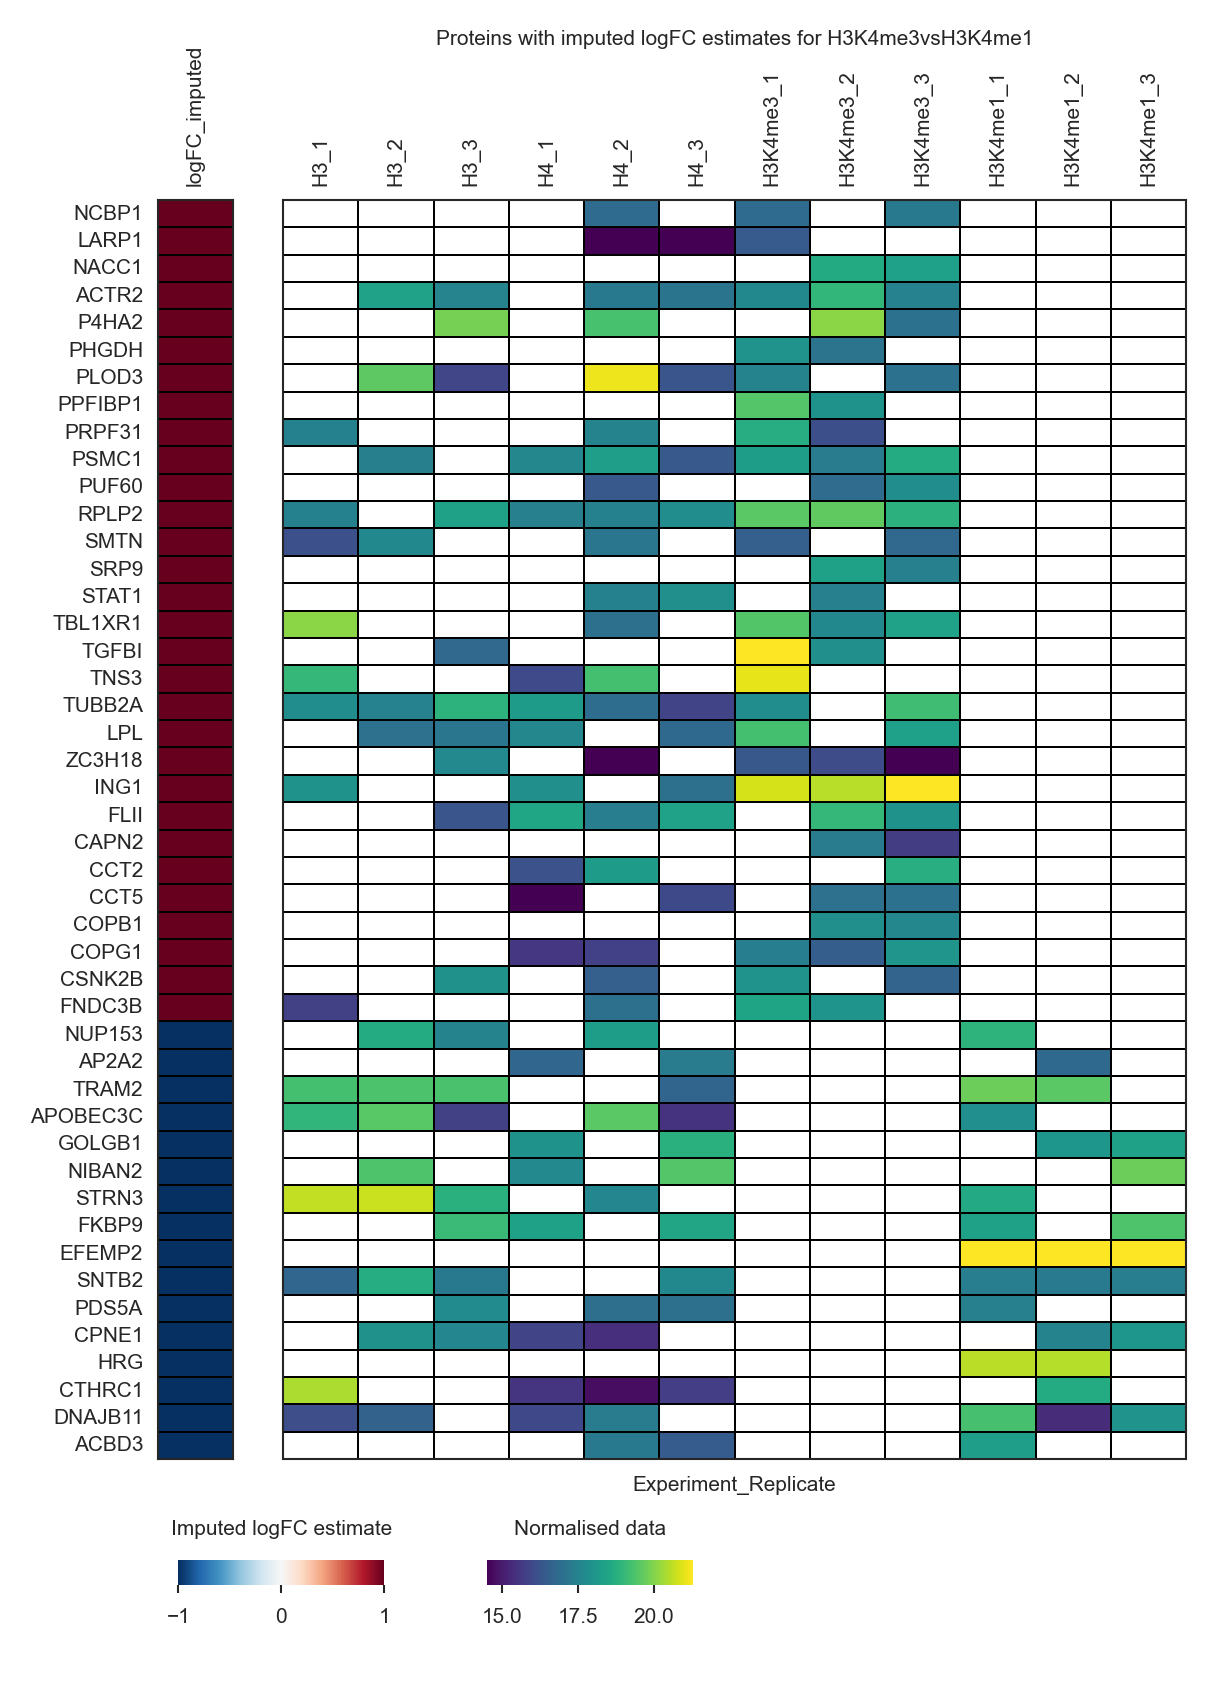

In [108]:
from matplotlib.gridspec import GridSpec
figure = plt.figure(figsize=(20*FIVE_MM_IN_INCH, 28*FIVE_MM_IN_INCH), constrained_layout=True)

gs = GridSpec(2, 2, figure=figure, width_ratios=(1, 12), height_ratios=(10,1))
ax_legends = figure.add_subplot(gs[1,:])
ax_legends.axis('off')
cax_left = ax_legends.inset_axes([0.02, 0.58, 0.2, 0.2], transform=ax_legends.transAxes)
cax_right = ax_legends.inset_axes([0.32, 0.58, 0.2, 0.2], transform=ax_legends.transAxes)

cax_left.set_title("Imputed logFC estimate")
cax_right.set_title("Normalised data")

ax_left = figure.add_subplot(gs[0, 0])
ax_right = figure.add_subplot(gs[0, 1], sharey=ax_left)


vmax = np.ceil(_imputed['logFC_imputed'].abs().replace(np.inf, np.nan).dropna().max())
if pd.isnull(vmax):
    vmax = 1.0

vmin = -vmax

heatmap_right = sns.heatmap(
    data_to_model.loc[_imputed.index], 
    cmap='viridis', robust=True, 
    ax=ax_right, yticklabels=1, 
    cbar=True,
    cbar_ax = cax_right,
    cbar_kws=dict(orientation='horizontal'),
    linewidth=0.1,
    linecolor='black',
)
heatmap_left = sns.heatmap(
    _imputed[['logFC_imputed']].replace(-np.inf, vmin -1).replace(np.inf, vmax + 1), 
    cmap='RdBu_r', 
    center=0, 
    vmin=vmin, vmax=vmax,
    ax=ax_left, yticklabels=1, 
    cbar=True,
    cbar_ax=cax_left,
    cbar_kws=dict(orientation='horizontal'),
    linewidth=0.1,
    linecolor='black',
)

heatmap_right.xaxis.tick_top()
heatmap_right.xaxis.set_tick_params(length=0, rotation=90)

heatmap_left.xaxis.tick_top()
heatmap_left.xaxis.set_tick_params(length=0, rotation=90)

heatmap_right.yaxis.set_tick_params(length=0)
heatmap_left.yaxis.set_tick_params(length=0)

for ax in [heatmap_left, heatmap_right]:
    for spine in ax.spines:
        ax.spines[spine].set_visible(True)

for tick in heatmap_right.yaxis.get_ticklabels():
    tick.set_visible(False)

heatmap_right.set_title(f"Proteins with imputed logFC estimates for {_colname}")

_fname = OUTPUT_DIRECTORY / f'06-modelling-imputed-values-for-{_colname}.pdf'
_caption = f"""

Heatmap of the imputed `logFC` estimates for the {_colname} coefficient.
The proteins are sorted by the estimate, descending.

The left heatmap plots the imputed `logFC` estimate, the colour axis limits are set to [{vmin}, {vmax}].
Note that some imputed logFC estimates are infinite (which may be both positive or negative). Such points are displayed at the darkest shade of respective colour.

The right heatmap shows the data used for modelling in viridis colour scale. 
Note that all imptued estimates were infered from partial data only.
"""
plt.savefig(_fname, bbox_inches='tight', dpi=DPI)
with open(str(_fname) + '.caption.md', 'w') as f:
    f.write(_caption)
    print(_caption)


## Output

At this point this notebook is finished, so it's time to collect the results and visualise


Let's start with a combined "comment column",
which joins the filtering comment and the flag comments

In [109]:
full_comments = pd.DataFrame({'filter_comment': data_comment, 'norm_comment': comments_norm, **comments_results_flags})
full_comments

filter_comment norm_comment  \
ABCF1              NaN          NaN   
ACBD3              NaN          NaN   
ACIN1              NaN          NaN   
ACLY               NaN          NaN   
ACO1               NaN          NaN   
...                ...          ...   
ZNF512             NaN          NaN   
ZNF512B            NaN          NaN   
ZNF800             NaN          NaN   
ZRANB2             NaN          NaN   
ZYX                NaN          NaN   

                                          H3K4me1vsControl  \
ABCF1                                                 None   
ACBD3    logFC(H3K4me1vsControl) estimation failed and ...   
ACIN1    logFC(H3K4me1vsControl) estimation was based o...   
ACLY                                                  None   
ACO1     logFC(H3K4me1vsControl) estimation was based o...   
...                                                    ...   
ZNF512                                                None   
ZNF512B                                               None   
ZNF800                                                None   
ZRANB2   logFC(H3K4me1vsControl) estimation was based o...   
ZYX      logFC(H3K4me1vsControl) estimation was based o...   

                                          H3K4me3vsControl  \
ABCF1                                                 None   
ACBD3    logFC(H3K4me3vsControl) estimation failed and ...   
ACIN1                                                 None   
ACLY                                                  None   
ACO1                                                  None   
...                                                    ...   
ZNF512                                                None   
ZNF512B                                               None   
ZNF800                                                None   
ZRANB2                                                None   
ZYX                                                   None   

                                          H3K4me3vsH3K4me1  
ABCF1                                                 None  
ACBD3    logFC(H3K4me3vsH3K4me1) estimation failed and ...  
ACIN1    logFC(H3K4me3vsH3K4me1) estimation was based o...  
ACLY                                                  None  
ACO1     logFC(H3K4me3vsH3K4me1) estimation was based o...  
...                                                    ...  
ZNF512                                                None  
ZNF512B                                               None  
ZNF800                                                None  
ZRANB2   logFC(H3K4me3vsH3K4me1) estimation was based o...  
ZYX      logFC(H3K4me3vsH3K4me1) estimation was based o...  

[1046 rows x 5 columns]

Use a separator of ';'

In [110]:
full_comments = full_comments.apply(lambda x: '; '.join(x.dropna()), axis=1)
full_comments

ABCF1                                                       
ACBD3      logFC(H3K4me1vsControl) estimation failed and ...
ACIN1      logFC(H3K4me1vsControl) estimation was based o...
ACLY                                                        
ACO1       logFC(H3K4me1vsControl) estimation was based o...
                                 ...                        
ZNF512                                                      
ZNF512B                                                     
ZNF800                                                      
ZRANB2     logFC(H3K4me1vsControl) estimation was based o...
ZYX        logFC(H3K4me1vsControl) estimation was based o...
Length: 1046, dtype: object

In [111]:
full_comments.value_counts()

                                                                                                                                                                                                                                                                   765
Insufficient number of non-null values                                                                                                                                                                                                                             117
logFC(H3K4me1vsControl) estimation was based on a single datapoint only; logFC(H3K4me3vsH3K4me1) estimation was based on a single datapoint only                                                                                                                    36
logFC(H3K4me1vsControl) estimation failed and was imputed; logFC(H3K4me3vsControl) estimation failed and was imputed                                                                                               

Now gather all the data that we would need to save:

In [112]:
_comments = pd.DataFrame(full_comments.copy())
_comments.columns = pd.MultiIndex.from_tuples([('comment', 'comment')])

_coef_estimates = coef_estimates_design.copy()
_coef_estimates.columns = pd.MultiIndex.from_tuples([('coefficient_estimates', c) for c in _coef_estimates.columns])

_norm_data = data_numeric_log2_normalised.copy()
_norm_data.columns = pd.MultiIndex.from_tuples([('normalised_data', c) for c in _norm_data.columns])

In [113]:
full_results = _norm_data.join(_comments).join(results).join(_coef_estimates).join(results_flags_and_imputations)
full_results

normalised_data                                                         \
                  H3_1       H3_2       H3_3       H4_1       H4_2       H4_3   
Label                                                                           
GBE1               NaN        NaN        NaN        NaN  15.376077        NaN   
EFTUD2       17.529162  17.503392  16.539555  16.318518  18.794640  14.775579   
YWHAB        17.500332  18.489014  19.051719  17.253775  18.609681  17.226879   
YWHAE        17.978340  17.660600        NaN  17.732780  17.729887  18.127845   
YWHAH        26.469061  27.598393  28.196840  25.482620  26.254161  25.594706   
...                ...        ...        ...        ...        ...        ...   
ZNF800       20.116863  19.957744  18.762092  17.107449  19.010215  18.496467   
ZRANB2       16.632241  17.698422        NaN        NaN  17.080012  16.884347   
ZFR                NaN        NaN        NaN  17.975881  17.715118        NaN   
AZGP1        22.342637  22.993326  23.047930  21.558046  21.965314  21.835160   
ZYX          17.617100  18.514837  18.768639  17.321350  19.223079        NaN   

                                                    ... coefficient_estimates  \
        H3K4me3_1  H3K4me3_2  H3K4me3_3  H3K4me1_1  ...     ExperimentH3K4me3   
Label                                               ...                         
GBE1          NaN  17.325027        NaN        NaN  ...                   NaN   
EFTUD2  20.041195  19.531290  19.353650  20.006004  ...             19.642045   
YWHAB   19.144883  20.010644  19.970746  19.625605  ...             19.708758   
YWHAE   19.045548  19.793507  19.774640  18.833497  ...             19.537898   
YWHAH   27.232678  27.759508  27.235605  25.612516  ...             27.409264   
...           ...        ...        ...        ...  ...                   ...   
ZNF800  22.306802  21.887212  21.924212  20.914221  ...             22.039409   
ZRANB2  17.373421  18.116876  19.007300  18.309003  ...             18.165866   
ZFR           NaN  20.647178  21.060608  20.466560  ...             20.853893   
AZGP1   22.980912  23.683567  23.236657  23.185682  ...             23.300378   
ZYX     19.094547  20.335859  19.638187  19.054569  ...             19.689531   

       H3K4me1vsControl                                                   \
          logFC_imputed logFC_is_imputed logFC_based_on_single_datapoint   
Label                                                                      
GBE1                NaN              NaN                             NaN   
EFTUD2         1.779547            False                           False   
YWHAB          0.496726            False                           False   
YWHAE          0.831718            False                           False   
YWHAH         -0.254029            False                           False   
...                 ...              ...                             ...   
ZNF800         1.931435            False                           False   
ZRANB2         1.235248            False                            True   
ZFR            1.866238             True                           False   
AZGP1          1.158054            False                           False   
ZYX            0.768366            False                            True   

       H3K4me3vsControl                                                   \
          logFC_imputed logFC_is_imputed logFC_based_on_single_datapoint   
Label                                                                      
GBE1                NaN              NaN                             NaN   
EFTUD2         2.731904            False                           False   
YWHAB          1.686858            False                           False   
YWHAE          1.696411            False                           False   
YWHAH          0.809967            False                           False   
...                 ...              ...                        

For storage, remove multi-index:

In [114]:
full_results_no_multiindex = full_results.copy()
full_results_no_multiindex.columns = ['__'.join(c) for c in full_results.columns]

In [115]:
full_results_no_multiindex.to_csv(OUTPUT_DIRECTORY / '07-output-full_results.csv')

## Visualisation

Finally, plot the key results

### Venn diagrams

In [116]:
from matplotlib_venn import venn3_unweighted



Venn diagram of proteins whose fold change estimates are statistically non zero. (limma, at FDR 0.05, BH correction).
Note that the venn diagram areas are not representative of the counts in the slices.



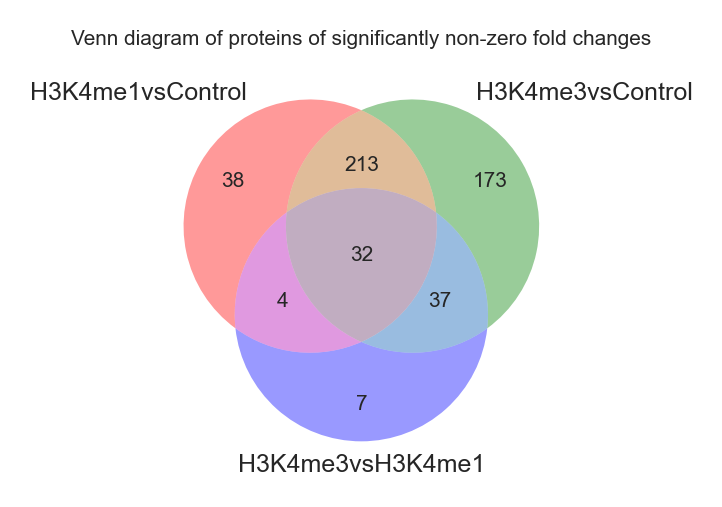

In [117]:
ax = plt.gca()

set_labels = coef_estimates_contrasts.columns
set_members = [ set(full_results[full_results[c, 'significant'].fillna(False)].index) for c in set_labels ]

venn3_unweighted(set_members, set_labels=set_labels)

ax.set_title("Venn diagram of proteins of significantly non-zero fold changes")


_fname = OUTPUT_DIRECTORY / f'08-venn-diagram-significant.pdf'
_caption = f"""

Venn diagram of proteins whose fold change estimates are statistically non zero. (limma, at FDR {FDR_THRESHOLD}, BH correction).
Note that the venn diagram areas are not representative of the counts in the slices.
"""
plt.savefig(_fname, bbox_inches='tight', dpi=DPI)
with open(str(_fname) + '.caption.md', 'w') as f:
    f.write(_caption)
    print(_caption)



Venn diagram of proteins whose fold change estimates are statistically non zero. (limma, at FDR 0.05, BH correction).
Note that the venn diagram areas are not representative of the counts in the slices.



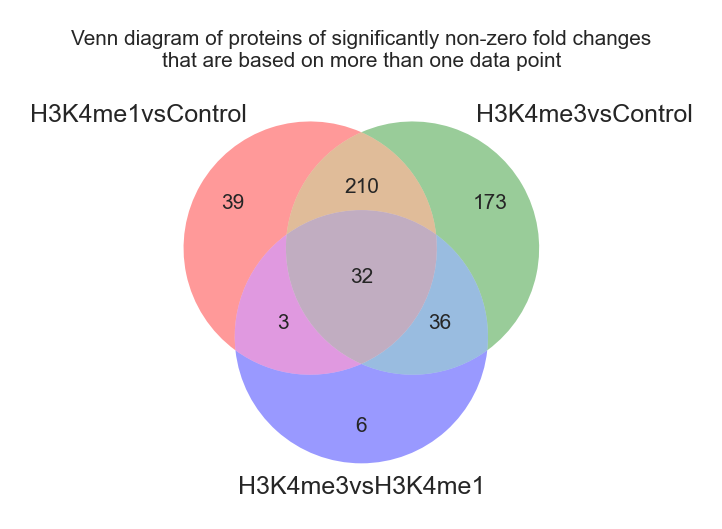

In [118]:
ax = plt.gca()

set_labels = coef_estimates_contrasts.columns


set_members = [ 
     set(full_results[full_results[c, 'significant'].fillna(False)].index) - set(full_results[full_results[c, 'logFC_based_on_single_datapoint'].fillna(False)].index)
    for c in coef_estimates_contrasts.columns
]
venn3_unweighted(set_members, set_labels=set_labels)

ax.set_title("Venn diagram of proteins of significantly non-zero fold changes\nthat are based on more than one data point")


_fname = OUTPUT_DIRECTORY / f'08-venn-diagram-significant-more-than-one-datapoint.pdf'
_caption = f"""

Venn diagram of proteins whose fold change estimates are statistically non zero. (limma, at FDR {FDR_THRESHOLD}, BH correction).
Note that the venn diagram areas are not representative of the counts in the slices.
"""
plt.savefig(_fname, bbox_inches='tight', dpi=DPI)
with open(str(_fname) + '.caption.md', 'w') as f:
    f.write(_caption)
    print(_caption)



Venn diagram of proteins whose fold change estimates are statistically non zero. (limma, at FDR 0.05, BH correction),
and whose estimates are based on >1 data point.
Note that the venn diagram areas are not representative of the counts in the slices.



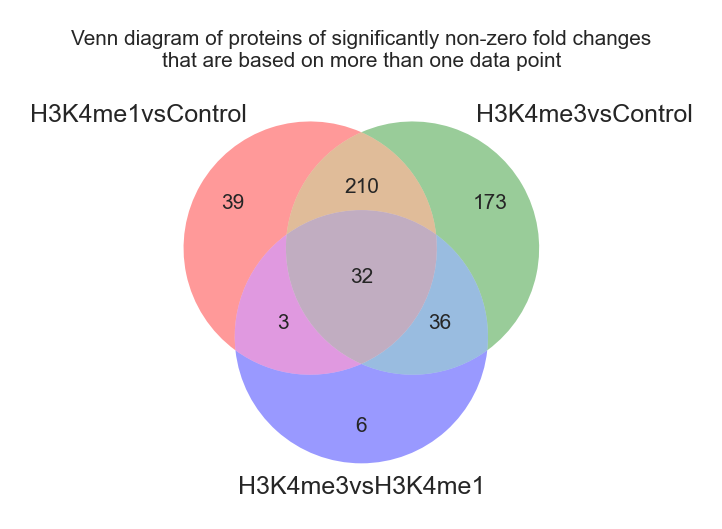

In [119]:
ax = plt.gca()

set_labels = coef_estimates_contrasts.columns


set_members = [ 
     set(full_results[full_results[c, 'significant'].fillna(False)].index) - set(full_results[full_results[c, 'logFC_based_on_single_datapoint'].fillna(False)].index)
    for c in coef_estimates_contrasts.columns
]
venn3_unweighted(set_members, set_labels=set_labels)

ax.set_title("Venn diagram of proteins of significantly non-zero fold changes\nthat are based on more than one data point")


_fname = OUTPUT_DIRECTORY / f'08-venn-diagram-significant-more-than-one-datapoint.pdf'
_caption = f"""

Venn diagram of proteins whose fold change estimates are statistically non zero. (limma, at FDR {FDR_THRESHOLD}, BH correction),
and whose estimates are based on >1 data point.
Note that the venn diagram areas are not representative of the counts in the slices.
"""
plt.savefig(_fname, bbox_inches='tight', dpi=DPI)
with open(str(_fname) + '.caption.md', 'w') as f:
    f.write(_caption)
    print(_caption)



Venn diagram of proteins whose fold change estimates are statistically non zero. (limma, at FDR 0.05, BH correction).
And whose H3K4me1vsControl and H3K4me3vsControl imputed logFC estimates are greater than zero



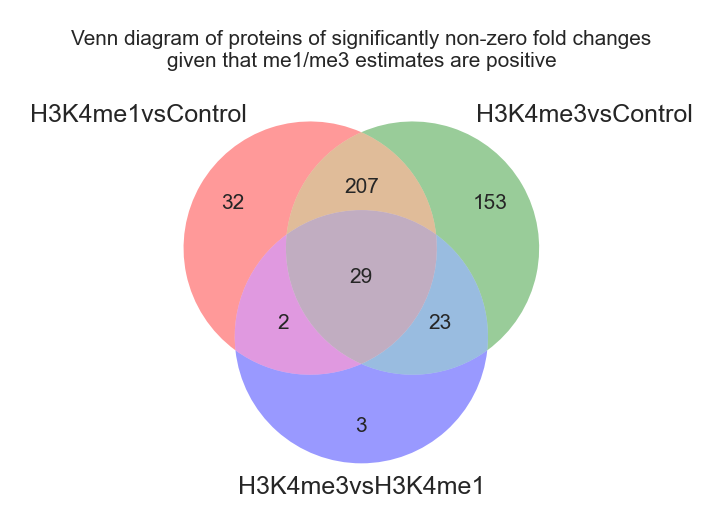

In [120]:
ax = plt.gca()

set_labels = coef_estimates_contrasts.columns


set_members = [ 
    set(full_results[full_results[c, 'significant'].fillna(False)].index) 
        & set(full_results[(full_results['H3K4me1vsControl', 'logFC_imputed'] > 0).fillna(False)].index)
        & set(full_results[(full_results['H3K4me3vsControl', 'logFC_imputed'] > 0).fillna(False)].index)
    for c in coef_estimates_contrasts.columns
]
venn3_unweighted(set_members, set_labels=set_labels)

ax.set_title("Venn diagram of proteins of significantly non-zero fold changes\ngiven that me1/me3 estimates are positive")


_fname = OUTPUT_DIRECTORY / f'08-venn-diagram-significant-me1me3-positive.pdf'
_caption = f"""

Venn diagram of proteins whose fold change estimates are statistically non zero. (limma, at FDR {FDR_THRESHOLD}, BH correction).
And whose H3K4me1vsControl and H3K4me3vsControl imputed logFC estimates are greater than zero
"""
plt.savefig(_fname, bbox_inches='tight', dpi=DPI)
with open(str(_fname) + '.caption.md', 'w') as f:
    f.write(_caption)
    print(_caption)

### Scatterplots

/usr/local/Caskroom/miniconda/base/envs/marcs-chip-ms-h3k4me1-h3k4me3/lib/python3.10/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/usr/local/Caskroom/miniconda/base/envs/marcs-chip-ms-h3k4me1-h3k4me3/lib/python3.10/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/usr/local/Caskroom/miniconda/base/envs/marcs-chip-ms-h3k4me1-h3k4me3/lib/python3.10/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/usr/local/Caskroom/miniconda/base/envs/marcs-chip-ms-h3k4me1-h3k4me3/lib/python3.10/site-packages/sklearn/utils/valid


A scatterplot diagram of model estimates.
Log2 fold changes me3 vs controls (H3 and H4) of all proteins are plotted on the x axis, and the log2FC(me1/controls) on the y.

The first plot simply plots the whole data, the second plot highlights proteins used to normalise the data, while the remaining three plots highlight proteins for which
the corresponding estimates are statistically non zero. (limma, at FDR 0.05, BH correction).
Labels are displayed for a handful of outlier proteins.



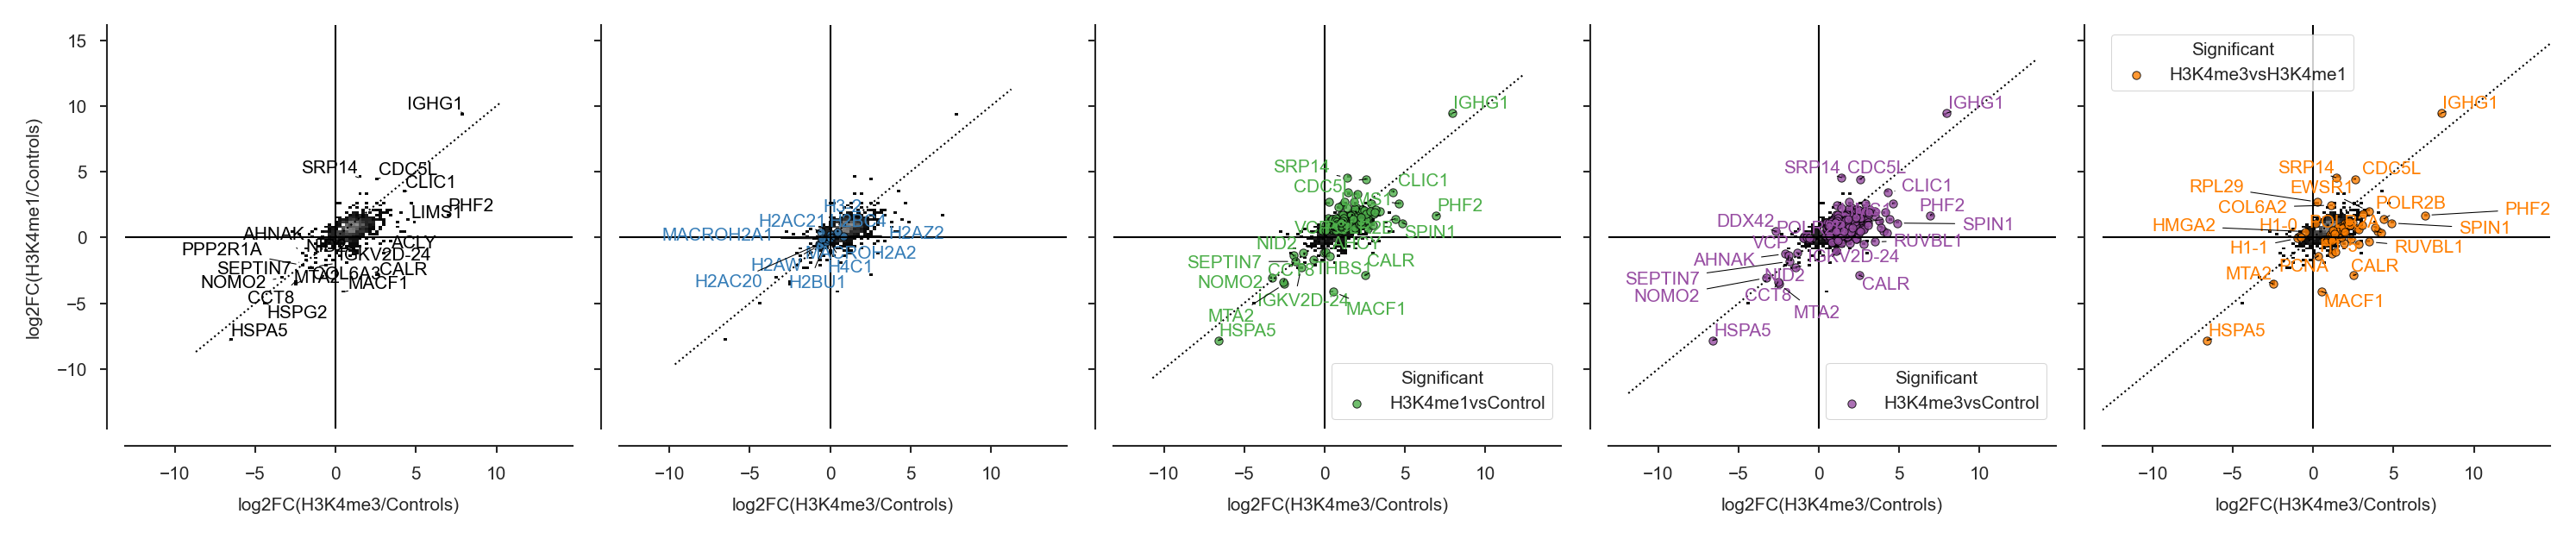

In [121]:
from sklearn.ensemble import IsolationForest
from adjustText import adjust_text

fig = plt.figure(figsize=(50*FIVE_MM_IN_INCH, 10*FIVE_MM_IN_INCH), constrained_layout=True)

axes = fig.subplots(nrows=1, ncols=5, sharex=True, sharey=True)

_x = ('H3K4me3vsControl', 'logFC')
_y = ('H3K4me1vsControl', 'logFC')
_df = full_results.dropna(subset=[_x, _y])
_approx_nlabels = 20

for ax, col, color in zip(axes, [None] + ['normalisation_proteins'] + list(contrasts_matrix_as_df.columns), sns.color_palette('Set1')):

    sns.histplot(
        x=_x, 
        y=_y, 
        data=_df,
        cmap=sns.blend_palette(['#000000','#969696'], as_cmap=True),
        ax=ax,
    )
    
    if col is None:
        if_ = IsolationForest(random_state=42, contamination=np.clip(_approx_nlabels/len(_df), 1e-5, 0.5))
        
        outliers = if_.fit_predict(_df[[_x, _y]])
        outliers = pd.Series((outliers == -1), index=_df.index)
        
        texts = []
        for ix in outliers[outliers].index:
            texts.append(ax.text(_df.loc[ix, _x], _df.loc[ix, _y], ix, color='black'))
        
        adjust_text(texts, arrowprops=dict(arrowstyle='-'), ax=ax)
    elif col == 'normalisation_proteins':
        
        
        ax.scatter(
            _df.loc[HISTONES, _x],
            _df.loc[HISTONES, _y],
            color=color,
            edgecolor='black',
            alpha=0.8,
            s=5,
            label=col,
        )
        
        texts = []
        for ix in HISTONES:
            texts.append(ax.text(_df.loc[ix, _x], _df.loc[ix, _y], ix, color=color))
        
        adjust_text(texts, arrowprops=dict(arrowstyle='-'), ax=ax)
    
    else:
        subdf = _df[_df[col, 'significant'].fillna(False)]
    
        if_ = IsolationForest(random_state=42, contamination=np.clip(_approx_nlabels/len(subdf), 1e-5, 0.5))
        outliers = if_.fit_predict(subdf[[_x, _y]])
        outliers = pd.Series((outliers == -1), index=subdf.index)
        
        ax.scatter(
            subdf[_x],
            subdf[_y],
            color=color,
            edgecolor='black',
            alpha=0.8,
            s=5,
            label=col,
        )
        
        ax.legend(title="Significant")
        
        texts = []
        for ix in outliers[outliers].index:
            texts.append(ax.text(_df.loc[ix, _x], _df.loc[ix, _y], ix, color=color))
        
        adjust_text(texts, arrowprops=dict(arrowstyle='-'), ax=ax)

    ax.grid(False)
    
    ax.axvline(0, color='black', linestyle='-', linewidth=0.5)
    ax.axhline(0, color='black', linestyle='-', linewidth=0.5)
    
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    min_ = np.min([xlim, ylim])
    max_ = np.max([xlim, ylim])
    
    ax.plot([min_, max_], [min_, max_], linestyle=':', color='k')
    ax.set_xlim(*xlim, *ylim)
    ax.set_xlabel('log2FC(H3K4me3/Controls)')
    ax.set_ylabel('log2FC(H3K4me1/Controls)')
   
    sns.despine(offset=5, ax=ax)
    
_fname = OUTPUT_DIRECTORY / f'09-scatterplot-full-results_logfc.pdf'
_caption = f"""
A scatterplot diagram of model estimates.
Log2 fold changes me3 vs controls (H3 and H4) of all proteins are plotted on the x axis, and the log2FC(me1/controls) on the y.

The first plot simply plots the whole data, the second plot highlights proteins used to normalise the data, while the remaining three plots highlight proteins for which
the corresponding estimates are statistically non zero. (limma, at FDR {FDR_THRESHOLD}, BH correction).
Labels are displayed for a handful of outlier proteins.
"""
plt.savefig(_fname, bbox_inches='tight', dpi=DPI)
with open(str(_fname) + '.caption.md', 'w') as f:
    f.write(_caption)
    print(_caption)

And a zoomed in version of this plot

/usr/local/Caskroom/miniconda/base/envs/marcs-chip-ms-h3k4me1-h3k4me3/lib/python3.10/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/usr/local/Caskroom/miniconda/base/envs/marcs-chip-ms-h3k4me1-h3k4me3/lib/python3.10/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/usr/local/Caskroom/miniconda/base/envs/marcs-chip-ms-h3k4me1-h3k4me3/lib/python3.10/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
/usr/local/Caskroom/miniconda/base/envs/marcs-chip-ms-h3k4me1-h3k4me3/lib/python3.10/site-packages/sklearn/utils/valid


A scatterplot diagram of model estimates.
Log2 fold changes me3 vs controls (H3 and H4) of all proteins are plotted on the x axis, and the log2FC(me1/controls) on the y.

The first plot simply plots the whole data, the second plot highlights proteins used to normalise the data, while the remaining three plots highlight proteins for which
the corresponding estimates are statistically non zero. (limma, at FDR 0.05, BH correction).
Labels are displayed for a handful of outlier proteins.

Note that this plot zooms in to the area defined by the following limits: [-3, 5].
8 proteins outside of axis limits: ['CCT8 (x=-2.54, y=-3.38)', 'HSPA5 (x=-6.62, y=-7.84)', 'HSPG2 (x=-4.36, y=-5.03)', 'IGHG1 (x=7.96, y=9.46)', 'MACF1 (x=0.54, y=-4.13)', 'MTA2 (x=-2.49, y=-3.54)', 'NOMO2 (x=-3.28, y=-3.08)', 'PHF2 (x=6.94, y=1.68)']



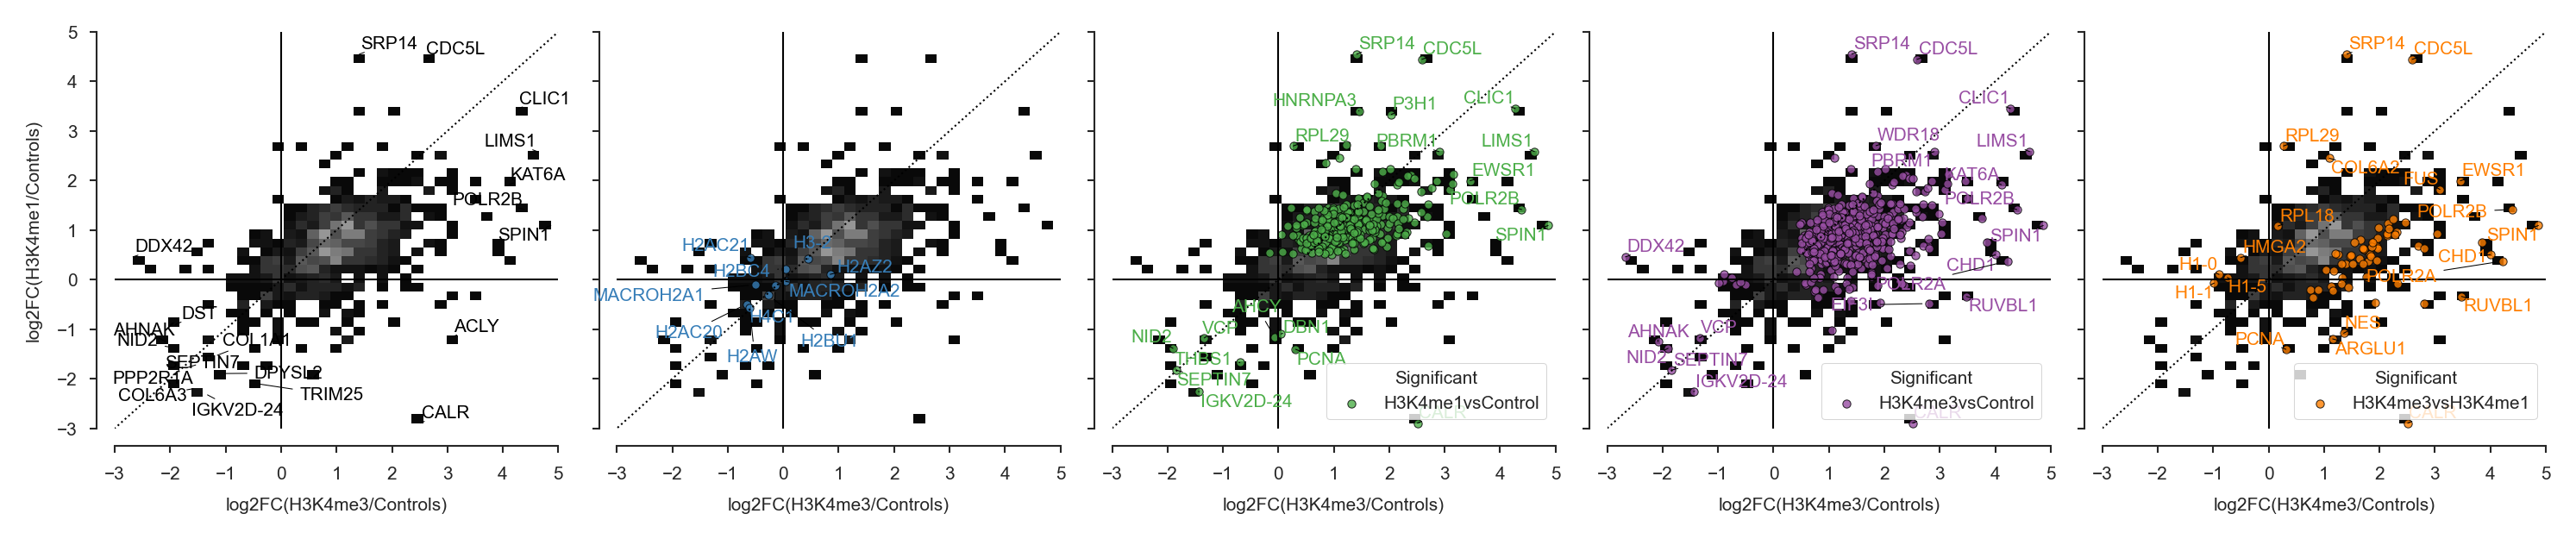

In [122]:
from sklearn.ensemble import IsolationForest
from adjustText import adjust_text

fig = plt.figure(figsize=(50*FIVE_MM_IN_INCH, 10*FIVE_MM_IN_INCH), constrained_layout=True)

axes = fig.subplots(nrows=1, ncols=5, sharex=True, sharey=True)

_x = ('H3K4me3vsControl', 'logFC')
_y = ('H3K4me1vsControl', 'logFC')

_limits = [-3, 5]

_df = full_results.dropna(subset=[_x, _y])
_mask = _df[_x].between(*_limits) & _df[_y].between(*_limits)
to_drop = _df[~_mask]
drop_statement = '{:,} proteins outside of axis limits: {}'.format(
    len(to_drop), ['{} (x={:.2f}, y={:.2f})'.format(ix, row[_x], row[_y]) for ix, row in to_drop.sort_index().iterrows()]
)

_df = _df[_mask]

_approx_nlabels = 20

for ax, col, color in zip(axes, [None] + ['normalisation_proteins'] + list(contrasts_matrix_as_df.columns), sns.color_palette('Set1')):

    sns.histplot(
        x=_x, 
        y=_y, 
        data=_df,
        cmap=sns.blend_palette(['#000000','#969696'], as_cmap=True),
        ax=ax,
    )
    
    if col is None:
        if_ = IsolationForest(random_state=42, contamination=np.clip(_approx_nlabels/len(_df), 1e-5, 0.5))
        
        outliers = if_.fit_predict(_df[[_x, _y]])
        outliers = pd.Series((outliers == -1), index=_df.index)
        
        texts = []
        for ix in outliers[outliers].index:
            texts.append(ax.text(_df.loc[ix, _x], _df.loc[ix, _y], ix, color='black'))
        
        adjust_text(texts, arrowprops=dict(arrowstyle='-'), ax=ax)
    elif col == 'normalisation_proteins':
        
        
        ax.scatter(
            _df.loc[HISTONES, _x],
            _df.loc[HISTONES, _y],
            color=color,
            edgecolor='black',
            alpha=0.8,
            s=5,
            label=col,
        )
        
        texts = []
        for ix in HISTONES:
            texts.append(ax.text(_df.loc[ix, _x], _df.loc[ix, _y], ix, color=color))
        
        adjust_text(texts, arrowprops=dict(arrowstyle='-'), ax=ax)
    
    else:
        subdf = _df[_df[col, 'significant'].fillna(False)]
    
        if_ = IsolationForest(random_state=42, contamination=np.clip(_approx_nlabels/len(subdf), 1e-5, 0.5))
        outliers = if_.fit_predict(subdf[[_x, _y]])
        outliers = pd.Series((outliers == -1), index=subdf.index)
        
        ax.scatter(
            subdf[_x],
            subdf[_y],
            color=color,
            edgecolor='black',
            alpha=0.8,
            s=5,
            label=col,
        )
        
        ax.legend(title="Significant")
        ax.set_xlim(*_limits)
        ax.set_ylim(*_limits)
        texts = []
        for ix in outliers[outliers].index:
            texts.append(ax.text(_df.loc[ix, _x], _df.loc[ix, _y], ix, color=color))
        
        adjust_text(texts, arrowprops=dict(arrowstyle='-'), ax=ax)

    ax.grid(False)
    
    ax.axvline(0, color='black', linestyle='-', linewidth=0.5)
    ax.axhline(0, color='black', linestyle='-', linewidth=0.5)
    
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    min_ = np.min([xlim, ylim])
    max_ = np.max([xlim, ylim])
    
    ax.plot([min_, max_], [min_, max_], linestyle=':', color='k')
    ax.set_xlim(*xlim, *ylim)
    ax.set_xlabel('log2FC(H3K4me3/Controls)')
    ax.set_ylabel('log2FC(H3K4me1/Controls)')
   
    sns.despine(offset=5, ax=ax)
    
_fname = OUTPUT_DIRECTORY / f'09-scatterplot-full-results_logfc_zoomed_in.pdf'
_caption = f"""
A scatterplot diagram of model estimates.
Log2 fold changes me3 vs controls (H3 and H4) of all proteins are plotted on the x axis, and the log2FC(me1/controls) on the y.

The first plot simply plots the whole data, the second plot highlights proteins used to normalise the data, while the remaining three plots highlight proteins for which
the corresponding estimates are statistically non zero. (limma, at FDR {FDR_THRESHOLD}, BH correction).
Labels are displayed for a handful of outlier proteins.

Note that this plot zooms in to the area defined by the following limits: {_limits}.
{drop_statement}
"""
plt.savefig(_fname, bbox_inches='tight', dpi=DPI)
with open(str(_fname) + '.caption.md', 'w') as f:
    f.write(_caption)
    print(_caption)